In [ ]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
from jax.flatten_util import ravel_pytree

import seaborn as sns
sns.set(style="white", context="talk")

# --- Configuration ---
SEED = 2026
key = jax.random.PRNGKey(SEED)

NB_EPOCHS = 5
NB_ITER_PER_EPOCH = 300
PRINT_EVERY = 10
LEARNING_RATE = 1e-4
# NB_LOSS_FRAMES = 2
NB_LOSS_PIXELS = 50
P_FORCING = 0.5

ROOT_WIDTH = 32
ROOT_DEPTH = 3
NUM_FOURIER_FREQS = 12

In [ ]:
def sbimshow(img, title="", ax=None):
    img = np.clip(img, 0.0, 1.0)
    if ax is None:
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    else:
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')

def plot_pred_ref_videos(video, ref_video, title="Render"):
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))
    t_mid = len(video) // 2
    t_end = len(video) - 1
    # t_mid = 1
    # t_end = 2
    
    sbimshow(video[0], title=f"{title} t=0", ax=ax[0, 0])
    sbimshow(video[t_mid], title=f"{title} t={t_mid}", ax=ax[0, 1])
    sbimshow(video[t_end], title=f"{title} t={t_end}", ax=ax[0, 2])

    sbimshow(ref_video[0], title="Ref t=0", ax=ax[1, 0])
    sbimshow(ref_video[t_mid], title=f"Ref t={t_mid}", ax=ax[1, 1])
    sbimshow(ref_video[t_end], title=f"Ref t={t_end}", ax=ax[1, 2])
    plt.tight_layout()
    plt.show()

def plot_pred_video(video, title="Render"):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    t_mid = len(video) // 2
    t_end = len(video) - 1
    
    sbimshow(video[0], title=f"{title} t=0", ax=ax[0])
    sbimshow(video[t_mid], title=f"{title} t={t_mid}", ax=ax[1])
    sbimshow(video[t_end], title=f"{title} t={t_end}", ax=ax[2])
    plt.tight_layout()
    plt.show()

# --- Data Loading ---
print("Loading Earth frames...")
ref_video = []
try:
    for i in range(1, 25):
        file_number = str(i).zfill(4)
        frame = plt.imread(f'earth_frames/{file_number}.png')[..., :3] / 1.
        ref_video.append(frame)
    ref_video = jnp.stack(ref_video, axis=0)
except FileNotFoundError:
    print("earth_frames folder not found. Generating dummy sequence for testing...")
    ref_video = jax.random.uniform(key, (24, 64, 64, 3))

nb_frames, H, W, C = ref_video.shape
print(f"Video shape: {ref_video.shape}")

# Precompute Normalized Coordinates
y_coords = jnp.linspace(-1, 1, H)
x_coords = jnp.linspace(-1, 1, W)
X_grid, Y_grid = jnp.meshgrid(x_coords, y_coords)
coords_grid = jnp.stack([X_grid, Y_grid], axis=-1)  # [H, W, 2]

Loading Earth frames...
Video shape: (24, 100, 100, 3)


In [ ]:
def fourier_encode(x, num_freqs):
    freqs = 2.0 ** jnp.arange(num_freqs)
    angles = x[..., None] * freqs[None, None, :] * jnp.pi
    angles = angles.reshape(*x.shape[:-1], -1)
    return jnp.concatenate([x, jnp.sin(angles), jnp.cos(angles)], axis=-1)

    # return x

class RootMLP(eqx.Module):
    layers: list

    def __init__(self, in_size, out_size, width, depth, key):
        keys = jax.random.split(key, depth + 1)
        self.layers = [eqx.nn.Linear(in_size, width, key=keys[0])]
        for i in range(depth - 1):
            self.layers.append(eqx.nn.Linear(width, width, key=keys[i+1]))
        self.layers.append(eqx.nn.Linear(width, out_size, key=keys[-1]))

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.relu(layer(x))
        return self.layers[-1](x)

# class CNNEncoder(eqx.Module):
#     """
#     A simple CNN that downsamples spatial dimensions and applies a dense layer.
#     Used for both the hypernetwork \phi and the recurrence feature extractor \psi.
#     """
#     layers: list
    
#     def __init__(self, in_channels, out_dim, spatial_shape, key):
#         H, W = spatial_shape
#         keys = jax.random.split(key, 4)
        
#         # 3 downsampling stages
#         conv_layers = [
#             eqx.nn.Conv2d(in_channels, 16, kernel_size=3, stride=2, padding=1, key=keys[0]),
#             eqx.nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, key=keys[1]),
#             eqx.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, key=keys[2]),
#         ]
        
#         # --- DYNAMIC SHAPE CALCULATION ---
#         # Pass a dummy tensor to automatically calculate the exact flattened dimension
#         dummy_x = jnp.zeros((in_channels, H, W))
#         for layer in conv_layers:
#             dummy_x = layer(dummy_x)
            
#         flat_dim = dummy_x.reshape(-1).shape[0]
        
#         # Assemble the final layers list with the correctly sized Linear layer
#         self.layers = conv_layers + [
#             eqx.nn.Linear(flat_dim, out_dim, key=keys[3])
#         ]
        
#     def __call__(self, x):
#         # Equinox Conv2d expects inputs in (Channels, Height, Width) format
#         for layer in self.layers[:-1]:
#             x = layer(x)
#             x = jax.nn.relu(x)
        
#         x = x.reshape(-1)  # Flatten
#         x = self.layers[-1](x)  # Dense matrix at the end
#         return x


class CNNEncoder(eqx.Module):
    """
    A simple CNN that downsamples spatial dimensions and applies a dense layer.
    Used for both the hypernetwork \phi and the recurrence feature extractor \psi.
    """
    layers: list
    
    def __init__(self, in_channels, out_dim, spatial_shape, key, hidden_width=16, depth=3):
        H, W = spatial_shape
        keys = jax.random.split(key, depth + 1)
        
        # Dynamically build the convolutional layers based on depth
        conv_layers = []
        current_in_channels = in_channels
        current_out_channels = hidden_width
        
        for i in range(depth):
            conv_layers.append(
                eqx.nn.Conv2d(
                    current_in_channels, 
                    current_out_channels, 
                    kernel_size=3, 
                    stride=2, 
                    padding=1, 
                    key=keys[i]
                )
            )
            # Double the feature maps as spatial dimensions halve
            current_in_channels = current_out_channels
            current_out_channels *= 2
            
        # --- DYNAMIC SHAPE CALCULATION ---
        # Pass a dummy tensor to automatically calculate the exact flattened dimension
        dummy_x = jnp.zeros((in_channels, H, W))
        for layer in conv_layers:
            dummy_x = layer(dummy_x)
            
        flat_dim = dummy_x.reshape(-1).shape[0]
        
        # Assemble the final layers list with the correctly sized Linear layer
        self.layers = conv_layers + [
            eqx.nn.Linear(flat_dim, out_dim, key=keys[depth])
        ]
        
    def __call__(self, x):
        # Equinox Conv2d expects inputs in (Channels, Height, Width) format
        for layer in self.layers[:-1]:
            x = layer(x)
            x = jax.nn.relu(x)
        
        x = x.reshape(-1)  # Flatten
        x = self.layers[-1](x)  # Dense matrix at the end
        return x


class DownsamplingLayer(eqx.Module):
    layer: eqx.Module
    def __init__(self, in_channels, out_channels, kernel_size=2, stride=2, *, key):
        self.layer = eqx.nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding="SAME", key=key)
    
    def __call__(self, x):
        return self.layer(x)

class UpsamplingLayer(eqx.Module):
    layer: eqx.Module

    def __init__(self, in_channels, out_channels, kernel_size=2, stride=2, *, key):
        self.layer = eqx.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding="SAME", key=key)

    def __call__(self, x):
        return self.layer(x)

class DoubleConv(eqx.Module):
    layer_1: eqx.Module
    layer_2: eqx.Module
    activation: callable
    norm_layer: eqx.Module
    dropout_rate: float

    def __init__(self, in_channels, out_channels, kernel_size=3, activation=jax.nn.relu, batch_norm=False, dropout_rate=0., *, key):
        k1, k2 = jax.random.split(key, 2)

        self.layer_1 = eqx.nn.Conv2d(in_channels, out_channels, kernel_size, padding='SAME', key=k1)
        self.layer_2 = eqx.nn.Conv2d(out_channels, out_channels, kernel_size, padding='SAME', key=k2)
        self.activation = activation
        
        if batch_norm:
            self.norm_layer = eqx.nn.BatchNorm(input_size=out_channels, axis_name=None)
        else:
            self.norm_layer = None
            
        self.dropout_rate = dropout_rate

    def __call__(self, x):
        x = self.layer_1(x)
        x = self.activation(x)
        x = self.layer_2(x)
        x = self.activation(x)
        if self.norm_layer:
            x = self.norm_layer(x)
        if self.dropout_rate > 0.:
            x = eqx.nn.Dropout(self.dropout_rate)(x)
        return x

class VNetEncoder(eqx.Module):
    input_shape: tuple
    out_dim: int
    levels: int
    depth: int
    kernel_size: int
    activation: callable
    batch_norm: bool
    dropout_rate: float

    ## Learnable params
    left_doubleconvs: dict
    right_doubleconvs: dict
    downsamplings: dict
    upsamplings: dict
    final_conv: eqx.Module
    final_linear: eqx.nn.Linear

    def __init__(self, input_shape, out_dim, levels=4, depth=16, kernel_size=3, activation=jax.nn.relu, batch_norm=False, dropout_rate=0., *, key):
        l_key, r_key, d_key, u_key, f_key, lin_key = jax.random.split(key, 6)

        self.input_shape = input_shape      ## (C, H, W)
        self.out_dim = out_dim              ## Flat output size
        self.levels = levels
        self.depth = depth                  ## Number of filters in the first layer
        self.kernel_size = kernel_size
        self.activation = activation
        self.batch_norm = batch_norm
        self.dropout_rate = dropout_rate

        self.left_doubleconvs = {}
        self.right_doubleconvs = {}
        self.downsamplings = {}
        self.upsamplings = {}
        
        # Maintains depth channels for the final spatial projection
        self.final_conv = eqx.nn.Conv2d(depth, depth, 1, padding="SAME", key=f_key)

        d_keys = jax.random.split(d_key, levels-1)
        l_keys = jax.random.split(l_key, levels)

        self.left_doubleconvs[0] = DoubleConv(input_shape[0], depth, kernel_size, activation, batch_norm, dropout_rate, key=l_keys[0])
        for i in range(1, levels):
            self.downsamplings[i] = DownsamplingLayer(self.depth*2**(i-1), self.depth*2**(i), key=d_keys[i-1])
            self.left_doubleconvs[i] = DoubleConv(self.depth*2**(i), self.depth*2**(i), kernel_size, activation, batch_norm, dropout_rate, key=l_keys[i])

        u_keys = jax.random.split(u_key, levels-1)
        r_keys = jax.random.split(r_key, levels-1)

        for i in range(self.levels-2, -1, -1):
            self.upsamplings[i] = UpsamplingLayer(self.depth*2**(i+1), self.depth*2**i, key=u_keys[i])
            self.right_doubleconvs[i] = DoubleConv(self.depth*2**(i), self.depth*2**i, kernel_size, activation, batch_norm, dropout_rate, key=r_keys[i])

        # --- DYNAMIC SHAPE CALCULATION ---
        dummy_x = jnp.zeros(input_shape)
        dummy_out = self._forward_features(dummy_x)
        flat_dim = dummy_out.reshape(-1).shape[0]

        # Final dense mapping to your requested 1D state
        self.final_linear = eqx.nn.Linear(flat_dim, out_dim, key=lin_key)

    def _forward_features(self, inputs):
        left = {}
        left[0] = self.left_doubleconvs[0](inputs)
        for i in range(1, self.levels):
            down = self.downsamplings[i](left[i-1])
            conv = self.left_doubleconvs[i](down)
            left[i] = down + conv

        central = left[self.levels-1]
        right = central

        for i in range(self.levels-2, -1,-1):
            up = self.upsamplings[i](right)
            add = left[i] + up
            conv = self.right_doubleconvs[i](add)
            right = up + conv

        return self.activation(self.final_conv(right))

    def __call__(self, inputs):
        # 1. Extract VNet features
        features = self._forward_features(inputs)
        # 2. Flatten
        flat_features = features.reshape(-1)
        # 3. Project to out_dim
        return self.final_linear(flat_features)

class WARP(eqx.Module):
    A: jax.Array
    B: jax.Array
    hypernet_phi: CNNEncoder
    psi_net: CNNEncoder
    
    root_structure: RootMLP = eqx.field(static=True)
    unravel_fn: callable = eqx.field(static=True)
    d_theta: int = eqx.field(static=True)
    num_freqs: int = eqx.field(static=True)
    frame_shape: tuple = eqx.field(static=True)

    def __init__(self, root_width, root_depth, num_freqs, frame_shape, key):
        k_root, k_A, k_B, k_phi, k_psi = jax.random.split(key, 5)
        self.num_freqs = num_freqs
        self.frame_shape = frame_shape
        H, W, C = frame_shape
        
        # Spatial input only (no tau)
        coord_dim = 2 + 2 * 2 * num_freqs 
        template_root = RootMLP(coord_dim, 7, root_width, root_depth, k_root)

        flat_params, self.unravel_fn = ravel_pytree(template_root)
        self.d_theta = flat_params.shape[0]
        self.root_structure = template_root
        
        # 1. Hypernetwork \phi: Maps initial frame (C channels) -> theta_0
        # self.hypernet_phi = CNNEncoder(in_channels=C, out_dim=self.d_theta, spatial_shape=(H, W), key=k_phi)
        # self.hypernet_phi = eqx.nn.Linear(H*W*C, self.d_theta, key=k_phi)
        # self.hypernet_phi = VNetEncoder(
        #             input_shape=(C, H, W), 
        #             out_dim=self.d_theta, 
        #             levels=2, 
        #             depth=8, 
        #             batch_norm=False, 
        #             key=k_phi
        #         )
        self.hypernet_phi = CNNEncoder(in_channels=C, out_dim=self.d_theta, spatial_shape=(H, W), key=k_phi, hidden_width=32, depth=4)

        # 2. CNN \psi: Extracts features from [frame_t, prev_frame_selected]
        # We concatenate them along channels, so in_channels = 2 * C
        d_feat = 1024  # Dimension of the feature vector extracted by \psi
        self.psi_net = CNNEncoder(in_channels=1 * C, out_dim=d_feat, spatial_shape=(H, W), key=k_psi)
        
        # 3. Recurrence Matrices
        self.A = jnp.eye(self.d_theta)
        # B is now significantly reduced: (d_theta, d_feat) instead of (d_theta, H*W*C)
        self.B = jnp.zeros((self.d_theta, d_feat))

        print(f"Model Initialized:")
        print(f"  d_theta (State Size): {self.d_theta}")
        print(f"  Matrix A Shape: {self.A.shape}")
        print(f"  Matrix B Shape: {self.B.shape}")

    def render_pixels(self, thetas, coords):
        def render_pt(theta, coord):
            root = self.unravel_fn(theta)
            encoded_coord = fourier_encode(coord, self.num_freqs)
            out = root(encoded_coord)
            
            rgb_fg = jax.nn.sigmoid(out[0:3])
            rgb_bg = jax.nn.sigmoid(out[3:6])
            alpha  = jax.nn.sigmoid(out[6:7])
            return alpha * rgb_fg + (1.0 - alpha) * rgb_bg

        return jax.vmap(render_pt)(thetas, coords)

    def get_thetas_and_preds(self, ref_video, p_forcing, key, coords_grid):
        H, W, C = self.frame_shape
        flat_coords = coords_grid.reshape(-1, 2)
        
        # --- NEW: Get initial theta_0 from Hypernetwork \phi ---
        init_gt_frame = ref_video[0]
        # Equinox convolutions expect (C, H, W)
        init_gt_frame_chw = jnp.transpose(init_gt_frame, (2, 0, 1)) 
        # init_gt_frame_chw = init_gt_frame.reshape(-1)       ## TODO
        theta_0 = self.hypernet_phi(init_gt_frame_chw)
        
        def scan_step(state, gt_curr_frame):
            theta, prev_frame_selected, k = state
            k, subk = jax.random.split(k)
            
            # 1. Render current frame
            thetas_frame = jnp.tile(theta, (H*W, 1))
            pred_flat = self.render_pixels(thetas_frame, flat_coords)
            pred_frame = pred_flat.reshape(H, W, C)
            
            # 2. Bernoulli Teacher Forcing decision
            use_gt = jax.random.bernoulli(subk, p_forcing)
            frame_t = jnp.where(use_gt, gt_curr_frame, pred_frame)
            
            # # --- NEW: Compute dense features via CNN \psi ---
            # # Concatenate current frame and prev frame (H, W, 2*C)
            # concat_frames = jnp.concatenate([frame_t, prev_frame_selected], axis=-1)
            # # Transpose to (2*C, H, W) for Equinox Conv2D
            # concat_frames_chw = jnp.transpose(concat_frames, (2, 0, 1))
            
            # # Pass through \psi
            # dx_feat = self.psi_net(concat_frames_chw)

            # Variance scaling for stable gradients in the recurrence
            # dx_feat = dx_feat / jnp.sqrt(dx_feat.size)

            frame_t_feats = self.psi_net(jnp.transpose(frame_t, (2, 0, 1)))
            prev_frame_selected_feats = self.psi_net(jnp.transpose(prev_frame_selected, (2, 0, 1)))

            dx_feat = (frame_t_feats - prev_frame_selected_feats) / jnp.sqrt(frame_t_feats.size)

            # 4. Weight-space Recurrence Update
            theta_next = self.A @ theta + self.B @ dx_feat
            
            new_state = (theta_next, frame_t, subk)
            return new_state, pred_frame
            
        init_frame = jnp.zeros((H, W, C))
        init_state = (theta_0, init_frame, key)
        
        # Scan over the sequence length
        _, pred_video = jax.lax.scan(scan_step, init_state, ref_video)
        return pred_video

<>:68: SyntaxWarning: invalid escape sequence '\p'
<>:68: SyntaxWarning: invalid escape sequence '\p'
<ipython-input-3-9f859faf544d>:68: SyntaxWarning: invalid escape sequence '\p'
  """


Model Initialized:
  d_theta (State Size): 3975
  Matrix A Shape: (3975, 3975)
  Matrix B Shape: (3975, 1024)


<ipython-input-4-4ed282286f71>:3: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = WARP(ROOT_WIDTH, ROOT_DEPTH, NUM_FOURIER_FREQS, (H, W, C), subkey)


Rendering Initial Video...


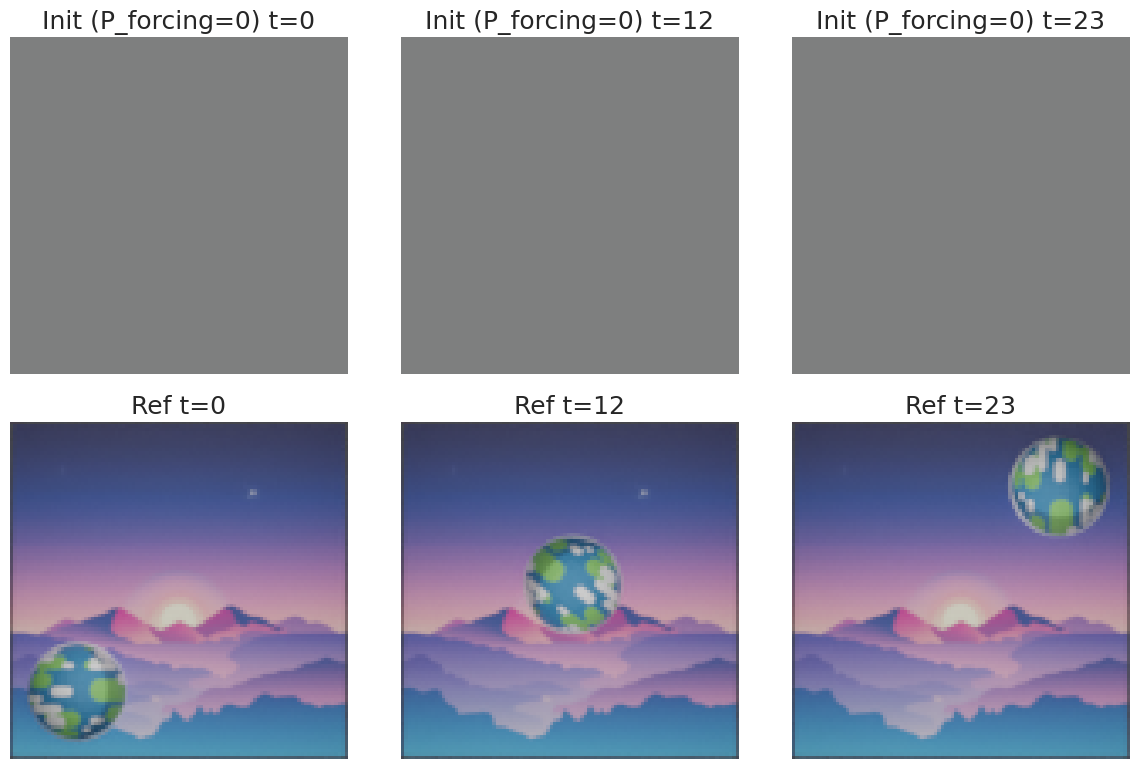


EPOCH: 1


Loss: 0.0214: 100%|██████████| 300/300 [00:38<00:00,  7.88it/s]


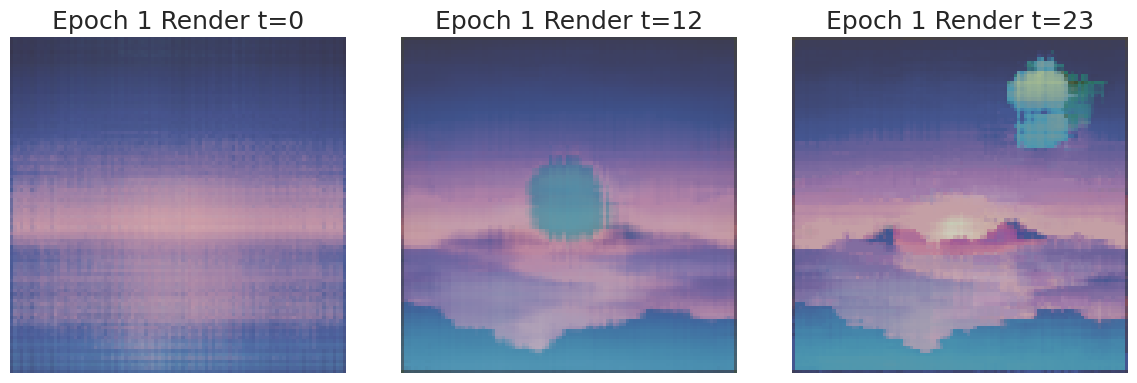


EPOCH: 2


Loss: 0.0159: 100%|██████████| 300/300 [00:35<00:00,  8.45it/s]


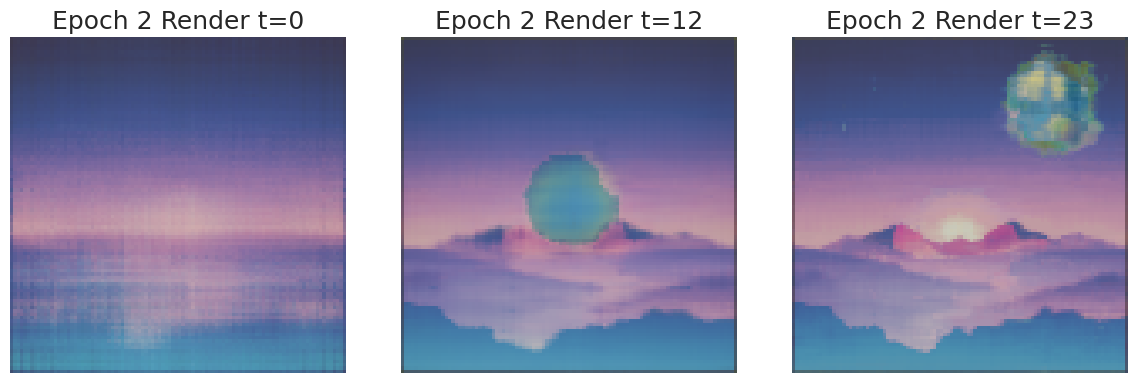


EPOCH: 3


Loss: 0.0126: 100%|██████████| 300/300 [00:35<00:00,  8.45it/s]


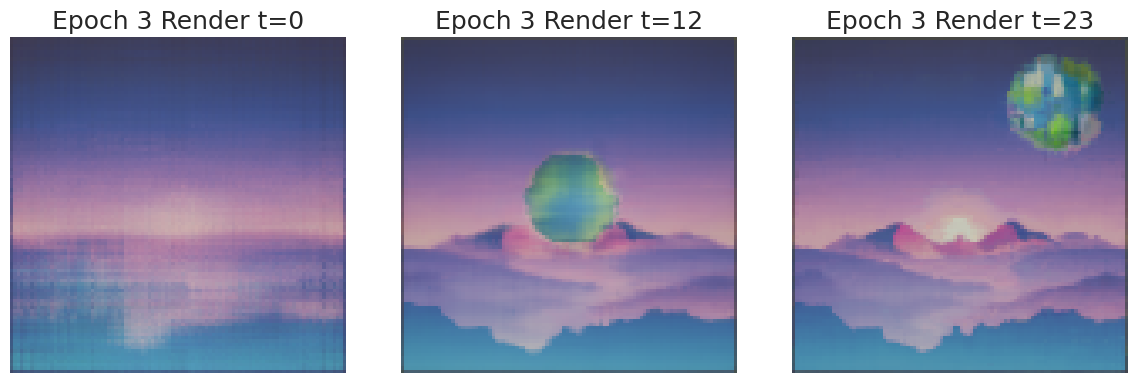


EPOCH: 4


Loss: 0.0110: 100%|██████████| 300/300 [00:35<00:00,  8.44it/s]


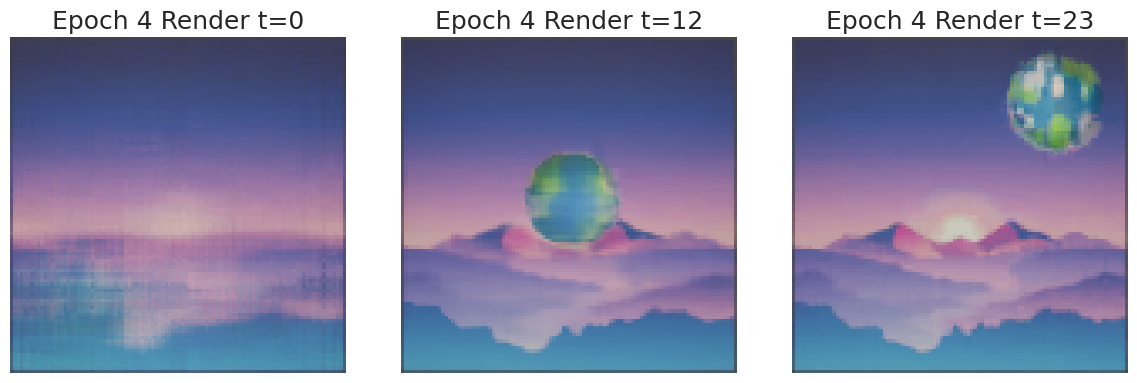


EPOCH: 5


Loss: 0.0102: 100%|██████████| 300/300 [00:35<00:00,  8.44it/s]


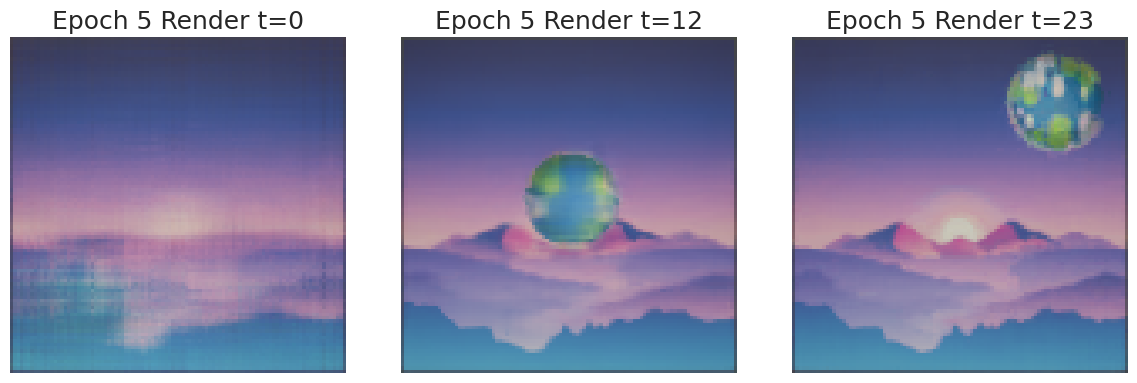


Wall time for WARP training in h:m:s: 00:03:01


In [ ]:
key, subkey = jax.random.split(key)
model = WARP(ROOT_WIDTH, ROOT_DEPTH, NUM_FOURIER_FREQS, (H, W, C), subkey)
A_init = model.A.copy()

scheduler = optax.exponential_decay(LEARNING_RATE, transition_steps=NB_ITER_PER_EPOCH*NB_EPOCHS, decay_rate=0.1)
optimizer = optax.adam(scheduler)
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))

@eqx.filter_jit
def train_step(model, opt_state, key, ref_video, coords_grid, p_forcing):
    def loss_fn(m):
        pred_video = m.get_thetas_and_preds(ref_video, p_forcing, key, coords_grid)
        return jnp.mean(jnp.abs(pred_video - ref_video))  # L1 MAE Loss on full video

        # ## Randlomly select nb_loss_frames frames for loss computation
        # frame_indices = jax.random.choice(key, pred_video.shape[0], (NB_LOSS_FRAMES,), replace=False)
        # pred_selected = pred_video[frame_indices]
        # ref_selected = ref_video[frame_indices]
        # return jnp.mean((pred_selected - ref_selected)**2)

        # ## Randomly select pixels for loss computation
        # h_indices = jax.random.choice(key, pred_video.shape[1], (NB_LOSS_PIXELS,), replace=True)
        # w_indices = jax.random.choice(key, pred_video.shape[2], (NB_LOSS_PIXELS,), replace=True)
        # pred_selected = pred_video[:, h_indices, w_indices]
        # ref_selected = ref_video[:, h_indices, w_indices]
        # return jnp.mean((pred_selected - ref_selected)**2)

    # def loss_fn(m):
    #         pred_video = m.get_thetas_and_preds(ref_video, p_forcing, key, coords_grid)
            
    #         # --- CRITICAL FIX: Use the full video loss ---
    #         loss_full = jnp.mean(jnp.abs(pred_video - ref_video))
            
    #         # Add a 2x loss boost explicitly for frame 0 to force theta_0 to wake up quickly
    #         loss_t0 = jnp.mean(jnp.abs(pred_video[0] - ref_video[0]))
            
    #         return loss_full + 100.0 * loss_t0

    loss_val, grads = eqx.filter_value_and_grad(loss_fn)(model)
    updates, opt_state = optimizer.update(grads, opt_state, eqx.filter(model, eqx.is_inexact_array))
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_val

# Initial Render Plot (Autoregressive, P=0)
print("Rendering Initial Video...")
init_video = model.get_thetas_and_preds(ref_video, p_forcing=0.0, key=key, coords_grid=coords_grid)
plot_pred_ref_videos(init_video, ref_video, title="Init (P_forcing=0)")

all_losses = []
start_time = time.time()

for epoch in range(NB_EPOCHS):
    print(f"\nEPOCH: {epoch+1}")
    epoch_losses = []
    
    pbar = tqdm(range(NB_ITER_PER_EPOCH))
    for i in pbar:
        key, subkey = jax.random.split(key)
        model, opt_state, loss = train_step(model, opt_state, subkey, ref_video, coords_grid, P_FORCING)
        epoch_losses.append(loss)
        
        if i % PRINT_EVERY == 0:
            pbar.set_description(f"Loss: {loss:.4f}")
            
    all_losses.extend(epoch_losses)
    
    # Render progress at end of epoch using P_FORCING = ?
    current_video = eqx.filter_jit(model.get_thetas_and_preds)(ref_video, P_FORCING, key, coords_grid)
    plot_pred_video(current_video, title=f"Epoch {epoch+1} Render")

wall_time = time.time() - start_time
print("\nWall time for WARP training in h:m:s:", time.strftime("%H:%M:%S", time.gmtime(wall_time)))

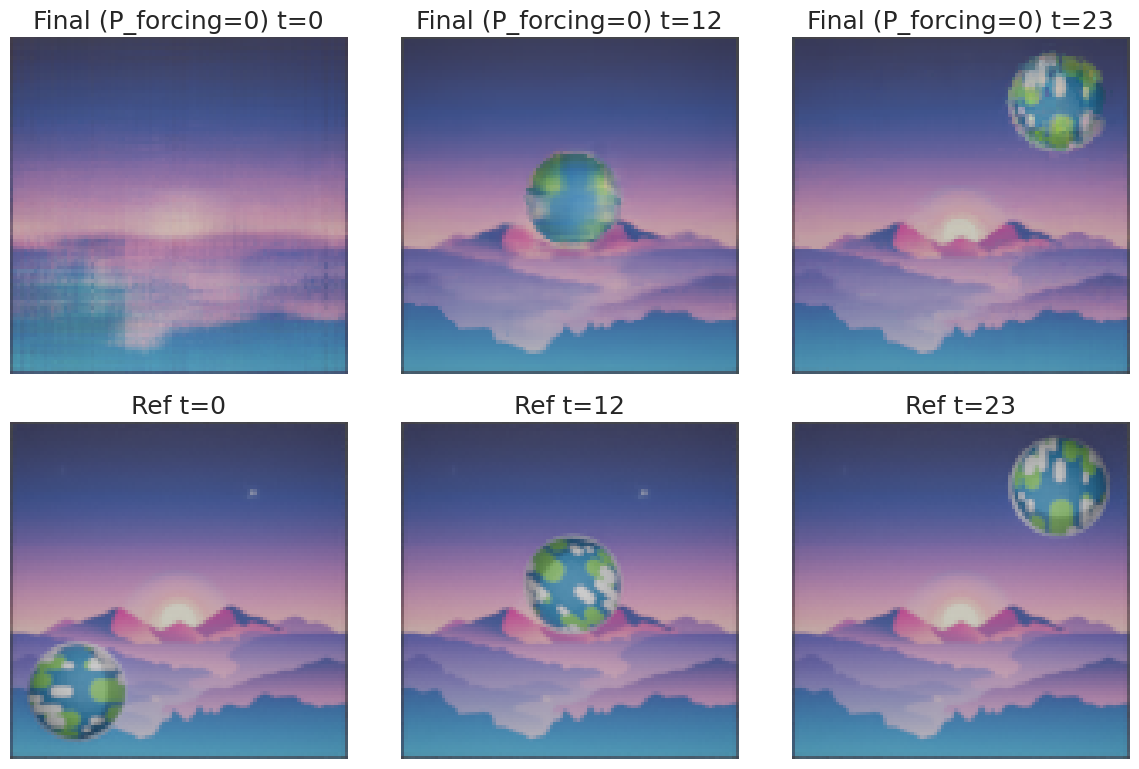

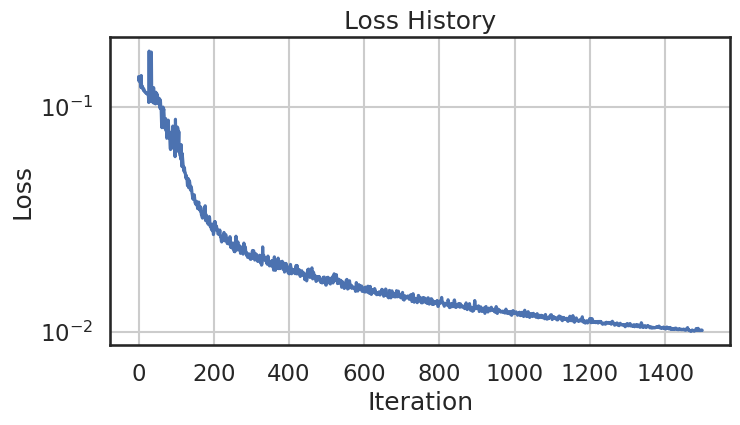

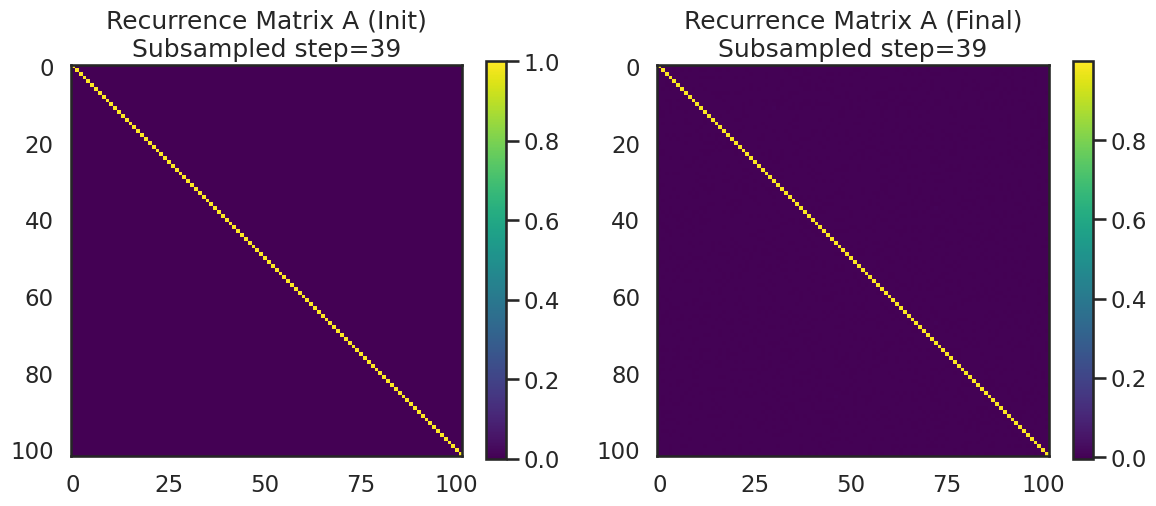

In [ ]:
# Final Video (Autoregressive, P=0)
final_video = eqx.filter_jit(model.get_thetas_and_preds)(ref_video, 0.0, key, coords_grid)
plot_pred_ref_videos(final_video, ref_video, title="Final (P_forcing=0)")

# Plot Loss
plt.figure(figsize=(8, 4))
plt.plot(all_losses)
plt.yscale('log')
plt.title("Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Plot Matrix A Before/After
A_final = model.A
subsample_step = max(1, model.d_theta // 100) 

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
im1 = axes[0].imshow(A_init[::subsample_step, ::subsample_step], cmap='viridis')
axes[0].set_title(f"Recurrence Matrix A (Init)\nSubsampled step={subsample_step}")
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(A_final[::subsample_step, ::subsample_step], cmap='viridis')
axes[1].set_title(f"Recurrence Matrix A (Final)\nSubsampled step={subsample_step}")
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

In [ ]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
from jax.flatten_util import ravel_pytree

import seaborn as sns
sns.set(style="white", context="talk")

# --- Configuration ---
SEED = 2026
key = jax.random.PRNGKey(SEED)

NB_EPOCHS = 10
NB_ITER_PER_EPOCH = 300
PRINT_EVERY = 10
LEARNING_RATE = 1e-4
# NB_LOSS_FRAMES = 2
NB_LOSS_PIXELS = 50
P_FORCING = 0.5

ROOT_WIDTH = 32
ROOT_DEPTH = 3
NUM_FOURIER_FREQS = 12

In [ ]:
def sbimshow(img, title="", ax=None):
    img = np.clip(img, 0.0, 1.0)
    if ax is None:
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    else:
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')

def plot_pred_ref_videos(video, ref_video, title="Render"):
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))
    t_mid = len(video) // 2
    t_end = len(video) - 1
    # t_mid = 1
    # t_end = 2
    
    sbimshow(video[0], title=f"{title} t=0", ax=ax[0, 0])
    sbimshow(video[t_mid], title=f"{title} t={t_mid}", ax=ax[0, 1])
    sbimshow(video[t_end], title=f"{title} t={t_end}", ax=ax[0, 2])

    sbimshow(ref_video[0], title="Ref t=0", ax=ax[1, 0])
    sbimshow(ref_video[t_mid], title=f"Ref t={t_mid}", ax=ax[1, 1])
    sbimshow(ref_video[t_end], title=f"Ref t={t_end}", ax=ax[1, 2])
    plt.tight_layout()
    plt.show()

def plot_pred_video(video, title="Render"):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    t_mid = len(video) // 2
    t_end = len(video) - 1
    
    sbimshow(video[0], title=f"{title} t=0", ax=ax[0])
    sbimshow(video[t_mid], title=f"{title} t={t_mid}", ax=ax[1])
    sbimshow(video[t_end], title=f"{title} t={t_end}", ax=ax[2])
    plt.tight_layout()
    plt.show()

# --- Data Loading ---
print("Loading Earth frames...")
ref_video = []
try:
    for i in range(1, 25):
        file_number = str(i).zfill(4)
        frame = plt.imread(f'earth_frames/{file_number}.png')[..., :3] / 1.
        ref_video.append(frame)
    ref_video = jnp.stack(ref_video, axis=0)
except FileNotFoundError:
    print("earth_frames folder not found. Generating dummy sequence for testing...")
    ref_video = jax.random.uniform(key, (24, 64, 64, 3))

nb_frames, H, W, C = ref_video.shape
print(f"Video shape: {ref_video.shape}")

# Precompute Normalized Coordinates
y_coords = jnp.linspace(-1, 1, H)
x_coords = jnp.linspace(-1, 1, W)
X_grid, Y_grid = jnp.meshgrid(x_coords, y_coords)
coords_grid = jnp.stack([X_grid, Y_grid], axis=-1)  # [H, W, 2]

Loading Earth frames...
Video shape: (24, 100, 100, 3)


In [ ]:
def fourier_encode(x, num_freqs):
    freqs = 2.0 ** jnp.arange(num_freqs)
    angles = x[..., None] * freqs[None, None, :] * jnp.pi
    angles = angles.reshape(*x.shape[:-1], -1)
    return jnp.concatenate([x, jnp.sin(angles), jnp.cos(angles)], axis=-1)

    # return x

class RootMLP(eqx.Module):
    layers: list

    def __init__(self, in_size, out_size, width, depth, key):
        keys = jax.random.split(key, depth + 1)
        self.layers = [eqx.nn.Linear(in_size, width, key=keys[0])]
        for i in range(depth - 1):
            self.layers.append(eqx.nn.Linear(width, width, key=keys[i+1]))
        self.layers.append(eqx.nn.Linear(width, out_size, key=keys[-1]))

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.relu(layer(x))
        return self.layers[-1](x)

# class CNNEncoder(eqx.Module):
#     """
#     A simple CNN that downsamples spatial dimensions and applies a dense layer.
#     Used for both the hypernetwork \phi and the recurrence feature extractor \psi.
#     """
#     layers: list
    
#     def __init__(self, in_channels, out_dim, spatial_shape, key):
#         H, W = spatial_shape
#         keys = jax.random.split(key, 4)
        
#         # 3 downsampling stages
#         conv_layers = [
#             eqx.nn.Conv2d(in_channels, 16, kernel_size=3, stride=2, padding=1, key=keys[0]),
#             eqx.nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, key=keys[1]),
#             eqx.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, key=keys[2]),
#         ]
        
#         # --- DYNAMIC SHAPE CALCULATION ---
#         # Pass a dummy tensor to automatically calculate the exact flattened dimension
#         dummy_x = jnp.zeros((in_channels, H, W))
#         for layer in conv_layers:
#             dummy_x = layer(dummy_x)
            
#         flat_dim = dummy_x.reshape(-1).shape[0]
        
#         # Assemble the final layers list with the correctly sized Linear layer
#         self.layers = conv_layers + [
#             eqx.nn.Linear(flat_dim, out_dim, key=keys[3])
#         ]
        
#     def __call__(self, x):
#         # Equinox Conv2d expects inputs in (Channels, Height, Width) format
#         for layer in self.layers[:-1]:
#             x = layer(x)
#             x = jax.nn.relu(x)
        
#         x = x.reshape(-1)  # Flatten
#         x = self.layers[-1](x)  # Dense matrix at the end
#         return x


class CNNEncoder(eqx.Module):
    """
    A simple CNN that downsamples spatial dimensions and applies a dense layer.
    Used for both the hypernetwork \phi and the recurrence feature extractor \psi.
    """
    layers: list
    
    def __init__(self, in_channels, out_dim, spatial_shape, key, hidden_width=16, depth=3):
        H, W = spatial_shape
        keys = jax.random.split(key, depth + 1)
        
        # Dynamically build the convolutional layers based on depth
        conv_layers = []
        current_in_channels = in_channels
        current_out_channels = hidden_width
        
        for i in range(depth):
            conv_layers.append(
                eqx.nn.Conv2d(
                    current_in_channels, 
                    current_out_channels, 
                    kernel_size=3, 
                    stride=2, 
                    padding=1, 
                    key=keys[i]
                )
            )
            # Double the feature maps as spatial dimensions halve
            current_in_channels = current_out_channels
            current_out_channels *= 2
            
        # --- DYNAMIC SHAPE CALCULATION ---
        # Pass a dummy tensor to automatically calculate the exact flattened dimension
        dummy_x = jnp.zeros((in_channels, H, W))
        for layer in conv_layers:
            dummy_x = layer(dummy_x)
            
        flat_dim = dummy_x.reshape(-1).shape[0]
        
        # Assemble the final layers list with the correctly sized Linear layer
        self.layers = conv_layers + [
            eqx.nn.Linear(flat_dim, out_dim, key=keys[depth])
        ]
        
    def __call__(self, x):
        # Equinox Conv2d expects inputs in (Channels, Height, Width) format
        for layer in self.layers[:-1]:
            x = layer(x)
            x = jax.nn.relu(x)
        
        x = x.reshape(-1)  # Flatten
        x = self.layers[-1](x)  # Dense matrix at the end
        return x


class DownsamplingLayer(eqx.Module):
    layer: eqx.Module
    def __init__(self, in_channels, out_channels, kernel_size=2, stride=2, *, key):
        self.layer = eqx.nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding="SAME", key=key)
    
    def __call__(self, x):
        return self.layer(x)

class UpsamplingLayer(eqx.Module):
    layer: eqx.Module

    def __init__(self, in_channels, out_channels, kernel_size=2, stride=2, *, key):
        self.layer = eqx.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding="SAME", key=key)

    def __call__(self, x):
        return self.layer(x)

class DoubleConv(eqx.Module):
    layer_1: eqx.Module
    layer_2: eqx.Module
    activation: callable
    norm_layer: eqx.Module
    dropout_rate: float

    def __init__(self, in_channels, out_channels, kernel_size=3, activation=jax.nn.relu, batch_norm=False, dropout_rate=0., *, key):
        k1, k2 = jax.random.split(key, 2)

        self.layer_1 = eqx.nn.Conv2d(in_channels, out_channels, kernel_size, padding='SAME', key=k1)
        self.layer_2 = eqx.nn.Conv2d(out_channels, out_channels, kernel_size, padding='SAME', key=k2)
        self.activation = activation
        
        if batch_norm:
            self.norm_layer = eqx.nn.BatchNorm(input_size=out_channels, axis_name=None)
        else:
            self.norm_layer = None
            
        self.dropout_rate = dropout_rate

    def __call__(self, x):
        x = self.layer_1(x)
        x = self.activation(x)
        x = self.layer_2(x)
        x = self.activation(x)
        if self.norm_layer:
            x = self.norm_layer(x)
        if self.dropout_rate > 0.:
            x = eqx.nn.Dropout(self.dropout_rate)(x)
        return x

class VNetEncoder(eqx.Module):
    input_shape: tuple
    out_dim: int
    levels: int
    depth: int
    kernel_size: int
    activation: callable
    batch_norm: bool
    dropout_rate: float

    ## Learnable params
    left_doubleconvs: dict
    right_doubleconvs: dict
    downsamplings: dict
    upsamplings: dict
    final_conv: eqx.Module
    final_linear: eqx.nn.Linear

    def __init__(self, input_shape, out_dim, levels=4, depth=16, kernel_size=3, activation=jax.nn.relu, batch_norm=False, dropout_rate=0., *, key):
        l_key, r_key, d_key, u_key, f_key, lin_key = jax.random.split(key, 6)

        self.input_shape = input_shape      ## (C, H, W)
        self.out_dim = out_dim              ## Flat output size
        self.levels = levels
        self.depth = depth                  ## Number of filters in the first layer
        self.kernel_size = kernel_size
        self.activation = activation
        self.batch_norm = batch_norm
        self.dropout_rate = dropout_rate

        self.left_doubleconvs = {}
        self.right_doubleconvs = {}
        self.downsamplings = {}
        self.upsamplings = {}
        
        # Maintains depth channels for the final spatial projection
        self.final_conv = eqx.nn.Conv2d(depth, depth, 1, padding="SAME", key=f_key)

        d_keys = jax.random.split(d_key, levels-1)
        l_keys = jax.random.split(l_key, levels)

        self.left_doubleconvs[0] = DoubleConv(input_shape[0], depth, kernel_size, activation, batch_norm, dropout_rate, key=l_keys[0])
        for i in range(1, levels):
            self.downsamplings[i] = DownsamplingLayer(self.depth*2**(i-1), self.depth*2**(i), key=d_keys[i-1])
            self.left_doubleconvs[i] = DoubleConv(self.depth*2**(i), self.depth*2**(i), kernel_size, activation, batch_norm, dropout_rate, key=l_keys[i])

        u_keys = jax.random.split(u_key, levels-1)
        r_keys = jax.random.split(r_key, levels-1)

        for i in range(self.levels-2, -1, -1):
            self.upsamplings[i] = UpsamplingLayer(self.depth*2**(i+1), self.depth*2**i, key=u_keys[i])
            self.right_doubleconvs[i] = DoubleConv(self.depth*2**(i), self.depth*2**i, kernel_size, activation, batch_norm, dropout_rate, key=r_keys[i])

        # --- DYNAMIC SHAPE CALCULATION ---
        dummy_x = jnp.zeros(input_shape)
        dummy_out = self._forward_features(dummy_x)
        flat_dim = dummy_out.reshape(-1).shape[0]

        # Final dense mapping to your requested 1D state
        self.final_linear = eqx.nn.Linear(flat_dim, out_dim, key=lin_key)

    def _forward_features(self, inputs):
        left = {}
        left[0] = self.left_doubleconvs[0](inputs)
        for i in range(1, self.levels):
            down = self.downsamplings[i](left[i-1])
            conv = self.left_doubleconvs[i](down)
            left[i] = down + conv

        central = left[self.levels-1]
        right = central

        for i in range(self.levels-2, -1,-1):
            up = self.upsamplings[i](right)
            add = left[i] + up
            conv = self.right_doubleconvs[i](add)
            right = up + conv

        return self.activation(self.final_conv(right))

    def __call__(self, inputs):
        # 1. Extract VNet features
        features = self._forward_features(inputs)
        # 2. Flatten
        flat_features = features.reshape(-1)
        # 3. Project to out_dim
        return self.final_linear(flat_features)

class WARP(eqx.Module):
    A: jax.Array
    B: jax.Array
    hypernet_phi: CNNEncoder
    psi_net: CNNEncoder
    
    root_structure: RootMLP = eqx.field(static=True)
    unravel_fn: callable = eqx.field(static=True)
    d_theta: int = eqx.field(static=True)
    num_freqs: int = eqx.field(static=True)
    frame_shape: tuple = eqx.field(static=True)

    def __init__(self, root_width, root_depth, num_freqs, frame_shape, key):
        k_root, k_A, k_B, k_phi, k_psi = jax.random.split(key, 5)
        self.num_freqs = num_freqs
        self.frame_shape = frame_shape
        H, W, C = frame_shape
        
        # Spatial input only (no tau)
        coord_dim = 2 + 2 * 2 * num_freqs 
        template_root = RootMLP(coord_dim, 7, root_width, root_depth, k_root)

        flat_params, self.unravel_fn = ravel_pytree(template_root)
        self.d_theta = flat_params.shape[0]
        self.root_structure = template_root
        
        # 1. Hypernetwork \phi: Maps initial frame (C channels) -> theta_0
        # self.hypernet_phi = CNNEncoder(in_channels=C, out_dim=self.d_theta, spatial_shape=(H, W), key=k_phi)
        # self.hypernet_phi = eqx.nn.Linear(H*W*C, self.d_theta, key=k_phi)
        # self.hypernet_phi = VNetEncoder(
        #             input_shape=(C, H, W), 
        #             out_dim=self.d_theta, 
        #             levels=2, 
        #             depth=8, 
        #             batch_norm=False, 
        #             key=k_phi
        #         )
        self.hypernet_phi = CNNEncoder(in_channels=C, out_dim=self.d_theta, spatial_shape=(H, W), key=k_phi, hidden_width=32, depth=6)

        # 2. CNN \psi: Extracts features from [frame_t, prev_frame_selected]
        # We concatenate them along channels, so in_channels = 2 * C
        d_feat = 1024  # Dimension of the feature vector extracted by \psi
        self.psi_net = CNNEncoder(in_channels=1 * C, out_dim=d_feat, spatial_shape=(H, W), key=k_psi)
        
        # 3. Recurrence Matrices
        self.A = jnp.eye(self.d_theta)
        # B is now significantly reduced: (d_theta, d_feat) instead of (d_theta, H*W*C)
        self.B = jnp.zeros((self.d_theta, d_feat))

        print(f"Model Initialized:")
        print(f"  d_theta (State Size): {self.d_theta}")
        print(f"  Matrix A Shape: {self.A.shape}")
        print(f"  Matrix B Shape: {self.B.shape}")

    def render_pixels(self, thetas, coords):
        def render_pt(theta, coord):
            root = self.unravel_fn(theta)
            encoded_coord = fourier_encode(coord, self.num_freqs)
            out = root(encoded_coord)
            
            rgb_fg = jax.nn.sigmoid(out[0:3])
            rgb_bg = jax.nn.sigmoid(out[3:6])
            alpha  = jax.nn.sigmoid(out[6:7])
            return alpha * rgb_fg + (1.0 - alpha) * rgb_bg

        return jax.vmap(render_pt)(thetas, coords)

    def get_thetas_and_preds(self, ref_video, p_forcing, key, coords_grid):
        H, W, C = self.frame_shape
        flat_coords = coords_grid.reshape(-1, 2)
        
        # --- NEW: Get initial theta_0 from Hypernetwork \phi ---
        init_gt_frame = ref_video[0]
        # Equinox convolutions expect (C, H, W)
        init_gt_frame_chw = jnp.transpose(init_gt_frame, (2, 0, 1)) 
        # init_gt_frame_chw = init_gt_frame.reshape(-1)       ## TODO
        theta_0 = self.hypernet_phi(init_gt_frame_chw)
        
        def scan_step(state, gt_curr_frame):
            theta, prev_frame_selected, k = state
            k, subk = jax.random.split(k)
            
            # 1. Render current frame
            thetas_frame = jnp.tile(theta, (H*W, 1))
            pred_flat = self.render_pixels(thetas_frame, flat_coords)
            pred_frame = pred_flat.reshape(H, W, C)
            
            # 2. Bernoulli Teacher Forcing decision
            use_gt = jax.random.bernoulli(subk, p_forcing)
            frame_t = jnp.where(use_gt, gt_curr_frame, pred_frame)
            
            # # --- NEW: Compute dense features via CNN \psi ---
            # # Concatenate current frame and prev frame (H, W, 2*C)
            # concat_frames = jnp.concatenate([frame_t, prev_frame_selected], axis=-1)
            # # Transpose to (2*C, H, W) for Equinox Conv2D
            # concat_frames_chw = jnp.transpose(concat_frames, (2, 0, 1))
            
            # # Pass through \psi
            # dx_feat = self.psi_net(concat_frames_chw)

            # Variance scaling for stable gradients in the recurrence
            # dx_feat = dx_feat / jnp.sqrt(dx_feat.size)

            frame_t_feats = self.psi_net(jnp.transpose(frame_t, (2, 0, 1)))
            prev_frame_selected_feats = self.psi_net(jnp.transpose(prev_frame_selected, (2, 0, 1)))

            dx_feat = (frame_t_feats - prev_frame_selected_feats) / jnp.sqrt(frame_t_feats.size)

            # 4. Weight-space Recurrence Update
            theta_next = self.A @ theta + self.B @ dx_feat
            
            new_state = (theta_next, frame_t, subk)
            return new_state, pred_frame
            
        init_frame = jnp.zeros((H, W, C))
        init_state = (theta_0, init_frame, key)
        
        # Scan over the sequence length
        _, pred_video = jax.lax.scan(scan_step, init_state, ref_video)
        return pred_video

<>:68: SyntaxWarning: invalid escape sequence '\p'
<>:68: SyntaxWarning: invalid escape sequence '\p'
<ipython-input-8-10c9846cf112>:68: SyntaxWarning: invalid escape sequence '\p'
  """


Model Initialized:
  d_theta (State Size): 3975
  Matrix A Shape: (3975, 3975)
  Matrix B Shape: (3975, 1024)
Rendering Initial Video...


<ipython-input-9-4ed282286f71>:3: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = WARP(ROOT_WIDTH, ROOT_DEPTH, NUM_FOURIER_FREQS, (H, W, C), subkey)


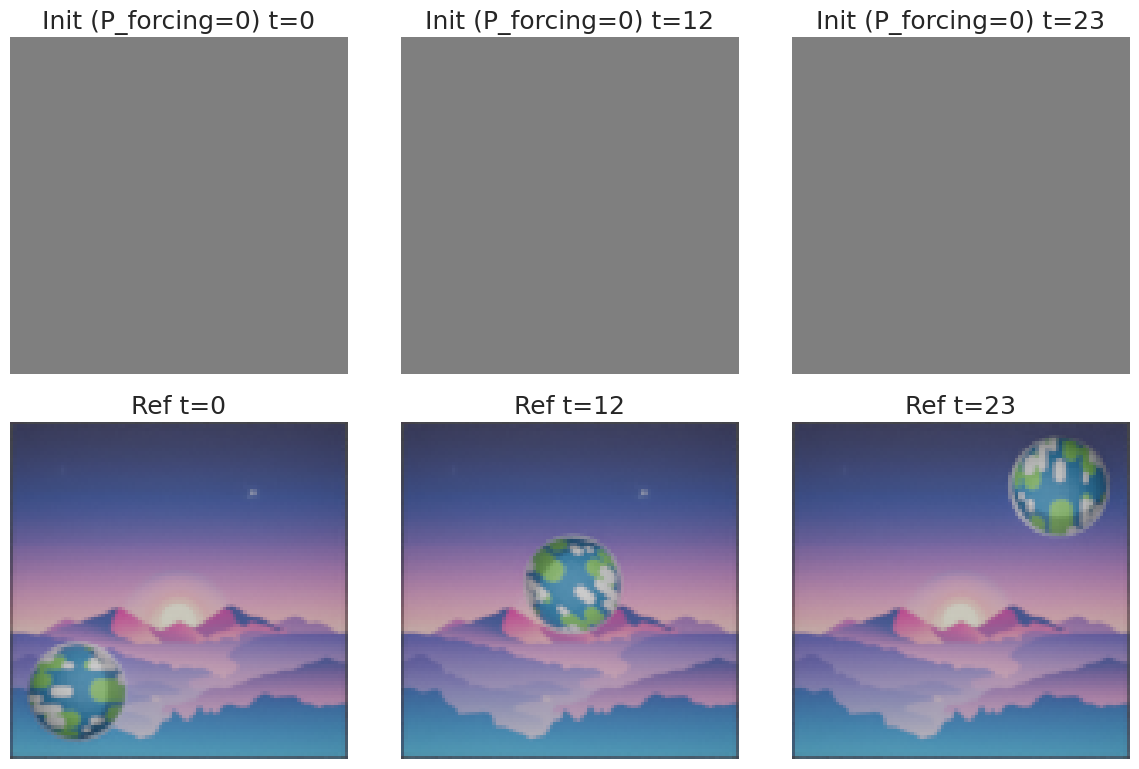


EPOCH: 1


Loss: 0.0275: 100%|██████████| 300/300 [00:36<00:00,  8.13it/s]


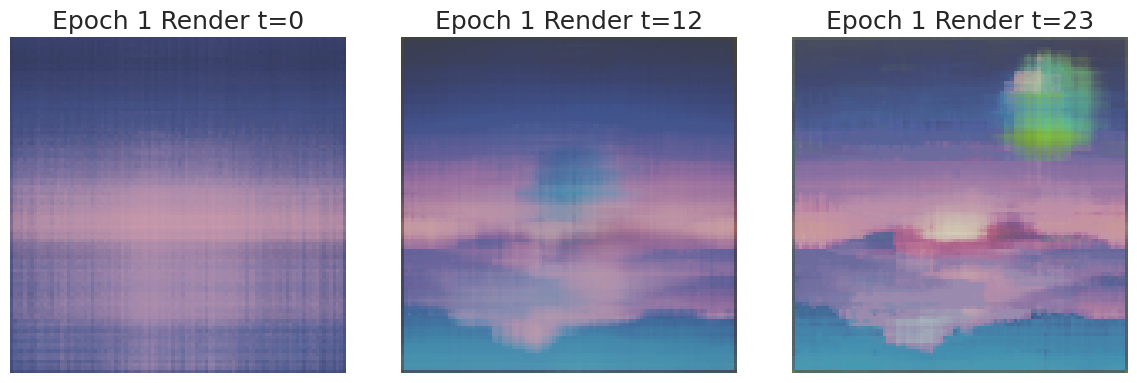


EPOCH: 2


Loss: 0.0178: 100%|██████████| 300/300 [00:35<00:00,  8.57it/s]


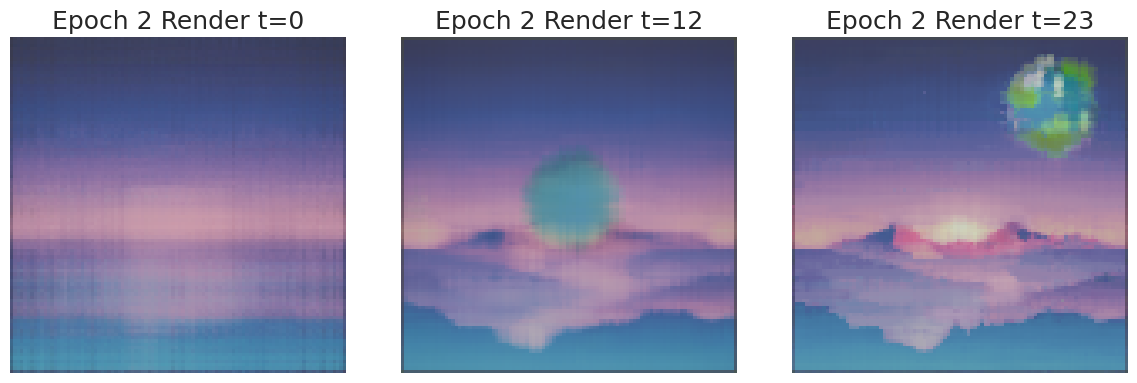


EPOCH: 3


Loss: 0.0153: 100%|██████████| 300/300 [00:35<00:00,  8.57it/s]


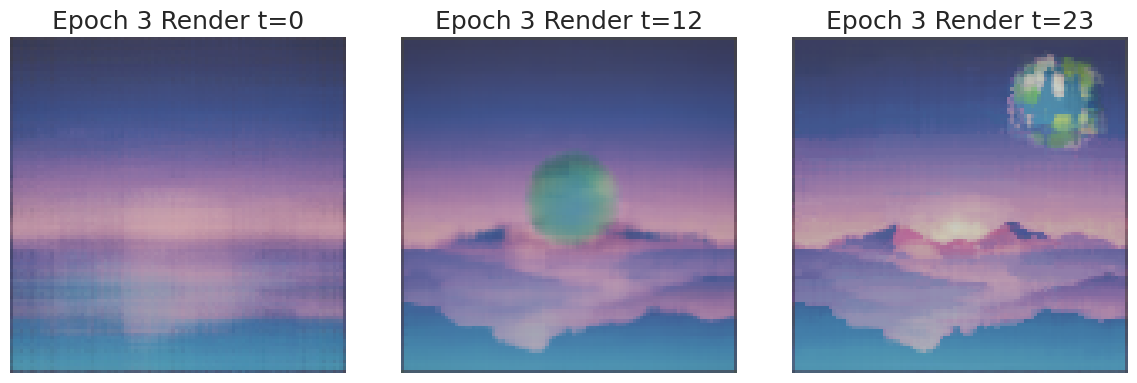


EPOCH: 4


Loss: 0.0134: 100%|██████████| 300/300 [00:35<00:00,  8.56it/s]


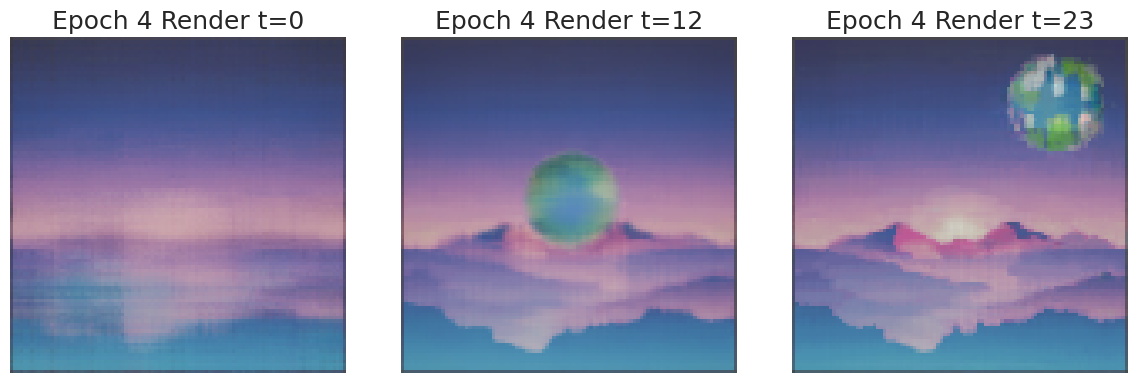


EPOCH: 5


Loss: 0.0122: 100%|██████████| 300/300 [00:34<00:00,  8.57it/s]


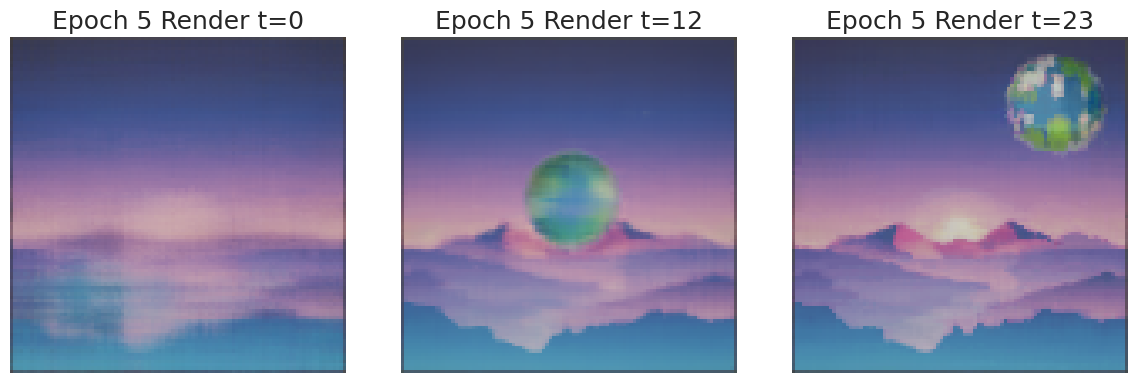


EPOCH: 6


Loss: 0.0113: 100%|██████████| 300/300 [00:35<00:00,  8.57it/s]


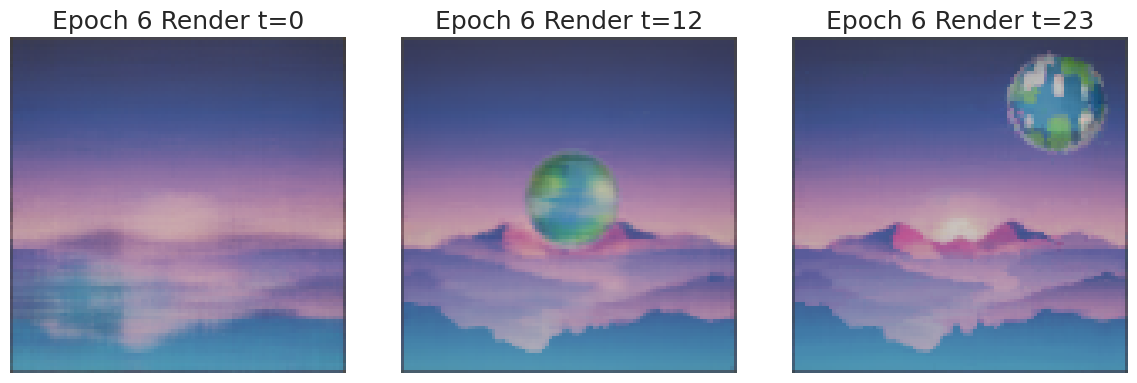


EPOCH: 7


Loss: 0.0108: 100%|██████████| 300/300 [00:34<00:00,  8.57it/s]


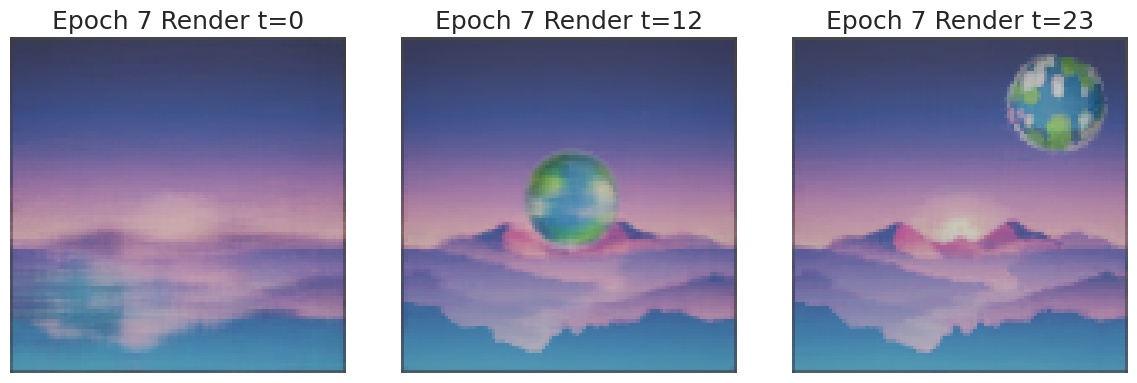


EPOCH: 8


Loss: 0.0098: 100%|██████████| 300/300 [00:35<00:00,  8.57it/s]


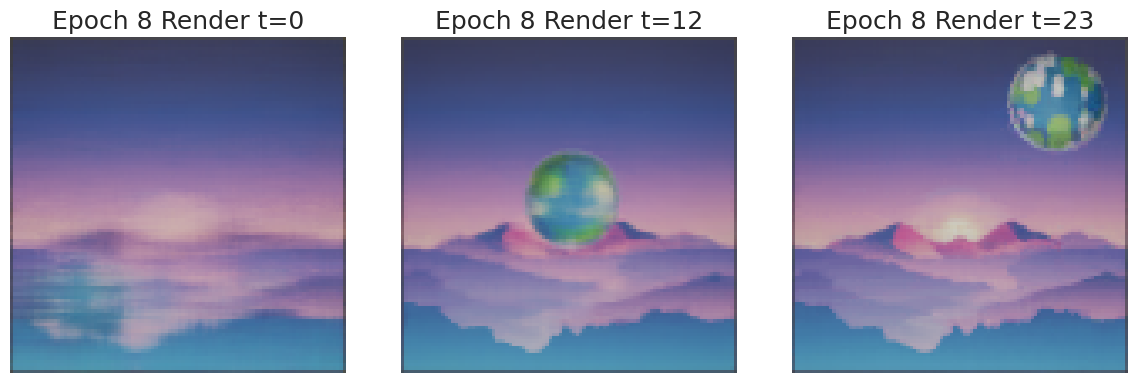


EPOCH: 9


Loss: 0.0094: 100%|██████████| 300/300 [00:34<00:00,  8.59it/s]


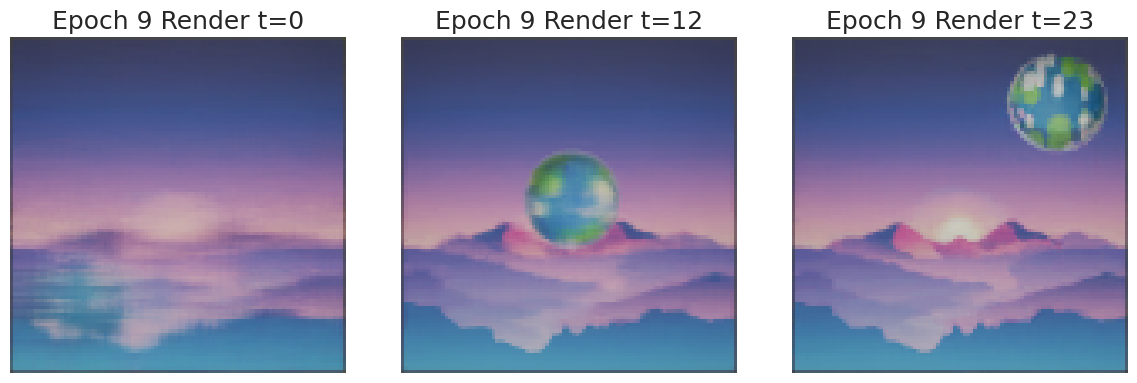


EPOCH: 10


Loss: 0.0089: 100%|██████████| 300/300 [00:34<00:00,  8.58it/s]


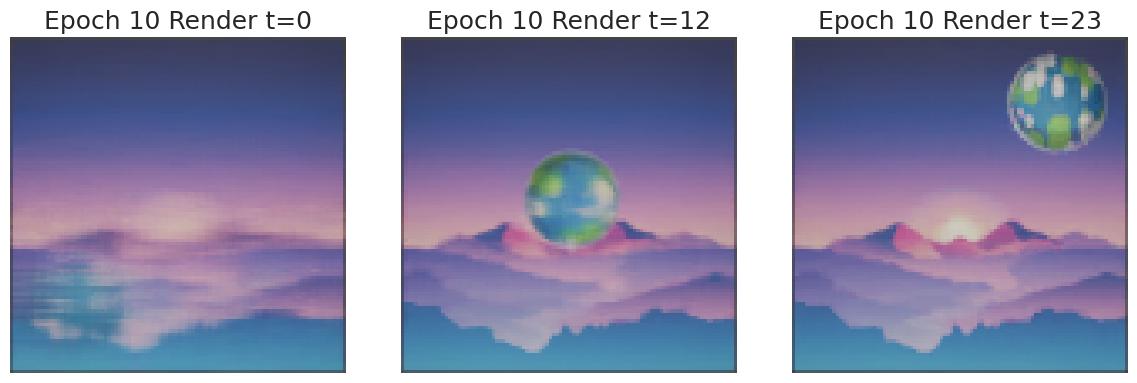


Wall time for WARP training in h:m:s: 00:05:53


In [ ]:
key, subkey = jax.random.split(key)
model = WARP(ROOT_WIDTH, ROOT_DEPTH, NUM_FOURIER_FREQS, (H, W, C), subkey)
A_init = model.A.copy()

scheduler = optax.exponential_decay(LEARNING_RATE, transition_steps=NB_ITER_PER_EPOCH*NB_EPOCHS, decay_rate=0.1)
optimizer = optax.adam(scheduler)
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))

@eqx.filter_jit
def train_step(model, opt_state, key, ref_video, coords_grid, p_forcing):
    def loss_fn(m):
        pred_video = m.get_thetas_and_preds(ref_video, p_forcing, key, coords_grid)
        return jnp.mean(jnp.abs(pred_video - ref_video))  # L1 MAE Loss on full video

        # ## Randlomly select nb_loss_frames frames for loss computation
        # frame_indices = jax.random.choice(key, pred_video.shape[0], (NB_LOSS_FRAMES,), replace=False)
        # pred_selected = pred_video[frame_indices]
        # ref_selected = ref_video[frame_indices]
        # return jnp.mean((pred_selected - ref_selected)**2)

        # ## Randomly select pixels for loss computation
        # h_indices = jax.random.choice(key, pred_video.shape[1], (NB_LOSS_PIXELS,), replace=True)
        # w_indices = jax.random.choice(key, pred_video.shape[2], (NB_LOSS_PIXELS,), replace=True)
        # pred_selected = pred_video[:, h_indices, w_indices]
        # ref_selected = ref_video[:, h_indices, w_indices]
        # return jnp.mean((pred_selected - ref_selected)**2)

    # def loss_fn(m):
    #         pred_video = m.get_thetas_and_preds(ref_video, p_forcing, key, coords_grid)
            
    #         # --- CRITICAL FIX: Use the full video loss ---
    #         loss_full = jnp.mean(jnp.abs(pred_video - ref_video))
            
    #         # Add a 2x loss boost explicitly for frame 0 to force theta_0 to wake up quickly
    #         loss_t0 = jnp.mean(jnp.abs(pred_video[0] - ref_video[0]))
            
    #         return loss_full + 100.0 * loss_t0

    loss_val, grads = eqx.filter_value_and_grad(loss_fn)(model)
    updates, opt_state = optimizer.update(grads, opt_state, eqx.filter(model, eqx.is_inexact_array))
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_val

# Initial Render Plot (Autoregressive, P=0)
print("Rendering Initial Video...")
init_video = model.get_thetas_and_preds(ref_video, p_forcing=0.0, key=key, coords_grid=coords_grid)
plot_pred_ref_videos(init_video, ref_video, title="Init (P_forcing=0)")

all_losses = []
start_time = time.time()

for epoch in range(NB_EPOCHS):
    print(f"\nEPOCH: {epoch+1}")
    epoch_losses = []
    
    pbar = tqdm(range(NB_ITER_PER_EPOCH))
    for i in pbar:
        key, subkey = jax.random.split(key)
        model, opt_state, loss = train_step(model, opt_state, subkey, ref_video, coords_grid, P_FORCING)
        epoch_losses.append(loss)
        
        if i % PRINT_EVERY == 0:
            pbar.set_description(f"Loss: {loss:.4f}")
            
    all_losses.extend(epoch_losses)
    
    # Render progress at end of epoch using P_FORCING = ?
    current_video = eqx.filter_jit(model.get_thetas_and_preds)(ref_video, P_FORCING, key, coords_grid)
    plot_pred_video(current_video, title=f"Epoch {epoch+1} Render")

wall_time = time.time() - start_time
print("\nWall time for WARP training in h:m:s:", time.strftime("%H:%M:%S", time.gmtime(wall_time)))

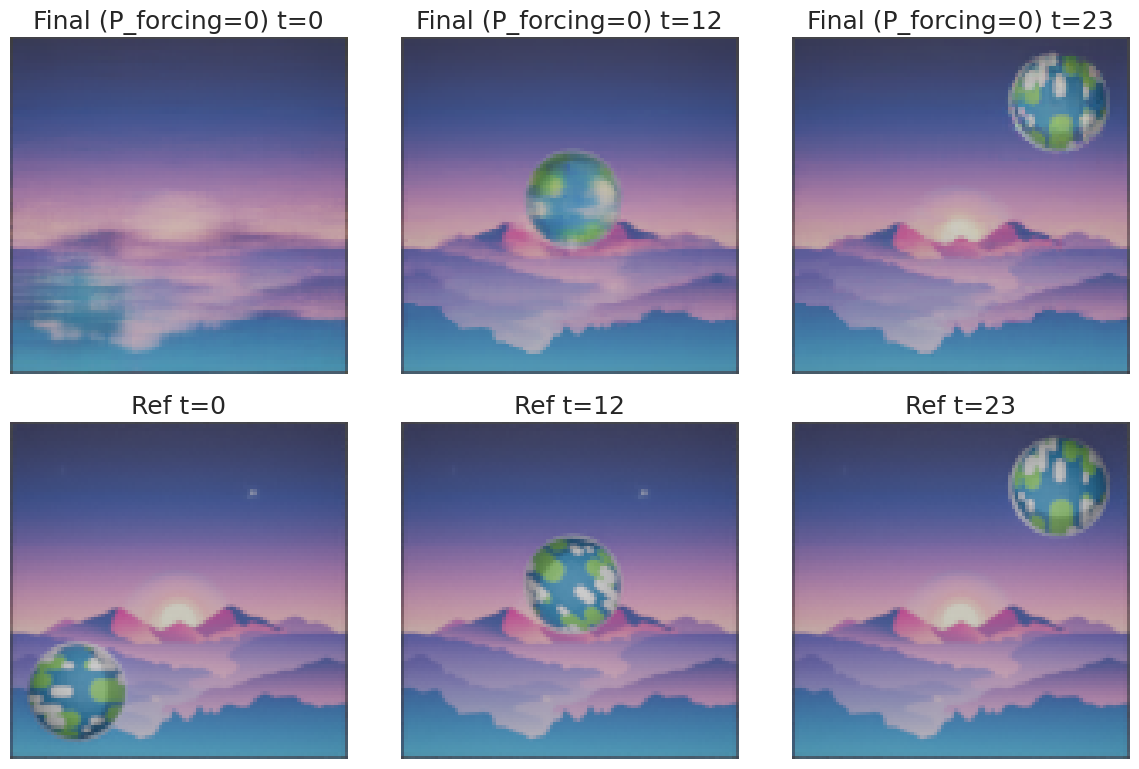

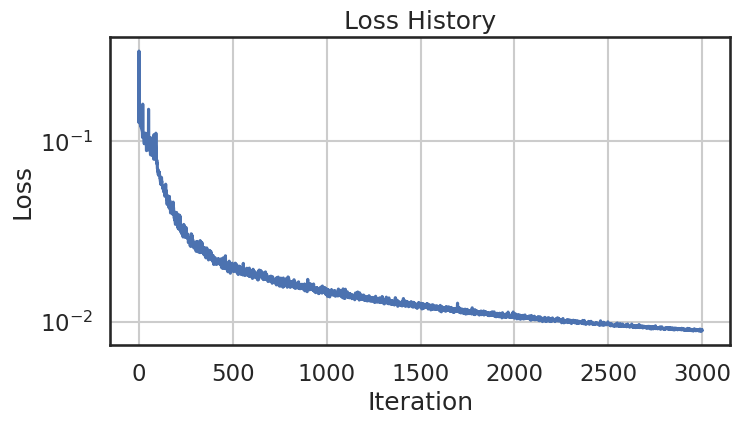

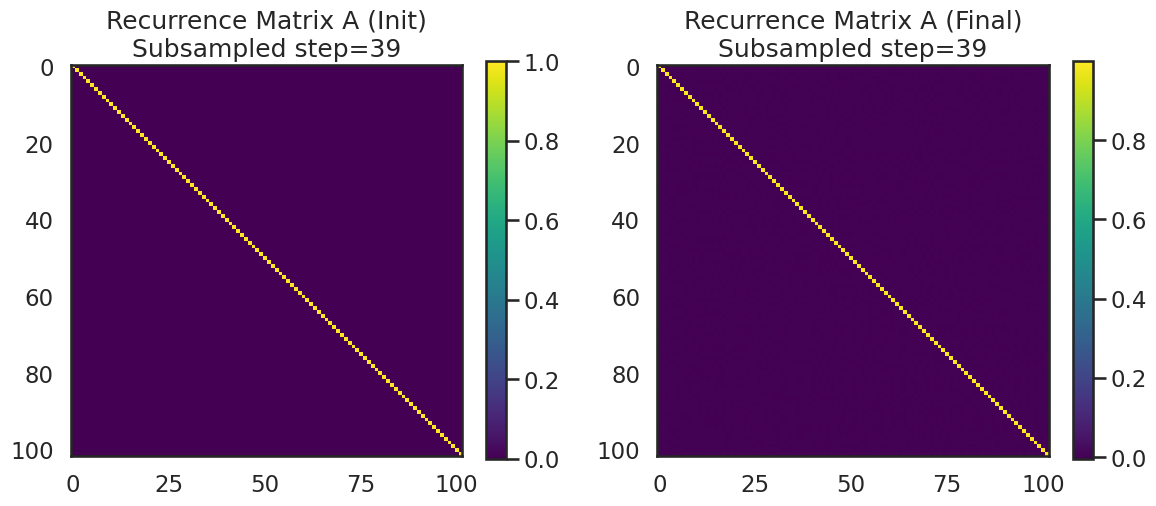

In [ ]:
# Final Video (Autoregressive, P=0)
final_video = eqx.filter_jit(model.get_thetas_and_preds)(ref_video, 0.0, key, coords_grid)
plot_pred_ref_videos(final_video, ref_video, title="Final (P_forcing=0)")

# Plot Loss
plt.figure(figsize=(8, 4))
plt.plot(all_losses)
plt.yscale('log')
plt.title("Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Plot Matrix A Before/After
A_final = model.A
subsample_step = max(1, model.d_theta // 100) 

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
im1 = axes[0].imshow(A_init[::subsample_step, ::subsample_step], cmap='viridis')
axes[0].set_title(f"Recurrence Matrix A (Init)\nSubsampled step={subsample_step}")
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(A_final[::subsample_step, ::subsample_step], cmap='viridis')
axes[1].set_title(f"Recurrence Matrix A (Final)\nSubsampled step={subsample_step}")
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

In [ ]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
from jax.flatten_util import ravel_pytree

import seaborn as sns
sns.set(style="white", context="talk")

# --- Configuration ---
SEED = 2026
key = jax.random.PRNGKey(SEED)

NB_EPOCHS = 5
NB_ITER_PER_EPOCH = 300
PRINT_EVERY = 10
LEARNING_RATE = 1e-4
# NB_LOSS_FRAMES = 2
NB_LOSS_PIXELS = 50
P_FORCING = 0.5

ROOT_WIDTH = 32
ROOT_DEPTH = 3
NUM_FOURIER_FREQS = 12

In [ ]:
def sbimshow(img, title="", ax=None):
    img = np.clip(img, 0.0, 1.0)
    if ax is None:
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    else:
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')

def plot_pred_ref_videos(video, ref_video, title="Render"):
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))
    t_mid = len(video) // 2
    t_end = len(video) - 1
    # t_mid = 1
    # t_end = 2
    
    sbimshow(video[0], title=f"{title} t=0", ax=ax[0, 0])
    sbimshow(video[t_mid], title=f"{title} t={t_mid}", ax=ax[0, 1])
    sbimshow(video[t_end], title=f"{title} t={t_end}", ax=ax[0, 2])

    sbimshow(ref_video[0], title="Ref t=0", ax=ax[1, 0])
    sbimshow(ref_video[t_mid], title=f"Ref t={t_mid}", ax=ax[1, 1])
    sbimshow(ref_video[t_end], title=f"Ref t={t_end}", ax=ax[1, 2])
    plt.tight_layout()
    plt.show()

def plot_pred_video(video, title="Render"):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    t_mid = len(video) // 2
    t_end = len(video) - 1
    
    sbimshow(video[0], title=f"{title} t=0", ax=ax[0])
    sbimshow(video[t_mid], title=f"{title} t={t_mid}", ax=ax[1])
    sbimshow(video[t_end], title=f"{title} t={t_end}", ax=ax[2])
    plt.tight_layout()
    plt.show()

# --- Data Loading ---
print("Loading Earth frames...")
ref_video = []
try:
    for i in range(1, 25):
        file_number = str(i).zfill(4)
        frame = plt.imread(f'earth_frames/{file_number}.png')[..., :3] / 1.
        ref_video.append(frame)
    ref_video = jnp.stack(ref_video, axis=0)
except FileNotFoundError:
    print("earth_frames folder not found. Generating dummy sequence for testing...")
    ref_video = jax.random.uniform(key, (24, 64, 64, 3))

nb_frames, H, W, C = ref_video.shape
print(f"Video shape: {ref_video.shape}")

# Precompute Normalized Coordinates
y_coords = jnp.linspace(-1, 1, H)
x_coords = jnp.linspace(-1, 1, W)
X_grid, Y_grid = jnp.meshgrid(x_coords, y_coords)
coords_grid = jnp.stack([X_grid, Y_grid], axis=-1)  # [H, W, 2]

Loading Earth frames...
Video shape: (24, 100, 100, 3)


In [ ]:
def fourier_encode(x, num_freqs):
    freqs = 2.0 ** jnp.arange(num_freqs)
    angles = x[..., None] * freqs[None, None, :] * jnp.pi
    angles = angles.reshape(*x.shape[:-1], -1)
    return jnp.concatenate([x, jnp.sin(angles), jnp.cos(angles)], axis=-1)

    # return x

class RootMLP(eqx.Module):
    layers: list

    def __init__(self, in_size, out_size, width, depth, key):
        keys = jax.random.split(key, depth + 1)
        self.layers = [eqx.nn.Linear(in_size, width, key=keys[0])]
        for i in range(depth - 1):
            self.layers.append(eqx.nn.Linear(width, width, key=keys[i+1]))
        self.layers.append(eqx.nn.Linear(width, out_size, key=keys[-1]))

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.relu(layer(x))
        return self.layers[-1](x)

# class CNNEncoder(eqx.Module):
#     """
#     A simple CNN that downsamples spatial dimensions and applies a dense layer.
#     Used for both the hypernetwork \phi and the recurrence feature extractor \psi.
#     """
#     layers: list
    
#     def __init__(self, in_channels, out_dim, spatial_shape, key):
#         H, W = spatial_shape
#         keys = jax.random.split(key, 4)
        
#         # 3 downsampling stages
#         conv_layers = [
#             eqx.nn.Conv2d(in_channels, 16, kernel_size=3, stride=2, padding=1, key=keys[0]),
#             eqx.nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, key=keys[1]),
#             eqx.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, key=keys[2]),
#         ]
        
#         # --- DYNAMIC SHAPE CALCULATION ---
#         # Pass a dummy tensor to automatically calculate the exact flattened dimension
#         dummy_x = jnp.zeros((in_channels, H, W))
#         for layer in conv_layers:
#             dummy_x = layer(dummy_x)
            
#         flat_dim = dummy_x.reshape(-1).shape[0]
        
#         # Assemble the final layers list with the correctly sized Linear layer
#         self.layers = conv_layers + [
#             eqx.nn.Linear(flat_dim, out_dim, key=keys[3])
#         ]
        
#     def __call__(self, x):
#         # Equinox Conv2d expects inputs in (Channels, Height, Width) format
#         for layer in self.layers[:-1]:
#             x = layer(x)
#             x = jax.nn.relu(x)
        
#         x = x.reshape(-1)  # Flatten
#         x = self.layers[-1](x)  # Dense matrix at the end
#         return x


class CNNEncoder(eqx.Module):
    """
    A simple CNN that downsamples spatial dimensions and applies a dense layer.
    Used for both the hypernetwork \phi and the recurrence feature extractor \psi.
    """
    layers: list
    
    def __init__(self, in_channels, out_dim, spatial_shape, key, hidden_width=16, depth=3):
        H, W = spatial_shape
        keys = jax.random.split(key, depth + 1)
        
        # Dynamically build the convolutional layers based on depth
        conv_layers = []
        current_in_channels = in_channels
        current_out_channels = hidden_width
        
        for i in range(depth):
            conv_layers.append(
                eqx.nn.Conv2d(
                    current_in_channels, 
                    current_out_channels, 
                    kernel_size=3, 
                    stride=2, 
                    padding=1, 
                    key=keys[i]
                )
            )
            # Double the feature maps as spatial dimensions halve
            current_in_channels = current_out_channels
            current_out_channels *= 2
            
        # --- DYNAMIC SHAPE CALCULATION ---
        # Pass a dummy tensor to automatically calculate the exact flattened dimension
        dummy_x = jnp.zeros((in_channels, H, W))
        for layer in conv_layers:
            dummy_x = layer(dummy_x)
            
        flat_dim = dummy_x.reshape(-1).shape[0]
        
        # Assemble the final layers list with the correctly sized Linear layer
        self.layers = conv_layers + [
            eqx.nn.Linear(flat_dim, out_dim, key=keys[depth])
        ]
        
    def __call__(self, x):
        # Equinox Conv2d expects inputs in (Channels, Height, Width) format
        for layer in self.layers[:-1]:
            x = layer(x)
            x = jax.nn.relu(x)
        
        x = x.reshape(-1)  # Flatten
        x = self.layers[-1](x)  # Dense matrix at the end
        return x


class DownsamplingLayer(eqx.Module):
    layer: eqx.Module
    def __init__(self, in_channels, out_channels, kernel_size=2, stride=2, *, key):
        self.layer = eqx.nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding="SAME", key=key)
    
    def __call__(self, x):
        return self.layer(x)

class UpsamplingLayer(eqx.Module):
    layer: eqx.Module

    def __init__(self, in_channels, out_channels, kernel_size=2, stride=2, *, key):
        self.layer = eqx.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding="SAME", key=key)

    def __call__(self, x):
        return self.layer(x)

class DoubleConv(eqx.Module):
    layer_1: eqx.Module
    layer_2: eqx.Module
    activation: callable
    norm_layer: eqx.Module
    dropout_rate: float

    def __init__(self, in_channels, out_channels, kernel_size=3, activation=jax.nn.relu, batch_norm=False, dropout_rate=0., *, key):
        k1, k2 = jax.random.split(key, 2)

        self.layer_1 = eqx.nn.Conv2d(in_channels, out_channels, kernel_size, padding='SAME', key=k1)
        self.layer_2 = eqx.nn.Conv2d(out_channels, out_channels, kernel_size, padding='SAME', key=k2)
        self.activation = activation
        
        if batch_norm:
            self.norm_layer = eqx.nn.BatchNorm(input_size=out_channels, axis_name=None)
        else:
            self.norm_layer = None
            
        self.dropout_rate = dropout_rate

    def __call__(self, x):
        x = self.layer_1(x)
        x = self.activation(x)
        x = self.layer_2(x)
        x = self.activation(x)
        if self.norm_layer:
            x = self.norm_layer(x)
        if self.dropout_rate > 0.:
            x = eqx.nn.Dropout(self.dropout_rate)(x)
        return x

class VNetEncoder(eqx.Module):
    input_shape: tuple
    out_dim: int
    levels: int
    depth: int
    kernel_size: int
    activation: callable
    batch_norm: bool
    dropout_rate: float

    ## Learnable params
    left_doubleconvs: dict
    right_doubleconvs: dict
    downsamplings: dict
    upsamplings: dict
    final_conv: eqx.Module
    final_linear: eqx.nn.Linear

    def __init__(self, input_shape, out_dim, levels=4, depth=16, kernel_size=3, activation=jax.nn.relu, batch_norm=False, dropout_rate=0., *, key):
        l_key, r_key, d_key, u_key, f_key, lin_key = jax.random.split(key, 6)

        self.input_shape = input_shape      ## (C, H, W)
        self.out_dim = out_dim              ## Flat output size
        self.levels = levels
        self.depth = depth                  ## Number of filters in the first layer
        self.kernel_size = kernel_size
        self.activation = activation
        self.batch_norm = batch_norm
        self.dropout_rate = dropout_rate

        self.left_doubleconvs = {}
        self.right_doubleconvs = {}
        self.downsamplings = {}
        self.upsamplings = {}
        
        # Maintains depth channels for the final spatial projection
        self.final_conv = eqx.nn.Conv2d(depth, depth, 1, padding="SAME", key=f_key)

        d_keys = jax.random.split(d_key, levels-1)
        l_keys = jax.random.split(l_key, levels)

        self.left_doubleconvs[0] = DoubleConv(input_shape[0], depth, kernel_size, activation, batch_norm, dropout_rate, key=l_keys[0])
        for i in range(1, levels):
            self.downsamplings[i] = DownsamplingLayer(self.depth*2**(i-1), self.depth*2**(i), key=d_keys[i-1])
            self.left_doubleconvs[i] = DoubleConv(self.depth*2**(i), self.depth*2**(i), kernel_size, activation, batch_norm, dropout_rate, key=l_keys[i])

        u_keys = jax.random.split(u_key, levels-1)
        r_keys = jax.random.split(r_key, levels-1)

        for i in range(self.levels-2, -1, -1):
            self.upsamplings[i] = UpsamplingLayer(self.depth*2**(i+1), self.depth*2**i, key=u_keys[i])
            self.right_doubleconvs[i] = DoubleConv(self.depth*2**(i), self.depth*2**i, kernel_size, activation, batch_norm, dropout_rate, key=r_keys[i])

        # --- DYNAMIC SHAPE CALCULATION ---
        dummy_x = jnp.zeros(input_shape)
        dummy_out = self._forward_features(dummy_x)
        flat_dim = dummy_out.reshape(-1).shape[0]

        # Final dense mapping to your requested 1D state
        self.final_linear = eqx.nn.Linear(flat_dim, out_dim, key=lin_key)

    def _forward_features(self, inputs):
        left = {}
        left[0] = self.left_doubleconvs[0](inputs)
        for i in range(1, self.levels):
            down = self.downsamplings[i](left[i-1])
            conv = self.left_doubleconvs[i](down)
            left[i] = down + conv

        central = left[self.levels-1]
        right = central

        for i in range(self.levels-2, -1,-1):
            up = self.upsamplings[i](right)
            add = left[i] + up
            conv = self.right_doubleconvs[i](add)
            right = up + conv

        return self.activation(self.final_conv(right))

    def __call__(self, inputs):
        # 1. Extract VNet features
        features = self._forward_features(inputs)
        # 2. Flatten
        flat_features = features.reshape(-1)
        # 3. Project to out_dim
        return self.final_linear(flat_features)

class WARP(eqx.Module):
    A: jax.Array
    B: jax.Array
    hypernet_phi: CNNEncoder
    psi_net: CNNEncoder
    
    root_structure: RootMLP = eqx.field(static=True)
    unravel_fn: callable = eqx.field(static=True)
    d_theta: int = eqx.field(static=True)
    num_freqs: int = eqx.field(static=True)
    frame_shape: tuple = eqx.field(static=True)

    def __init__(self, root_width, root_depth, num_freqs, frame_shape, key):
        k_root, k_A, k_B, k_phi, k_psi = jax.random.split(key, 5)
        self.num_freqs = num_freqs
        self.frame_shape = frame_shape
        H, W, C = frame_shape
        
        # Spatial input only (no tau)
        coord_dim = 2 + 2 * 2 * num_freqs 
        template_root = RootMLP(coord_dim, 7, root_width, root_depth, k_root)

        flat_params, self.unravel_fn = ravel_pytree(template_root)
        self.d_theta = flat_params.shape[0]
        self.root_structure = template_root
        
        # 1. Hypernetwork \phi: Maps initial frame (C channels) -> theta_0
        # self.hypernet_phi = CNNEncoder(in_channels=C, out_dim=self.d_theta, spatial_shape=(H, W), key=k_phi)
        # self.hypernet_phi = eqx.nn.Linear(H*W*C, self.d_theta, key=k_phi)
        # self.hypernet_phi = VNetEncoder(
        #             input_shape=(C, H, W), 
        #             out_dim=self.d_theta, 
        #             levels=2, 
        #             depth=8, 
        #             batch_norm=False, 
        #             key=k_phi
        #         )
        self.hypernet_phi = CNNEncoder(in_channels=C, out_dim=self.d_theta, spatial_shape=(H, W), key=k_phi, hidden_width=32, depth=6)

        # 2. CNN \psi: Extracts features from [frame_t, prev_frame_selected]
        # We concatenate them along channels, so in_channels = 2 * C
        d_feat = 1024  # Dimension of the feature vector extracted by \psi
        self.psi_net = CNNEncoder(in_channels=1 * C, out_dim=d_feat, spatial_shape=(H, W), key=k_psi)
        
        # 3. Recurrence Matrices
        self.A = jnp.eye(self.d_theta)
        # B is now significantly reduced: (d_theta, d_feat) instead of (d_theta, H*W*C)
        self.B = jnp.zeros((self.d_theta, d_feat))

        print(f"Model Initialized:")
        print(f"  d_theta (State Size): {self.d_theta}")
        print(f"  Matrix A Shape: {self.A.shape}")
        print(f"  Matrix B Shape: {self.B.shape}")

    def render_pixels(self, thetas, coords):
        def render_pt(theta, coord):
            root = self.unravel_fn(theta)
            encoded_coord = fourier_encode(coord, self.num_freqs)
            out = root(encoded_coord)
            
            rgb_fg = jax.nn.sigmoid(out[0:3])
            rgb_bg = jax.nn.sigmoid(out[3:6])
            alpha  = jax.nn.sigmoid(out[6:7])
            return alpha * rgb_fg + (1.0 - alpha) * rgb_bg

        return jax.vmap(render_pt)(thetas, coords)

    def get_thetas_and_preds(self, ref_video, p_forcing, key, coords_grid):
        H, W, C = self.frame_shape
        flat_coords = coords_grid.reshape(-1, 2)
        
        # --- NEW: Get initial theta_0 from Hypernetwork \phi ---
        init_gt_frame = ref_video[0]
        # Equinox convolutions expect (C, H, W)
        init_gt_frame_chw = jnp.transpose(init_gt_frame, (2, 0, 1)) 
        # init_gt_frame_chw = init_gt_frame.reshape(-1)       ## TODO
        theta_0 = self.hypernet_phi(init_gt_frame_chw)
        
        def scan_step(state, gt_curr_frame):
            theta, prev_frame_selected, k = state
            k, subk = jax.random.split(k)
            
            # 1. Render current frame
            thetas_frame = jnp.tile(theta, (H*W, 1))
            pred_flat = self.render_pixels(thetas_frame, flat_coords)
            pred_frame = pred_flat.reshape(H, W, C)
            
            # 2. Bernoulli Teacher Forcing decision
            use_gt = jax.random.bernoulli(subk, p_forcing)
            frame_t = jnp.where(use_gt, gt_curr_frame, pred_frame)
            
            # # --- NEW: Compute dense features via CNN \psi ---
            # # Concatenate current frame and prev frame (H, W, 2*C)
            # concat_frames = jnp.concatenate([frame_t, prev_frame_selected], axis=-1)
            # # Transpose to (2*C, H, W) for Equinox Conv2D
            # concat_frames_chw = jnp.transpose(concat_frames, (2, 0, 1))
            
            # # Pass through \psi
            # dx_feat = self.psi_net(concat_frames_chw)

            # Variance scaling for stable gradients in the recurrence
            # dx_feat = dx_feat / jnp.sqrt(dx_feat.size)

            frame_t_feats = self.psi_net(jnp.transpose(frame_t, (2, 0, 1)))
            prev_frame_selected_feats = self.psi_net(jnp.transpose(prev_frame_selected, (2, 0, 1)))

            dx_feat = (frame_t_feats - prev_frame_selected_feats) / jnp.sqrt(frame_t_feats.size)

            # 4. Weight-space Recurrence Update
            theta_next = self.A @ theta + self.B @ dx_feat
            
            new_state = (theta_next, frame_t, subk)
            return new_state, pred_frame
            
        init_frame = jnp.zeros((H, W, C))
        init_state = (theta_0, init_frame, key)
        
        # Scan over the sequence length
        _, pred_video = jax.lax.scan(scan_step, init_state, ref_video)
        return pred_video

<>:68: SyntaxWarning: invalid escape sequence '\p'
<>:68: SyntaxWarning: invalid escape sequence '\p'
<ipython-input-13-10c9846cf112>:68: SyntaxWarning: invalid escape sequence '\p'
  """


Model Initialized:
  d_theta (State Size): 3975
  Matrix A Shape: (3975, 3975)
  Matrix B Shape: (3975, 1024)
Rendering Initial Video...


<ipython-input-14-566a24ce22b3>:3: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = WARP(ROOT_WIDTH, ROOT_DEPTH, NUM_FOURIER_FREQS, (H, W, C), subkey)


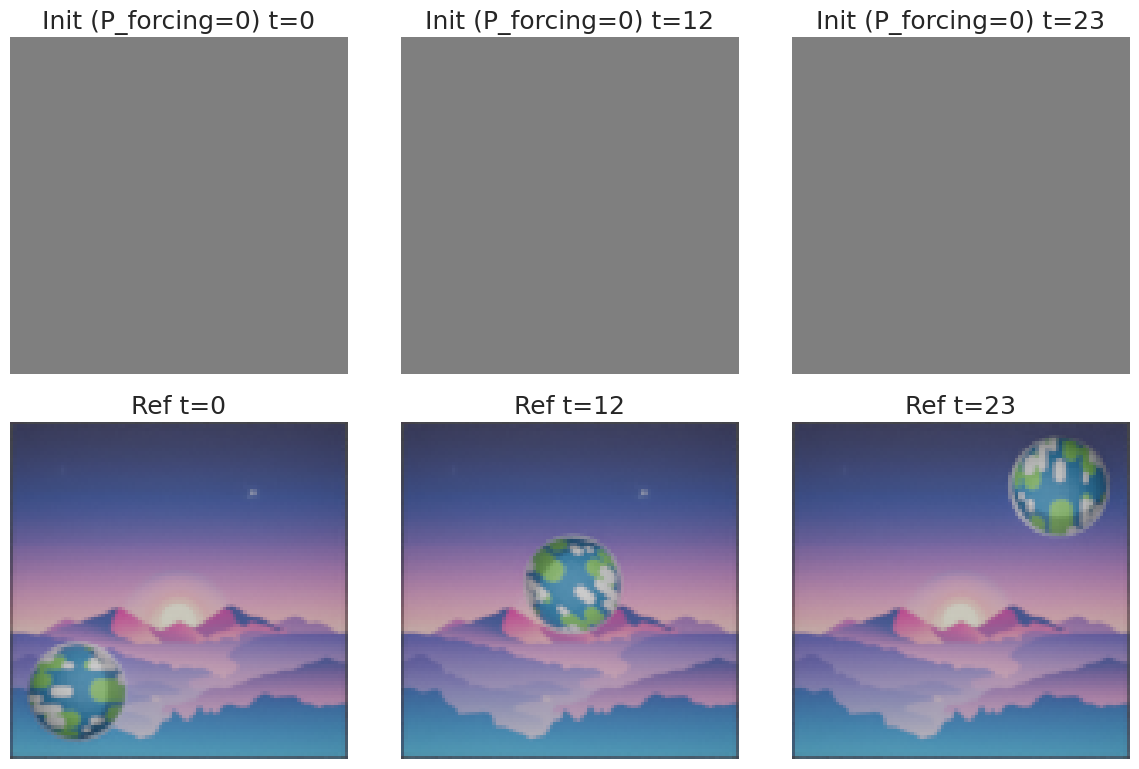


EPOCH: 1


Loss: 1.3743: 100%|██████████| 300/300 [00:36<00:00,  8.22it/s]


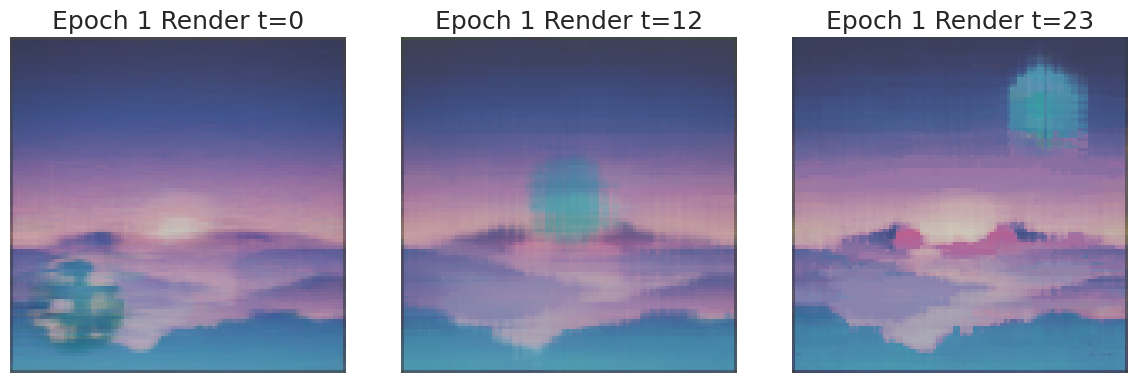


EPOCH: 2


Loss: 1.0035: 100%|██████████| 300/300 [00:35<00:00,  8.56it/s]


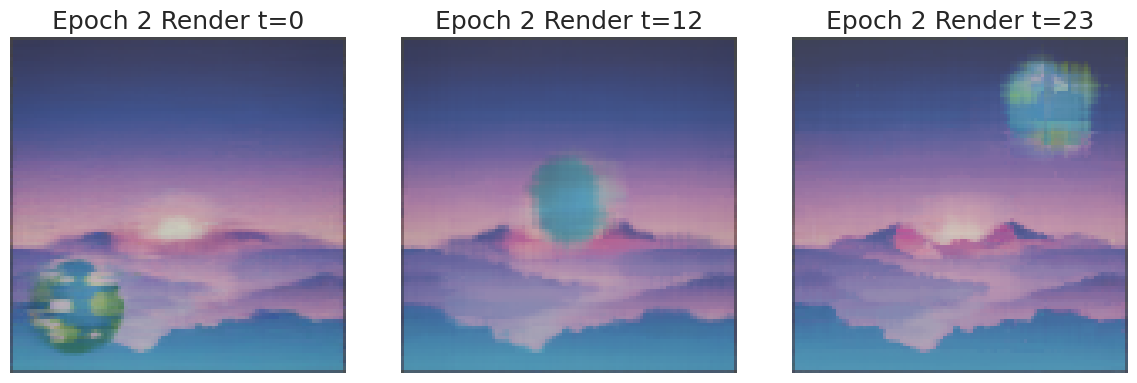


EPOCH: 3


Loss: 0.8882: 100%|██████████| 300/300 [00:35<00:00,  8.55it/s]


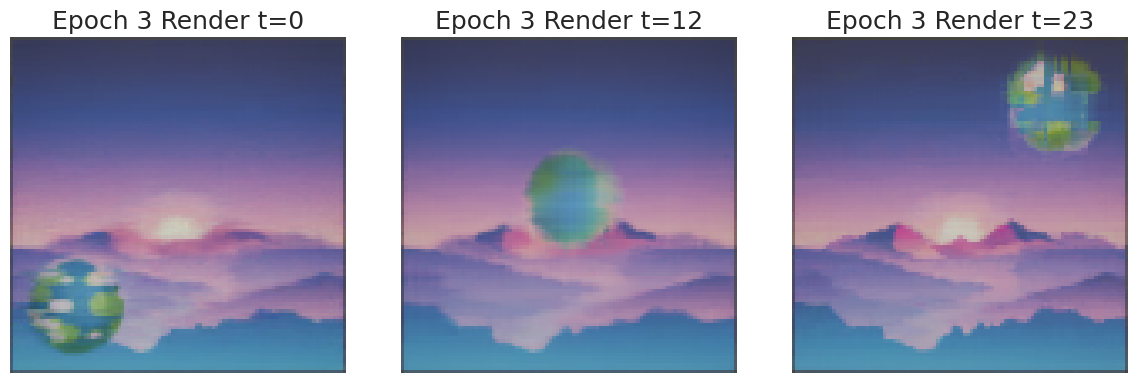


EPOCH: 4


Loss: 0.8185: 100%|██████████| 300/300 [00:35<00:00,  8.55it/s]


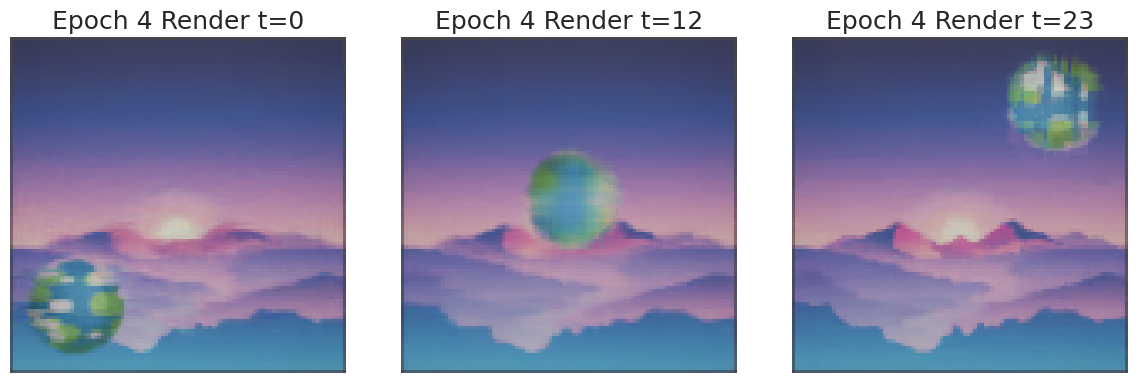


EPOCH: 5


Loss: 0.7854: 100%|██████████| 300/300 [00:35<00:00,  8.57it/s]


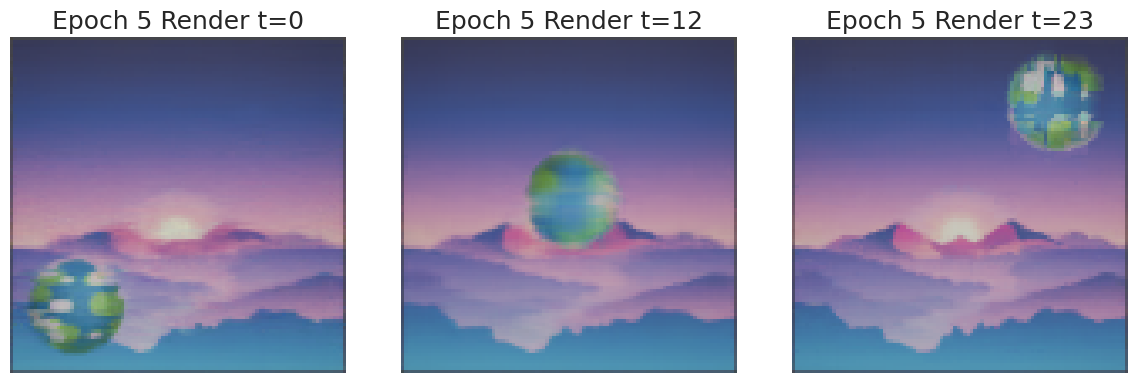


Wall time for WARP training in h:m:s: 00:02:57


In [ ]:
key, subkey = jax.random.split(key)
model = WARP(ROOT_WIDTH, ROOT_DEPTH, NUM_FOURIER_FREQS, (H, W, C), subkey)
A_init = model.A.copy()

scheduler = optax.exponential_decay(LEARNING_RATE, transition_steps=NB_ITER_PER_EPOCH*NB_EPOCHS, decay_rate=0.1)
optimizer = optax.adam(scheduler)
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))

@eqx.filter_jit
def train_step(model, opt_state, key, ref_video, coords_grid, p_forcing):
    # def loss_fn(m):
    #     pred_video = m.get_thetas_and_preds(ref_video, p_forcing, key, coords_grid)
    #     return jnp.mean(jnp.abs(pred_video - ref_video))  # L1 MAE Loss on full video

        # ## Randlomly select nb_loss_frames frames for loss computation
        # frame_indices = jax.random.choice(key, pred_video.shape[0], (NB_LOSS_FRAMES,), replace=False)
        # pred_selected = pred_video[frame_indices]
        # ref_selected = ref_video[frame_indices]
        # return jnp.mean((pred_selected - ref_selected)**2)

        # ## Randomly select pixels for loss computation
        # h_indices = jax.random.choice(key, pred_video.shape[1], (NB_LOSS_PIXELS,), replace=True)
        # w_indices = jax.random.choice(key, pred_video.shape[2], (NB_LOSS_PIXELS,), replace=True)
        # pred_selected = pred_video[:, h_indices, w_indices]
        # ref_selected = ref_video[:, h_indices, w_indices]
        # return jnp.mean((pred_selected - ref_selected)**2)

    def loss_fn(m):
            pred_video = m.get_thetas_and_preds(ref_video, p_forcing, key, coords_grid)
            
            # --- CRITICAL FIX: Use the full video loss ---
            loss_full = jnp.mean(jnp.abs(pred_video - ref_video))
            
            # Add a 2x loss boost explicitly for frame 0 to force theta_0 to wake up quickly
            loss_t0 = jnp.mean(jnp.abs(pred_video[0] - ref_video[0]))
            
            return loss_full + 100.0 * loss_t0

    loss_val, grads = eqx.filter_value_and_grad(loss_fn)(model)
    updates, opt_state = optimizer.update(grads, opt_state, eqx.filter(model, eqx.is_inexact_array))
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_val

# Initial Render Plot (Autoregressive, P=0)
print("Rendering Initial Video...")
init_video = model.get_thetas_and_preds(ref_video, p_forcing=0.0, key=key, coords_grid=coords_grid)
plot_pred_ref_videos(init_video, ref_video, title="Init (P_forcing=0)")

all_losses = []
start_time = time.time()

for epoch in range(NB_EPOCHS):
    print(f"\nEPOCH: {epoch+1}")
    epoch_losses = []
    
    pbar = tqdm(range(NB_ITER_PER_EPOCH))
    for i in pbar:
        key, subkey = jax.random.split(key)
        model, opt_state, loss = train_step(model, opt_state, subkey, ref_video, coords_grid, P_FORCING)
        epoch_losses.append(loss)
        
        if i % PRINT_EVERY == 0:
            pbar.set_description(f"Loss: {loss:.4f}")
            
    all_losses.extend(epoch_losses)
    
    # Render progress at end of epoch using P_FORCING = ?
    current_video = eqx.filter_jit(model.get_thetas_and_preds)(ref_video, P_FORCING, key, coords_grid)
    plot_pred_video(current_video, title=f"Epoch {epoch+1} Render")

wall_time = time.time() - start_time
print("\nWall time for WARP training in h:m:s:", time.strftime("%H:%M:%S", time.gmtime(wall_time)))

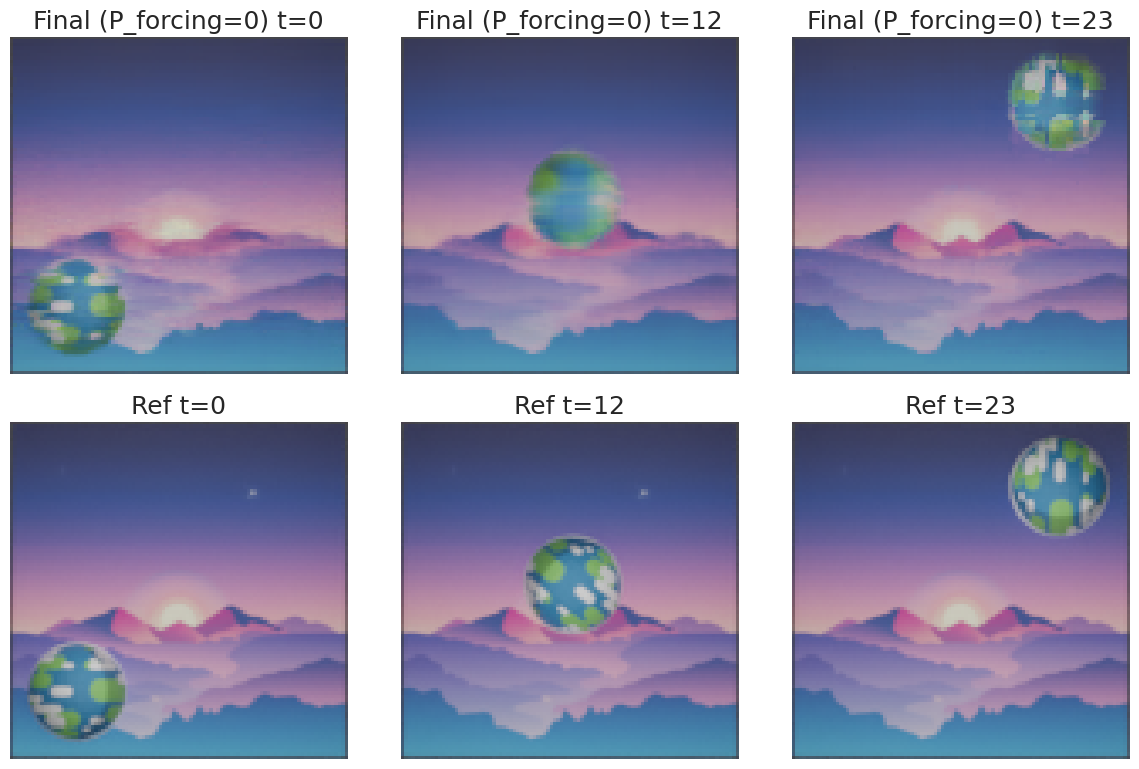

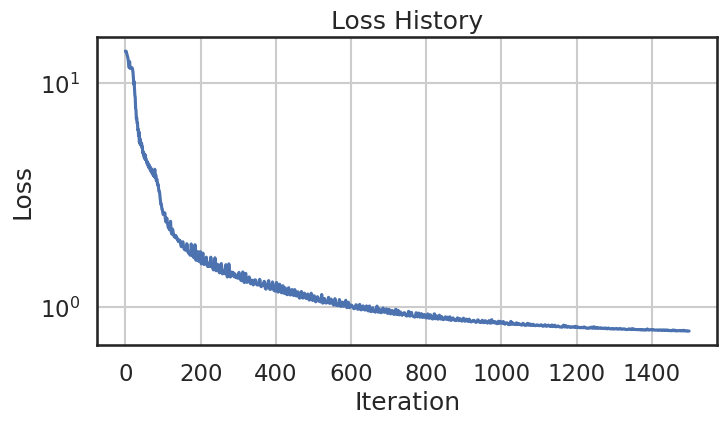

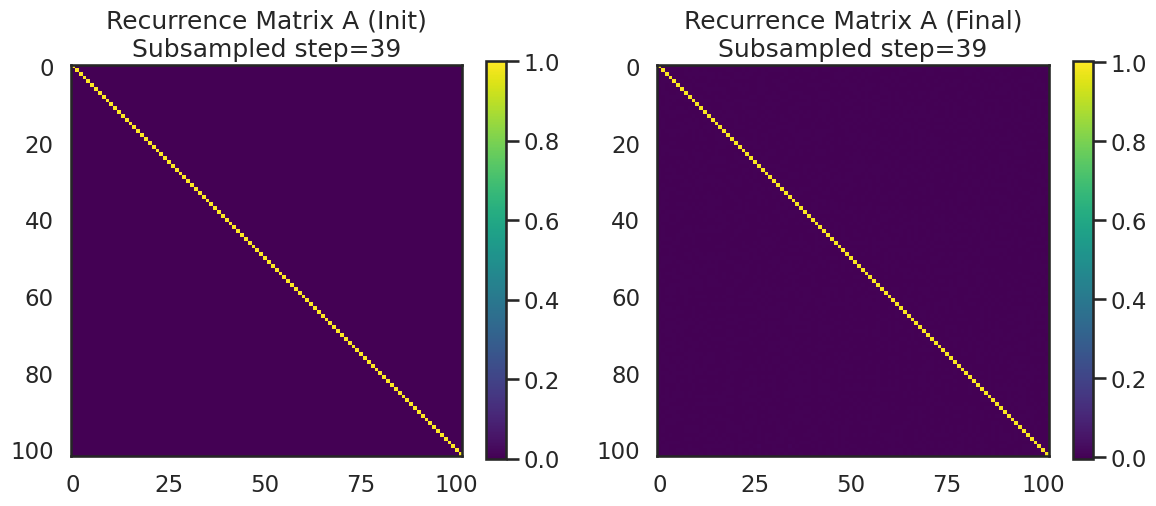

In [ ]:
# Final Video (Autoregressive, P=0)
final_video = eqx.filter_jit(model.get_thetas_and_preds)(ref_video, 0.0, key, coords_grid)
plot_pred_ref_videos(final_video, ref_video, title="Final (P_forcing=0)")

# Plot Loss
plt.figure(figsize=(8, 4))
plt.plot(all_losses)
plt.yscale('log')
plt.title("Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Plot Matrix A Before/After
A_final = model.A
subsample_step = max(1, model.d_theta // 100) 

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
im1 = axes[0].imshow(A_init[::subsample_step, ::subsample_step], cmap='viridis')
axes[0].set_title(f"Recurrence Matrix A (Init)\nSubsampled step={subsample_step}")
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(A_final[::subsample_step, ::subsample_step], cmap='viridis')
axes[1].set_title(f"Recurrence Matrix A (Final)\nSubsampled step={subsample_step}")
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

In [ ]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
from jax.flatten_util import ravel_pytree

import seaborn as sns
sns.set(style="white", context="talk")

# --- Configuration ---
SEED = 2026
key = jax.random.PRNGKey(SEED)

NB_EPOCHS = 5
NB_ITER_PER_EPOCH = 300
PRINT_EVERY = 10
LEARNING_RATE = 1e-4
# NB_LOSS_FRAMES = 2
NB_LOSS_PIXELS = 50
P_FORCING = 0.05
REC_FEAT_DIM = 1024

ROOT_WIDTH = 32
ROOT_DEPTH = 3
NUM_FOURIER_FREQS = 12

In [ ]:
def sbimshow(img, title="", ax=None):
    img = np.clip(img, 0.0, 1.0)
    if ax is None:
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    else:
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')

def plot_pred_ref_videos(video, ref_video, title="Render"):
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))
    t_mid = len(video) // 2
    t_end = len(video) - 1
    # t_mid = 1
    # t_end = 2
    
    sbimshow(video[0], title=f"{title} t=0", ax=ax[0, 0])
    sbimshow(video[t_mid], title=f"{title} t={t_mid}", ax=ax[0, 1])
    sbimshow(video[t_end], title=f"{title} t={t_end}", ax=ax[0, 2])

    sbimshow(ref_video[0], title="Ref t=0", ax=ax[1, 0])
    sbimshow(ref_video[t_mid], title=f"Ref t={t_mid}", ax=ax[1, 1])
    sbimshow(ref_video[t_end], title=f"Ref t={t_end}", ax=ax[1, 2])
    plt.tight_layout()
    plt.show()

def plot_pred_video(video, title="Render"):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    t_mid = len(video) // 2
    t_end = len(video) - 1
    
    sbimshow(video[0], title=f"{title} t=0", ax=ax[0])
    sbimshow(video[t_mid], title=f"{title} t={t_mid}", ax=ax[1])
    sbimshow(video[t_end], title=f"{title} t={t_end}", ax=ax[2])
    plt.tight_layout()
    plt.show()

# --- Data Loading ---
print("Loading Earth frames...")
ref_video = []
try:
    for i in range(1, 25):
        file_number = str(i).zfill(4)
        frame = plt.imread(f'earth_frames/{file_number}.png')[..., :3] / 1.
        ref_video.append(frame)
    ref_video = jnp.stack(ref_video, axis=0)
except FileNotFoundError:
    print("earth_frames folder not found. Generating dummy sequence for testing...")
    ref_video = jax.random.uniform(key, (24, 64, 64, 3))

nb_frames, H, W, C = ref_video.shape
print(f"Video shape: {ref_video.shape}")

# Precompute Normalized Coordinates
y_coords = jnp.linspace(-1, 1, H)
x_coords = jnp.linspace(-1, 1, W)
X_grid, Y_grid = jnp.meshgrid(x_coords, y_coords)
coords_grid = jnp.stack([X_grid, Y_grid], axis=-1)  # [H, W, 2]

Loading Earth frames...
Video shape: (24, 100, 100, 3)


In [ ]:
def fourier_encode(x, num_freqs):
    freqs = 2.0 ** jnp.arange(num_freqs)
    angles = x[..., None] * freqs[None, None, :] * jnp.pi
    angles = angles.reshape(*x.shape[:-1], -1)
    return jnp.concatenate([x, jnp.sin(angles), jnp.cos(angles)], axis=-1)

    # return x

class RootMLP(eqx.Module):
    layers: list

    def __init__(self, in_size, out_size, width, depth, key):
        keys = jax.random.split(key, depth + 1)
        self.layers = [eqx.nn.Linear(in_size, width, key=keys[0])]
        for i in range(depth - 1):
            self.layers.append(eqx.nn.Linear(width, width, key=keys[i+1]))
        self.layers.append(eqx.nn.Linear(width, out_size, key=keys[-1]))

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.relu(layer(x))
        return self.layers[-1](x)

# class CNNEncoder(eqx.Module):
#     """
#     A simple CNN that downsamples spatial dimensions and applies a dense layer.
#     Used for both the hypernetwork \phi and the recurrence feature extractor \psi.
#     """
#     layers: list
    
#     def __init__(self, in_channels, out_dim, spatial_shape, key):
#         H, W = spatial_shape
#         keys = jax.random.split(key, 4)
        
#         # 3 downsampling stages
#         conv_layers = [
#             eqx.nn.Conv2d(in_channels, 16, kernel_size=3, stride=2, padding=1, key=keys[0]),
#             eqx.nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, key=keys[1]),
#             eqx.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, key=keys[2]),
#         ]
        
#         # --- DYNAMIC SHAPE CALCULATION ---
#         # Pass a dummy tensor to automatically calculate the exact flattened dimension
#         dummy_x = jnp.zeros((in_channels, H, W))
#         for layer in conv_layers:
#             dummy_x = layer(dummy_x)
            
#         flat_dim = dummy_x.reshape(-1).shape[0]
        
#         # Assemble the final layers list with the correctly sized Linear layer
#         self.layers = conv_layers + [
#             eqx.nn.Linear(flat_dim, out_dim, key=keys[3])
#         ]
        
#     def __call__(self, x):
#         # Equinox Conv2d expects inputs in (Channels, Height, Width) format
#         for layer in self.layers[:-1]:
#             x = layer(x)
#             x = jax.nn.relu(x)
        
#         x = x.reshape(-1)  # Flatten
#         x = self.layers[-1](x)  # Dense matrix at the end
#         return x


class CNNEncoder(eqx.Module):
    """
    A simple CNN that downsamples spatial dimensions and applies a dense layer.
    Used for both the hypernetwork \phi and the recurrence feature extractor \psi.
    """
    layers: list
    
    def __init__(self, in_channels, out_dim, spatial_shape, key, hidden_width=16, depth=3):
        H, W = spatial_shape
        keys = jax.random.split(key, depth + 1)
        
        # Dynamically build the convolutional layers based on depth
        conv_layers = []
        current_in_channels = in_channels
        current_out_channels = hidden_width
        
        for i in range(depth):
            conv_layers.append(
                eqx.nn.Conv2d(
                    current_in_channels, 
                    current_out_channels, 
                    kernel_size=3, 
                    stride=2, 
                    padding=1, 
                    key=keys[i]
                )
            )
            # Double the feature maps as spatial dimensions halve
            current_in_channels = current_out_channels
            current_out_channels *= 2
            
        # --- DYNAMIC SHAPE CALCULATION ---
        # Pass a dummy tensor to automatically calculate the exact flattened dimension
        dummy_x = jnp.zeros((in_channels, H, W))
        for layer in conv_layers:
            dummy_x = layer(dummy_x)
            
        flat_dim = dummy_x.reshape(-1).shape[0]
        
        # Assemble the final layers list with the correctly sized Linear layer
        self.layers = conv_layers + [
            eqx.nn.Linear(flat_dim, out_dim, key=keys[depth])
        ]
        
    def __call__(self, x):
        # Equinox Conv2d expects inputs in (Channels, Height, Width) format
        for layer in self.layers[:-1]:
            x = layer(x)
            x = jax.nn.relu(x)
        
        x = x.reshape(-1)  # Flatten
        x = self.layers[-1](x)  # Dense matrix at the end
        return x


class DownsamplingLayer(eqx.Module):
    layer: eqx.Module
    def __init__(self, in_channels, out_channels, kernel_size=2, stride=2, *, key):
        self.layer = eqx.nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding="SAME", key=key)
    
    def __call__(self, x):
        return self.layer(x)

class UpsamplingLayer(eqx.Module):
    layer: eqx.Module

    def __init__(self, in_channels, out_channels, kernel_size=2, stride=2, *, key):
        self.layer = eqx.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding="SAME", key=key)

    def __call__(self, x):
        return self.layer(x)

class DoubleConv(eqx.Module):
    layer_1: eqx.Module
    layer_2: eqx.Module
    activation: callable
    norm_layer: eqx.Module
    dropout_rate: float

    def __init__(self, in_channels, out_channels, kernel_size=3, activation=jax.nn.relu, batch_norm=False, dropout_rate=0., *, key):
        k1, k2 = jax.random.split(key, 2)

        self.layer_1 = eqx.nn.Conv2d(in_channels, out_channels, kernel_size, padding='SAME', key=k1)
        self.layer_2 = eqx.nn.Conv2d(out_channels, out_channels, kernel_size, padding='SAME', key=k2)
        self.activation = activation
        
        if batch_norm:
            self.norm_layer = eqx.nn.BatchNorm(input_size=out_channels, axis_name=None)
        else:
            self.norm_layer = None
            
        self.dropout_rate = dropout_rate

    def __call__(self, x):
        x = self.layer_1(x)
        x = self.activation(x)
        x = self.layer_2(x)
        x = self.activation(x)
        if self.norm_layer:
            x = self.norm_layer(x)
        if self.dropout_rate > 0.:
            x = eqx.nn.Dropout(self.dropout_rate)(x)
        return x

class VNetEncoder(eqx.Module):
    input_shape: tuple
    out_dim: int
    levels: int
    depth: int
    kernel_size: int
    activation: callable
    batch_norm: bool
    dropout_rate: float

    ## Learnable params
    left_doubleconvs: dict
    right_doubleconvs: dict
    downsamplings: dict
    upsamplings: dict
    final_conv: eqx.Module
    final_linear: eqx.nn.Linear

    def __init__(self, input_shape, out_dim, levels=4, depth=16, kernel_size=3, activation=jax.nn.relu, batch_norm=False, dropout_rate=0., *, key):
        l_key, r_key, d_key, u_key, f_key, lin_key = jax.random.split(key, 6)

        self.input_shape = input_shape      ## (C, H, W)
        self.out_dim = out_dim              ## Flat output size
        self.levels = levels
        self.depth = depth                  ## Number of filters in the first layer
        self.kernel_size = kernel_size
        self.activation = activation
        self.batch_norm = batch_norm
        self.dropout_rate = dropout_rate

        self.left_doubleconvs = {}
        self.right_doubleconvs = {}
        self.downsamplings = {}
        self.upsamplings = {}
        
        # Maintains depth channels for the final spatial projection
        self.final_conv = eqx.nn.Conv2d(depth, depth, 1, padding="SAME", key=f_key)

        d_keys = jax.random.split(d_key, levels-1)
        l_keys = jax.random.split(l_key, levels)

        self.left_doubleconvs[0] = DoubleConv(input_shape[0], depth, kernel_size, activation, batch_norm, dropout_rate, key=l_keys[0])
        for i in range(1, levels):
            self.downsamplings[i] = DownsamplingLayer(self.depth*2**(i-1), self.depth*2**(i), key=d_keys[i-1])
            self.left_doubleconvs[i] = DoubleConv(self.depth*2**(i), self.depth*2**(i), kernel_size, activation, batch_norm, dropout_rate, key=l_keys[i])

        u_keys = jax.random.split(u_key, levels-1)
        r_keys = jax.random.split(r_key, levels-1)

        for i in range(self.levels-2, -1, -1):
            self.upsamplings[i] = UpsamplingLayer(self.depth*2**(i+1), self.depth*2**i, key=u_keys[i])
            self.right_doubleconvs[i] = DoubleConv(self.depth*2**(i), self.depth*2**i, kernel_size, activation, batch_norm, dropout_rate, key=r_keys[i])

        # --- DYNAMIC SHAPE CALCULATION ---
        dummy_x = jnp.zeros(input_shape)
        dummy_out = self._forward_features(dummy_x)
        flat_dim = dummy_out.reshape(-1).shape[0]

        # Final dense mapping to your requested 1D state
        self.final_linear = eqx.nn.Linear(flat_dim, out_dim, key=lin_key)

    def _forward_features(self, inputs):
        left = {}
        left[0] = self.left_doubleconvs[0](inputs)
        for i in range(1, self.levels):
            down = self.downsamplings[i](left[i-1])
            conv = self.left_doubleconvs[i](down)
            left[i] = down + conv

        central = left[self.levels-1]
        right = central

        for i in range(self.levels-2, -1,-1):
            up = self.upsamplings[i](right)
            add = left[i] + up
            conv = self.right_doubleconvs[i](add)
            right = up + conv

        return self.activation(self.final_conv(right))

    def __call__(self, inputs):
        # 1. Extract VNet features
        features = self._forward_features(inputs)
        # 2. Flatten
        flat_features = features.reshape(-1)
        # 3. Project to out_dim
        return self.final_linear(flat_features)

class WARP(eqx.Module):
    A: jax.Array
    B: jax.Array
    hypernet_phi: CNNEncoder
    psi_net: CNNEncoder
    
    root_structure: RootMLP = eqx.field(static=True)
    unravel_fn: callable = eqx.field(static=True)
    d_theta: int = eqx.field(static=True)
    num_freqs: int = eqx.field(static=True)
    frame_shape: tuple = eqx.field(static=True)

    def __init__(self, root_width, root_depth, num_freqs, frame_shape, key):
        k_root, k_A, k_B, k_phi, k_psi = jax.random.split(key, 5)
        self.num_freqs = num_freqs
        self.frame_shape = frame_shape
        H, W, C = frame_shape
        
        # Spatial input only (no tau)
        coord_dim = 2 + 2 * 2 * num_freqs 
        template_root = RootMLP(coord_dim, 7, root_width, root_depth, k_root)

        flat_params, self.unravel_fn = ravel_pytree(template_root)
        self.d_theta = flat_params.shape[0]
        self.root_structure = template_root
        
        # 1. Hypernetwork \phi: Maps initial frame (C channels) -> theta_0
        # self.hypernet_phi = CNNEncoder(in_channels=C, out_dim=self.d_theta, spatial_shape=(H, W), key=k_phi)
        # self.hypernet_phi = eqx.nn.Linear(H*W*C, self.d_theta, key=k_phi)
        # self.hypernet_phi = VNetEncoder(
        #             input_shape=(C, H, W), 
        #             out_dim=self.d_theta, 
        #             levels=2, 
        #             depth=8, 
        #             batch_norm=False, 
        #             key=k_phi
        #         )
        self.hypernet_phi = CNNEncoder(in_channels=C, out_dim=self.d_theta, spatial_shape=(H, W), key=k_phi, hidden_width=32, depth=2)

        # 2. CNN \psi: Extracts features from [frame_t, prev_frame_selected]
        # We concatenate them along channels, so in_channels = 2 * C
        d_feat = REC_FEAT_DIM  # Dimension of the feature vector extracted by \psi
        self.psi_net = CNNEncoder(in_channels=1 * C, out_dim=d_feat, spatial_shape=(H, W), key=k_psi, hidden_width=16, depth=3)
        
        # 3. Recurrence Matrices
        self.A = jnp.eye(self.d_theta)
        # B is now significantly reduced: (d_theta, d_feat) instead of (d_theta, H*W*C)
        self.B = jnp.zeros((self.d_theta, d_feat))

        print(f"Model Initialized:")
        print(f"  d_theta (State Size): {self.d_theta}")
        print(f"  Matrix A Shape: {self.A.shape}")
        print(f"  Matrix B Shape: {self.B.shape}")

    def render_pixels(self, thetas, coords):
        def render_pt(theta, coord):
            root = self.unravel_fn(theta)
            encoded_coord = fourier_encode(coord, self.num_freqs)
            out = root(encoded_coord)
            
            rgb_fg = jax.nn.sigmoid(out[0:3])
            rgb_bg = jax.nn.sigmoid(out[3:6])
            alpha  = jax.nn.sigmoid(out[6:7])
            return alpha * rgb_fg + (1.0 - alpha) * rgb_bg

        return jax.vmap(render_pt)(thetas, coords)

    def get_thetas_and_preds(self, ref_video, p_forcing, key, coords_grid):
        H, W, C = self.frame_shape
        flat_coords = coords_grid.reshape(-1, 2)
        
        # --- NEW: Get initial theta_0 from Hypernetwork \phi ---
        init_gt_frame = ref_video[0]
        # Equinox convolutions expect (C, H, W)
        init_gt_frame_chw = jnp.transpose(init_gt_frame, (2, 0, 1)) 
        # init_gt_frame_chw = init_gt_frame.reshape(-1)       ## TODO
        theta_0 = self.hypernet_phi(init_gt_frame_chw)
        
        def scan_step(state, gt_curr_frame):
            theta, prev_frame_selected, k = state
            k, subk = jax.random.split(k)
            
            # 1. Render current frame
            thetas_frame = jnp.tile(theta, (H*W, 1))
            pred_flat = self.render_pixels(thetas_frame, flat_coords)
            pred_frame = pred_flat.reshape(H, W, C)
            
            # 2. Bernoulli Teacher Forcing decision
            use_gt = jax.random.bernoulli(subk, p_forcing)
            frame_t = jnp.where(use_gt, gt_curr_frame, pred_frame)
            
            # # --- NEW: Compute dense features via CNN \psi ---
            # # Concatenate current frame and prev frame (H, W, 2*C)
            # concat_frames = jnp.concatenate([frame_t, prev_frame_selected], axis=-1)
            # # Transpose to (2*C, H, W) for Equinox Conv2D
            # concat_frames_chw = jnp.transpose(concat_frames, (2, 0, 1))
            
            # # Pass through \psi
            # dx_feat = self.psi_net(concat_frames_chw)

            # Variance scaling for stable gradients in the recurrence
            # dx_feat = dx_feat / jnp.sqrt(dx_feat.size)

            frame_t_feats = self.psi_net(jnp.transpose(frame_t, (2, 0, 1)))
            prev_frame_selected_feats = self.psi_net(jnp.transpose(prev_frame_selected, (2, 0, 1)))

            dx_feat = (frame_t_feats - prev_frame_selected_feats) / jnp.sqrt(frame_t_feats.size)

            # 4. Weight-space Recurrence Update
            theta_next = self.A @ theta + self.B @ dx_feat
            
            new_state = (theta_next, frame_t, subk)
            return new_state, pred_frame
            
        init_frame = jnp.zeros((H, W, C))
        init_state = (theta_0, init_frame, key)
        
        # Scan over the sequence length
        _, pred_video = jax.lax.scan(scan_step, init_state, ref_video)
        return pred_video

<>:68: SyntaxWarning: invalid escape sequence '\p'
<>:68: SyntaxWarning: invalid escape sequence '\p'
<ipython-input-18-3c035a75d0b2>:68: SyntaxWarning: invalid escape sequence '\p'
  """


Model Initialized:
  d_theta (State Size): 3975
  Matrix A Shape: (3975, 3975)
  Matrix B Shape: (3975, 1024)
Rendering Initial Video...


<ipython-input-19-a421db2cf827>:3: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = WARP(ROOT_WIDTH, ROOT_DEPTH, NUM_FOURIER_FREQS, (H, W, C), subkey)


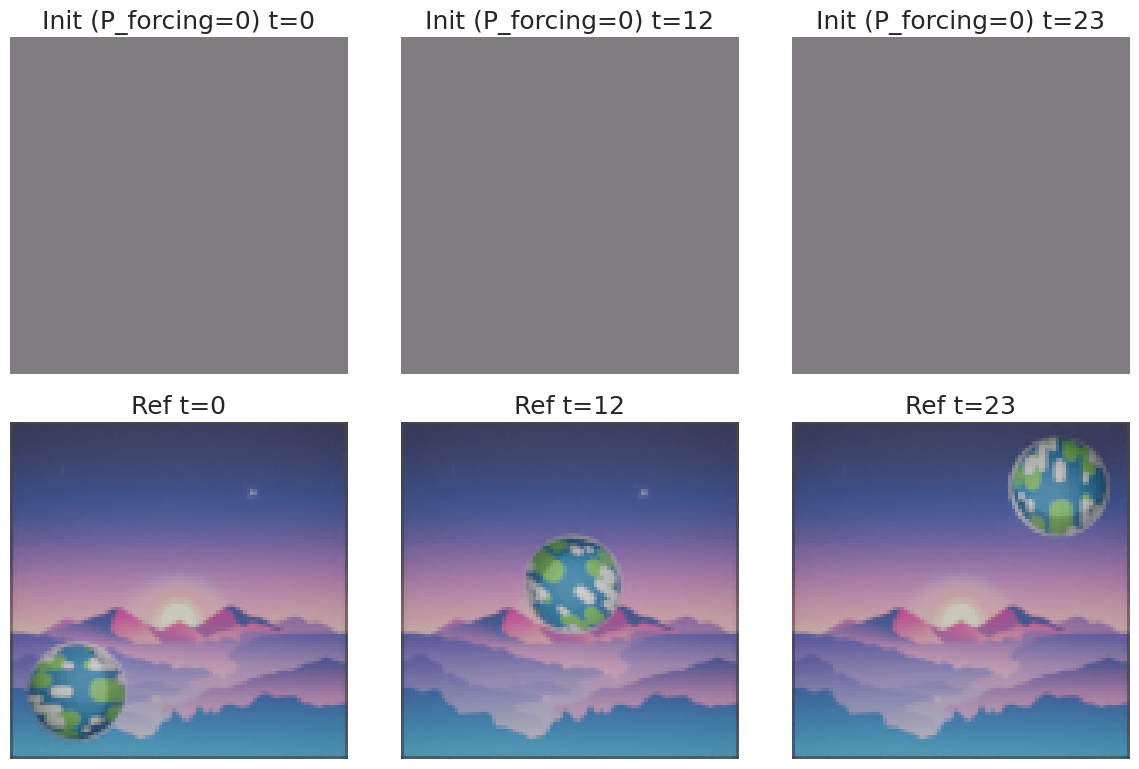


EPOCH: 1


Loss: 0.1219: 100%|██████████| 300/300 [00:40<00:00,  7.50it/s]


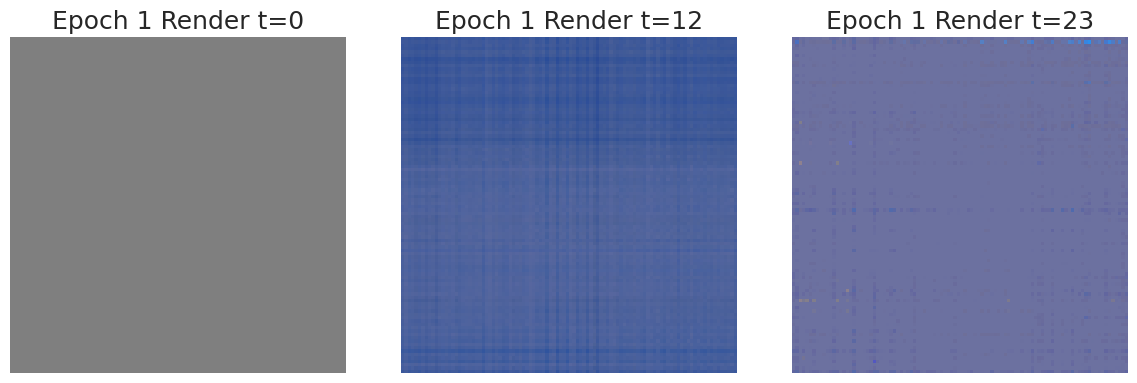


EPOCH: 2


Loss: 0.0626: 100%|██████████| 300/300 [00:38<00:00,  7.82it/s]


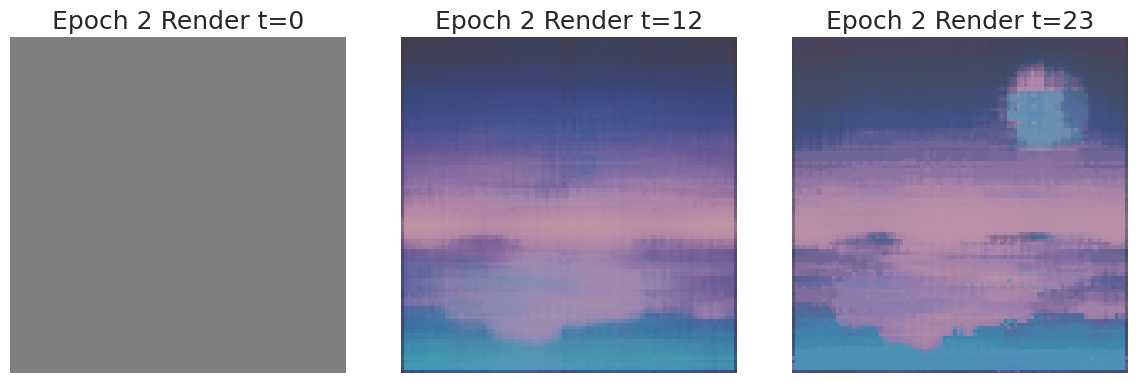


EPOCH: 3


Loss: 0.0453: 100%|██████████| 300/300 [00:38<00:00,  7.83it/s]


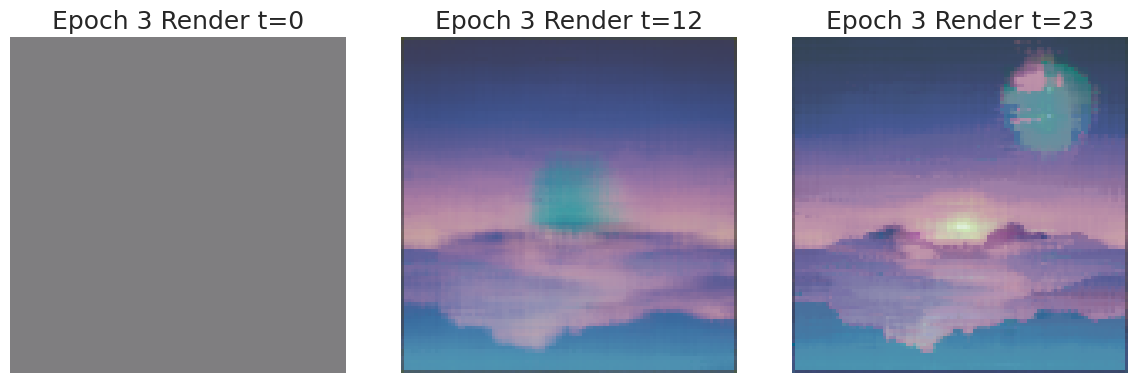


EPOCH: 4


Loss: 0.0347: 100%|██████████| 300/300 [00:38<00:00,  7.82it/s]


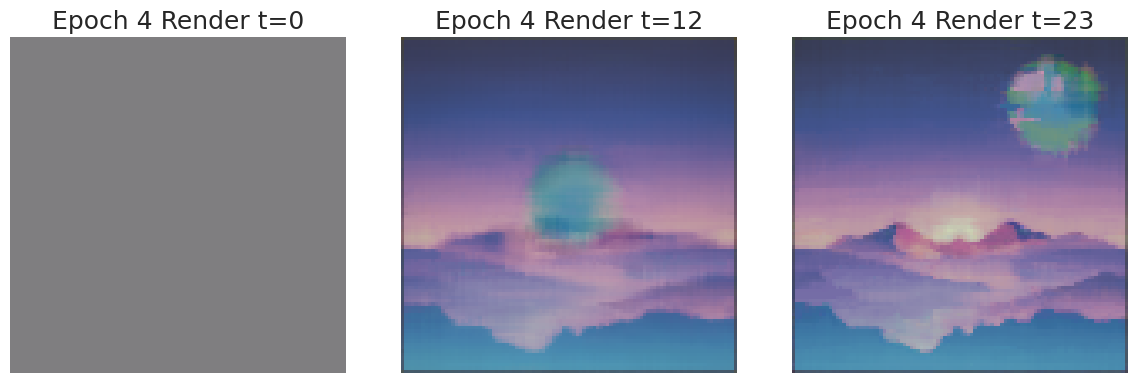


EPOCH: 5


Loss: 0.0297: 100%|██████████| 300/300 [00:38<00:00,  7.82it/s]


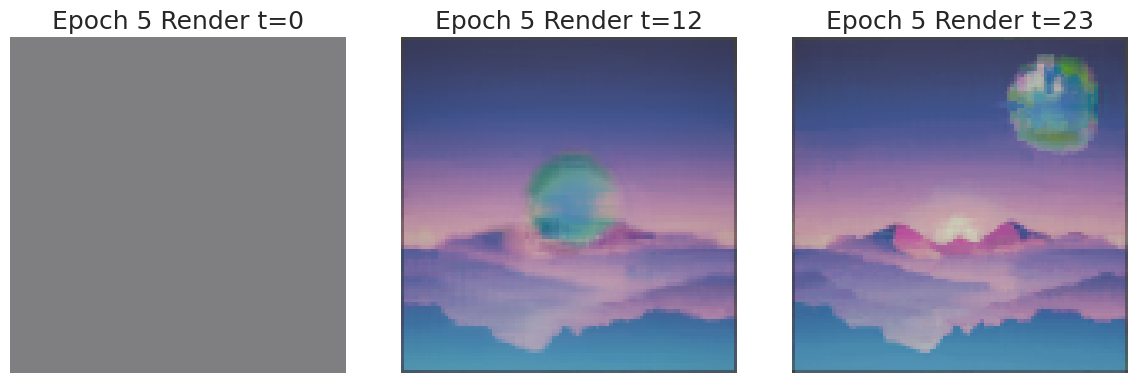


Wall time for WARP training in h:m:s: 00:03:14


In [ ]:
key, subkey = jax.random.split(key)
model = WARP(ROOT_WIDTH, ROOT_DEPTH, NUM_FOURIER_FREQS, (H, W, C), subkey)
A_init = model.A.copy()

scheduler = optax.exponential_decay(LEARNING_RATE, transition_steps=NB_ITER_PER_EPOCH*NB_EPOCHS, decay_rate=0.1)
optimizer = optax.adam(scheduler)
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))

@eqx.filter_jit
def train_step(model, opt_state, key, ref_video, coords_grid, p_forcing):
    # def loss_fn(m):
    #     pred_video = m.get_thetas_and_preds(ref_video, p_forcing, key, coords_grid)
    #     return jnp.mean(jnp.abs(pred_video - ref_video))  # L1 MAE Loss on full video

        # ## Randlomly select nb_loss_frames frames for loss computation
        # frame_indices = jax.random.choice(key, pred_video.shape[0], (NB_LOSS_FRAMES,), replace=False)
        # pred_selected = pred_video[frame_indices]
        # ref_selected = ref_video[frame_indices]
        # return jnp.mean((pred_selected - ref_selected)**2)

        # ## Randomly select pixels for loss computation
        # h_indices = jax.random.choice(key, pred_video.shape[1], (NB_LOSS_PIXELS,), replace=True)
        # w_indices = jax.random.choice(key, pred_video.shape[2], (NB_LOSS_PIXELS,), replace=True)
        # pred_selected = pred_video[:, h_indices, w_indices]
        # ref_selected = ref_video[:, h_indices, w_indices]
        # return jnp.mean((pred_selected - ref_selected)**2)

    def loss_fn(m):
            pred_video = m.get_thetas_and_preds(ref_video, p_forcing, key, coords_grid)
            
            # --- CRITICAL FIX: Use the full video loss ---
            loss_full = jnp.mean(jnp.abs(pred_video - ref_video))
            
            # Add a 2x loss boost explicitly for frame 0 to force theta_0 to wake up quickly
            loss_t0 = jnp.mean(jnp.abs(pred_video[0] - ref_video[0]))
            
            # return loss_full + 100.0 * loss_t0

            return loss_full

    loss_val, grads = eqx.filter_value_and_grad(loss_fn)(model)
    updates, opt_state = optimizer.update(grads, opt_state, eqx.filter(model, eqx.is_inexact_array))
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_val

# Initial Render Plot (Autoregressive, P=0)
print("Rendering Initial Video...")
init_video = model.get_thetas_and_preds(ref_video, p_forcing=0.0, key=key, coords_grid=coords_grid)
plot_pred_ref_videos(init_video, ref_video, title="Init (P_forcing=0)")

all_losses = []
start_time = time.time()

for epoch in range(NB_EPOCHS):
    print(f"\nEPOCH: {epoch+1}")
    epoch_losses = []
    
    pbar = tqdm(range(NB_ITER_PER_EPOCH))
    for i in pbar:
        key, subkey = jax.random.split(key)
        model, opt_state, loss = train_step(model, opt_state, subkey, ref_video, coords_grid, P_FORCING)
        epoch_losses.append(loss)
        
        if i % PRINT_EVERY == 0:
            pbar.set_description(f"Loss: {loss:.4f}")
            
    all_losses.extend(epoch_losses)
    
    # Render progress at end of epoch using P_FORCING = ?
    current_video = eqx.filter_jit(model.get_thetas_and_preds)(ref_video, P_FORCING, key, coords_grid)
    plot_pred_video(current_video, title=f"Epoch {epoch+1} Render")

wall_time = time.time() - start_time
print("\nWall time for WARP training in h:m:s:", time.strftime("%H:%M:%S", time.gmtime(wall_time)))

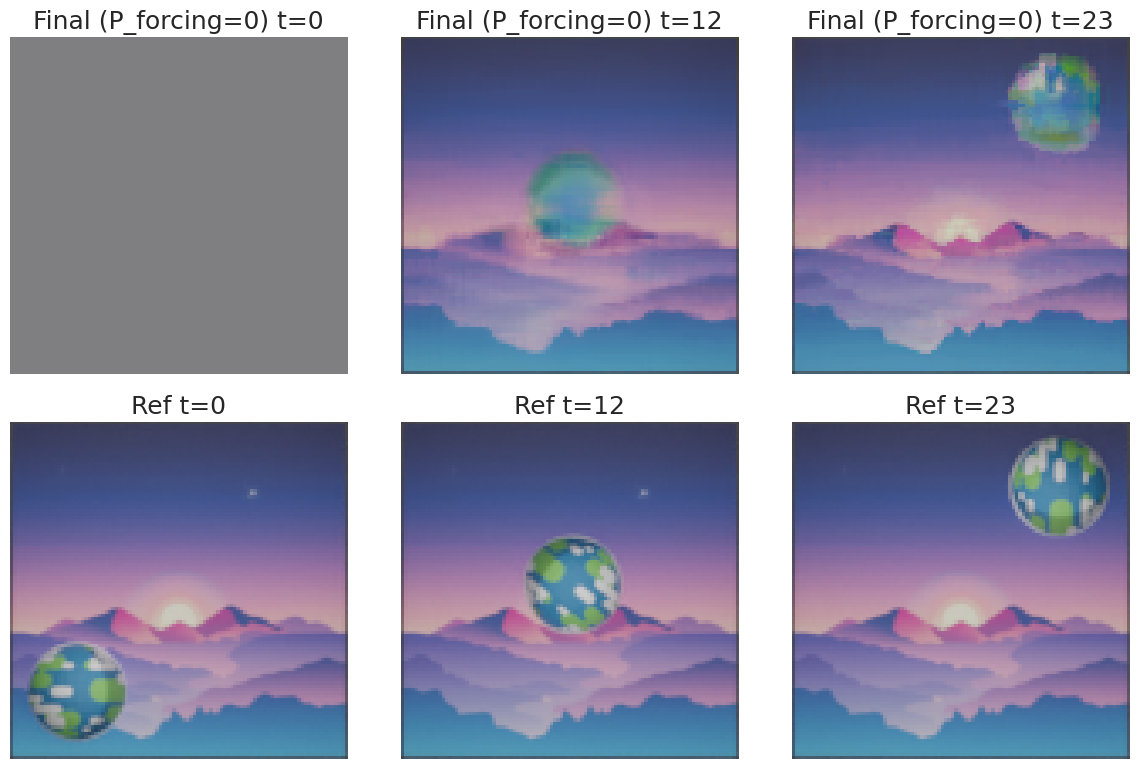

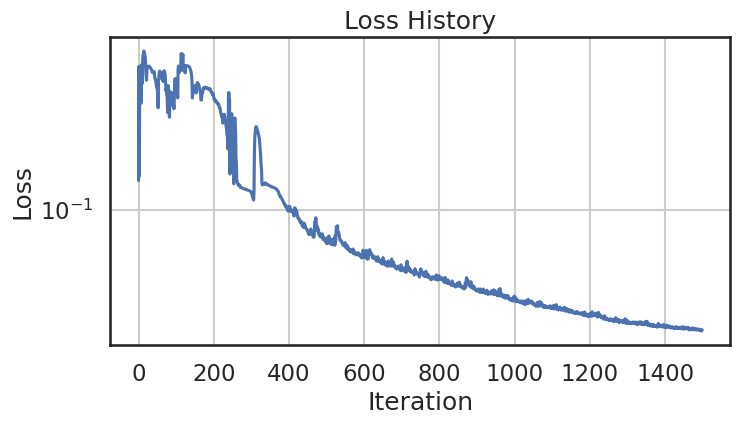

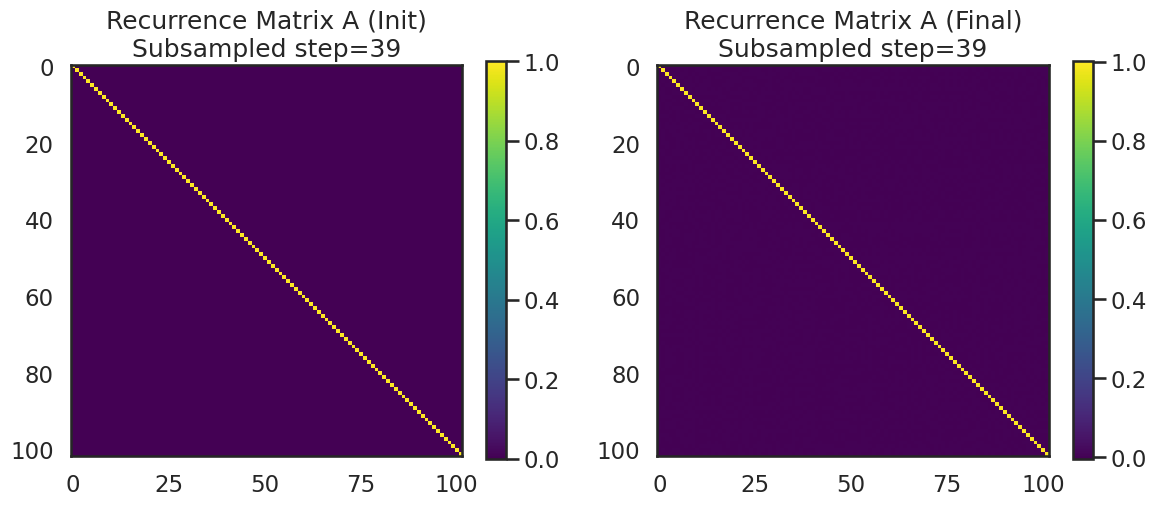

In [ ]:
# Final Video (Autoregressive, P=0)
final_video = eqx.filter_jit(model.get_thetas_and_preds)(ref_video, 0.0, key, coords_grid)
plot_pred_ref_videos(final_video, ref_video, title="Final (P_forcing=0)")

# Plot Loss
plt.figure(figsize=(8, 4))
plt.plot(all_losses)
plt.yscale('log')
plt.title("Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Plot Matrix A Before/After
A_final = model.A
subsample_step = max(1, model.d_theta // 100) 

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
im1 = axes[0].imshow(A_init[::subsample_step, ::subsample_step], cmap='viridis')
axes[0].set_title(f"Recurrence Matrix A (Init)\nSubsampled step={subsample_step}")
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(A_final[::subsample_step, ::subsample_step], cmap='viridis')
axes[1].set_title(f"Recurrence Matrix A (Final)\nSubsampled step={subsample_step}")
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

In [ ]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
from jax.flatten_util import ravel_pytree

import seaborn as sns
sns.set(style="white", context="talk")

# --- Configuration ---
SEED = 2026
key = jax.random.PRNGKey(SEED)

NB_EPOCHS = 5
NB_ITER_PER_EPOCH = 300
PRINT_EVERY = 10
LEARNING_RATE = 1e-4
# NB_LOSS_FRAMES = 2
NB_LOSS_PIXELS = 50
P_FORCING = 0.05
REC_FEAT_DIM = 1024

ROOT_WIDTH = 32
ROOT_DEPTH = 3
NUM_FOURIER_FREQS = 12

In [ ]:
def sbimshow(img, title="", ax=None):
    img = np.clip(img, 0.0, 1.0)
    if ax is None:
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    else:
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')

def plot_pred_ref_videos(video, ref_video, title="Render"):
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))
    t_mid = len(video) // 2
    t_end = len(video) - 1
    # t_mid = 1
    # t_end = 2
    
    sbimshow(video[0], title=f"{title} t=0", ax=ax[0, 0])
    sbimshow(video[t_mid], title=f"{title} t={t_mid}", ax=ax[0, 1])
    sbimshow(video[t_end], title=f"{title} t={t_end}", ax=ax[0, 2])

    sbimshow(ref_video[0], title="Ref t=0", ax=ax[1, 0])
    sbimshow(ref_video[t_mid], title=f"Ref t={t_mid}", ax=ax[1, 1])
    sbimshow(ref_video[t_end], title=f"Ref t={t_end}", ax=ax[1, 2])
    plt.tight_layout()
    plt.show()

def plot_pred_video(video, title="Render"):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    t_mid = len(video) // 2
    t_end = len(video) - 1
    
    sbimshow(video[0], title=f"{title} t=0", ax=ax[0])
    sbimshow(video[t_mid], title=f"{title} t={t_mid}", ax=ax[1])
    sbimshow(video[t_end], title=f"{title} t={t_end}", ax=ax[2])
    plt.tight_layout()
    plt.show()

# --- Data Loading ---
print("Loading Earth frames...")
ref_video = []
try:
    for i in range(1, 25):
        file_number = str(i).zfill(4)
        frame = plt.imread(f'earth_frames/{file_number}.png')[..., :3] / 1.
        ref_video.append(frame)
    ref_video = jnp.stack(ref_video, axis=0)
except FileNotFoundError:
    print("earth_frames folder not found. Generating dummy sequence for testing...")
    ref_video = jax.random.uniform(key, (24, 64, 64, 3))

nb_frames, H, W, C = ref_video.shape
print(f"Video shape: {ref_video.shape}")

# Precompute Normalized Coordinates
y_coords = jnp.linspace(-1, 1, H)
x_coords = jnp.linspace(-1, 1, W)
X_grid, Y_grid = jnp.meshgrid(x_coords, y_coords)
coords_grid = jnp.stack([X_grid, Y_grid], axis=-1)  # [H, W, 2]

Loading Earth frames...
Video shape: (24, 100, 100, 3)


In [ ]:
def fourier_encode(x, num_freqs):
    freqs = 2.0 ** jnp.arange(num_freqs)
    angles = x[..., None] * freqs[None, None, :] * jnp.pi
    angles = angles.reshape(*x.shape[:-1], -1)
    return jnp.concatenate([x, jnp.sin(angles), jnp.cos(angles)], axis=-1)

    # return x

class RootMLP(eqx.Module):
    layers: list

    def __init__(self, in_size, out_size, width, depth, key):
        keys = jax.random.split(key, depth + 1)
        self.layers = [eqx.nn.Linear(in_size, width, key=keys[0])]
        for i in range(depth - 1):
            self.layers.append(eqx.nn.Linear(width, width, key=keys[i+1]))
        self.layers.append(eqx.nn.Linear(width, out_size, key=keys[-1]))

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.relu(layer(x))
        return self.layers[-1](x)

# class CNNEncoder(eqx.Module):
#     """
#     A simple CNN that downsamples spatial dimensions and applies a dense layer.
#     Used for both the hypernetwork \phi and the recurrence feature extractor \psi.
#     """
#     layers: list
    
#     def __init__(self, in_channels, out_dim, spatial_shape, key):
#         H, W = spatial_shape
#         keys = jax.random.split(key, 4)
        
#         # 3 downsampling stages
#         conv_layers = [
#             eqx.nn.Conv2d(in_channels, 16, kernel_size=3, stride=2, padding=1, key=keys[0]),
#             eqx.nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, key=keys[1]),
#             eqx.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, key=keys[2]),
#         ]
        
#         # --- DYNAMIC SHAPE CALCULATION ---
#         # Pass a dummy tensor to automatically calculate the exact flattened dimension
#         dummy_x = jnp.zeros((in_channels, H, W))
#         for layer in conv_layers:
#             dummy_x = layer(dummy_x)
            
#         flat_dim = dummy_x.reshape(-1).shape[0]
        
#         # Assemble the final layers list with the correctly sized Linear layer
#         self.layers = conv_layers + [
#             eqx.nn.Linear(flat_dim, out_dim, key=keys[3])
#         ]
        
#     def __call__(self, x):
#         # Equinox Conv2d expects inputs in (Channels, Height, Width) format
#         for layer in self.layers[:-1]:
#             x = layer(x)
#             x = jax.nn.relu(x)
        
#         x = x.reshape(-1)  # Flatten
#         x = self.layers[-1](x)  # Dense matrix at the end
#         return x


class CNNEncoder(eqx.Module):
    """
    A simple CNN that downsamples spatial dimensions and applies a dense layer.
    Used for both the hypernetwork \phi and the recurrence feature extractor \psi.
    """
    layers: list
    
    def __init__(self, in_channels, out_dim, spatial_shape, key, hidden_width=16, depth=3):
        H, W = spatial_shape
        keys = jax.random.split(key, depth + 1)
        
        # Dynamically build the convolutional layers based on depth
        conv_layers = []
        current_in_channels = in_channels
        current_out_channels = hidden_width
        
        for i in range(depth):
            conv_layers.append(
                eqx.nn.Conv2d(
                    current_in_channels, 
                    current_out_channels, 
                    kernel_size=3, 
                    stride=2, 
                    padding=1, 
                    key=keys[i]
                )
            )
            # Double the feature maps as spatial dimensions halve
            current_in_channels = current_out_channels
            current_out_channels *= 2
            
        # --- DYNAMIC SHAPE CALCULATION ---
        # Pass a dummy tensor to automatically calculate the exact flattened dimension
        dummy_x = jnp.zeros((in_channels, H, W))
        for layer in conv_layers:
            dummy_x = layer(dummy_x)
            
        flat_dim = dummy_x.reshape(-1).shape[0]
        
        # Assemble the final layers list with the correctly sized Linear layer
        self.layers = conv_layers + [
            eqx.nn.Linear(flat_dim, out_dim, key=keys[depth])
        ]
        
    def __call__(self, x):
        # Equinox Conv2d expects inputs in (Channels, Height, Width) format
        for layer in self.layers[:-1]:
            x = layer(x)
            x = jax.nn.relu(x)
        
        x = x.reshape(-1)  # Flatten
        x = self.layers[-1](x)  # Dense matrix at the end
        return x


class DownsamplingLayer(eqx.Module):
    layer: eqx.Module
    def __init__(self, in_channels, out_channels, kernel_size=2, stride=2, *, key):
        self.layer = eqx.nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding="SAME", key=key)
    
    def __call__(self, x):
        return self.layer(x)

class UpsamplingLayer(eqx.Module):
    layer: eqx.Module

    def __init__(self, in_channels, out_channels, kernel_size=2, stride=2, *, key):
        self.layer = eqx.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding="SAME", key=key)

    def __call__(self, x):
        return self.layer(x)

class DoubleConv(eqx.Module):
    layer_1: eqx.Module
    layer_2: eqx.Module
    activation: callable
    norm_layer: eqx.Module
    dropout_rate: float

    def __init__(self, in_channels, out_channels, kernel_size=3, activation=jax.nn.relu, batch_norm=False, dropout_rate=0., *, key):
        k1, k2 = jax.random.split(key, 2)

        self.layer_1 = eqx.nn.Conv2d(in_channels, out_channels, kernel_size, padding='SAME', key=k1)
        self.layer_2 = eqx.nn.Conv2d(out_channels, out_channels, kernel_size, padding='SAME', key=k2)
        self.activation = activation
        
        if batch_norm:
            self.norm_layer = eqx.nn.BatchNorm(input_size=out_channels, axis_name=None)
        else:
            self.norm_layer = None
            
        self.dropout_rate = dropout_rate

    def __call__(self, x):
        x = self.layer_1(x)
        x = self.activation(x)
        x = self.layer_2(x)
        x = self.activation(x)
        if self.norm_layer:
            x = self.norm_layer(x)
        if self.dropout_rate > 0.:
            x = eqx.nn.Dropout(self.dropout_rate)(x)
        return x

class VNetEncoder(eqx.Module):
    input_shape: tuple
    out_dim: int
    levels: int
    depth: int
    kernel_size: int
    activation: callable
    batch_norm: bool
    dropout_rate: float

    ## Learnable params
    left_doubleconvs: dict
    right_doubleconvs: dict
    downsamplings: dict
    upsamplings: dict
    final_conv: eqx.Module
    final_linear: eqx.nn.Linear

    def __init__(self, input_shape, out_dim, levels=4, depth=16, kernel_size=3, activation=jax.nn.relu, batch_norm=False, dropout_rate=0., *, key):
        l_key, r_key, d_key, u_key, f_key, lin_key = jax.random.split(key, 6)

        self.input_shape = input_shape      ## (C, H, W)
        self.out_dim = out_dim              ## Flat output size
        self.levels = levels
        self.depth = depth                  ## Number of filters in the first layer
        self.kernel_size = kernel_size
        self.activation = activation
        self.batch_norm = batch_norm
        self.dropout_rate = dropout_rate

        self.left_doubleconvs = {}
        self.right_doubleconvs = {}
        self.downsamplings = {}
        self.upsamplings = {}
        
        # Maintains depth channels for the final spatial projection
        self.final_conv = eqx.nn.Conv2d(depth, depth, 1, padding="SAME", key=f_key)

        d_keys = jax.random.split(d_key, levels-1)
        l_keys = jax.random.split(l_key, levels)

        self.left_doubleconvs[0] = DoubleConv(input_shape[0], depth, kernel_size, activation, batch_norm, dropout_rate, key=l_keys[0])
        for i in range(1, levels):
            self.downsamplings[i] = DownsamplingLayer(self.depth*2**(i-1), self.depth*2**(i), key=d_keys[i-1])
            self.left_doubleconvs[i] = DoubleConv(self.depth*2**(i), self.depth*2**(i), kernel_size, activation, batch_norm, dropout_rate, key=l_keys[i])

        u_keys = jax.random.split(u_key, levels-1)
        r_keys = jax.random.split(r_key, levels-1)

        for i in range(self.levels-2, -1, -1):
            self.upsamplings[i] = UpsamplingLayer(self.depth*2**(i+1), self.depth*2**i, key=u_keys[i])
            self.right_doubleconvs[i] = DoubleConv(self.depth*2**(i), self.depth*2**i, kernel_size, activation, batch_norm, dropout_rate, key=r_keys[i])

        # --- DYNAMIC SHAPE CALCULATION ---
        dummy_x = jnp.zeros(input_shape)
        dummy_out = self._forward_features(dummy_x)
        flat_dim = dummy_out.reshape(-1).shape[0]

        # Final dense mapping to your requested 1D state
        self.final_linear = eqx.nn.Linear(flat_dim, out_dim, key=lin_key)

    def _forward_features(self, inputs):
        left = {}
        left[0] = self.left_doubleconvs[0](inputs)
        for i in range(1, self.levels):
            down = self.downsamplings[i](left[i-1])
            conv = self.left_doubleconvs[i](down)
            left[i] = down + conv

        central = left[self.levels-1]
        right = central

        for i in range(self.levels-2, -1,-1):
            up = self.upsamplings[i](right)
            add = left[i] + up
            conv = self.right_doubleconvs[i](add)
            right = up + conv

        return self.activation(self.final_conv(right))

    def __call__(self, inputs):
        # 1. Extract VNet features
        features = self._forward_features(inputs)
        # 2. Flatten
        flat_features = features.reshape(-1)
        # 3. Project to out_dim
        return self.final_linear(flat_features)

class WARP(eqx.Module):
    A: jax.Array
    B: jax.Array
    hypernet_phi: CNNEncoder
    psi_net: CNNEncoder
    
    root_structure: RootMLP = eqx.field(static=True)
    unravel_fn: callable = eqx.field(static=True)
    d_theta: int = eqx.field(static=True)
    num_freqs: int = eqx.field(static=True)
    frame_shape: tuple = eqx.field(static=True)

    def __init__(self, root_width, root_depth, num_freqs, frame_shape, key):
        k_root, k_A, k_B, k_phi, k_psi = jax.random.split(key, 5)
        self.num_freqs = num_freqs
        self.frame_shape = frame_shape
        H, W, C = frame_shape
        
        # Spatial input only (no tau)
        coord_dim = 2 + 2 * 2 * num_freqs 
        template_root = RootMLP(coord_dim, 7, root_width, root_depth, k_root)

        flat_params, self.unravel_fn = ravel_pytree(template_root)
        self.d_theta = flat_params.shape[0]
        self.root_structure = template_root
        
        # 1. Hypernetwork \phi: Maps initial frame (C channels) -> theta_0
        # self.hypernet_phi = CNNEncoder(in_channels=C, out_dim=self.d_theta, spatial_shape=(H, W), key=k_phi)
        # self.hypernet_phi = eqx.nn.Linear(H*W*C, self.d_theta, key=k_phi)
        # self.hypernet_phi = VNetEncoder(
        #             input_shape=(C, H, W), 
        #             out_dim=self.d_theta, 
        #             levels=2, 
        #             depth=8, 
        #             batch_norm=False, 
        #             key=k_phi
        #         )
        self.hypernet_phi = CNNEncoder(in_channels=C, out_dim=self.d_theta, spatial_shape=(H, W), key=k_phi, hidden_width=32, depth=6)

        # 2. CNN \psi: Extracts features from [frame_t, prev_frame_selected]
        # We concatenate them along channels, so in_channels = 2 * C
        d_feat = REC_FEAT_DIM  # Dimension of the feature vector extracted by \psi
        self.psi_net = CNNEncoder(in_channels=1 * C, out_dim=d_feat, spatial_shape=(H, W), key=k_psi, hidden_width=16, depth=3)
        
        # 3. Recurrence Matrices
        self.A = jnp.eye(self.d_theta)
        # B is now significantly reduced: (d_theta, d_feat) instead of (d_theta, H*W*C)
        self.B = jnp.zeros((self.d_theta, d_feat))

        print(f"Model Initialized:")
        print(f"  d_theta (State Size): {self.d_theta}")
        print(f"  Matrix A Shape: {self.A.shape}")
        print(f"  Matrix B Shape: {self.B.shape}")

    def render_pixels(self, thetas, coords):
        def render_pt(theta, coord):
            root = self.unravel_fn(theta)
            encoded_coord = fourier_encode(coord, self.num_freqs)
            out = root(encoded_coord)
            
            rgb_fg = jax.nn.sigmoid(out[0:3])
            rgb_bg = jax.nn.sigmoid(out[3:6])
            alpha  = jax.nn.sigmoid(out[6:7])
            return alpha * rgb_fg + (1.0 - alpha) * rgb_bg

        return jax.vmap(render_pt)(thetas, coords)

    def get_thetas_and_preds(self, ref_video, p_forcing, key, coords_grid):
        H, W, C = self.frame_shape
        flat_coords = coords_grid.reshape(-1, 2)
        
        # --- NEW: Get initial theta_0 from Hypernetwork \phi ---
        init_gt_frame = ref_video[0]
        # Equinox convolutions expect (C, H, W)
        init_gt_frame_chw = jnp.transpose(init_gt_frame, (2, 0, 1)) 
        # init_gt_frame_chw = init_gt_frame.reshape(-1)       ## TODO
        theta_0 = self.hypernet_phi(init_gt_frame_chw)
        
        def scan_step(state, gt_curr_frame):
            theta, prev_frame_selected, k = state
            k, subk = jax.random.split(k)
            
            # 1. Render current frame
            thetas_frame = jnp.tile(theta, (H*W, 1))
            pred_flat = self.render_pixels(thetas_frame, flat_coords)
            pred_frame = pred_flat.reshape(H, W, C)
            
            # 2. Bernoulli Teacher Forcing decision
            use_gt = jax.random.bernoulli(subk, p_forcing)
            frame_t = jnp.where(use_gt, gt_curr_frame, pred_frame)
            
            # # --- NEW: Compute dense features via CNN \psi ---
            # # Concatenate current frame and prev frame (H, W, 2*C)
            # concat_frames = jnp.concatenate([frame_t, prev_frame_selected], axis=-1)
            # # Transpose to (2*C, H, W) for Equinox Conv2D
            # concat_frames_chw = jnp.transpose(concat_frames, (2, 0, 1))
            
            # # Pass through \psi
            # dx_feat = self.psi_net(concat_frames_chw)

            # Variance scaling for stable gradients in the recurrence
            # dx_feat = dx_feat / jnp.sqrt(dx_feat.size)

            frame_t_feats = self.psi_net(jnp.transpose(frame_t, (2, 0, 1)))
            prev_frame_selected_feats = self.psi_net(jnp.transpose(prev_frame_selected, (2, 0, 1)))

            dx_feat = (frame_t_feats - prev_frame_selected_feats) / jnp.sqrt(frame_t_feats.size)

            # 4. Weight-space Recurrence Update
            theta_next = self.A @ theta + self.B @ dx_feat
            
            new_state = (theta_next, frame_t, subk)
            return new_state, pred_frame
            
        init_frame = jnp.zeros((H, W, C))
        init_state = (theta_0, init_frame, key)
        
        # Scan over the sequence length
        _, pred_video = jax.lax.scan(scan_step, init_state, ref_video)
        return pred_video

<>:68: SyntaxWarning: invalid escape sequence '\p'
<>:68: SyntaxWarning: invalid escape sequence '\p'
<ipython-input-23-28ed9ee77e19>:68: SyntaxWarning: invalid escape sequence '\p'
  """


Model Initialized:
  d_theta (State Size): 3975
  Matrix A Shape: (3975, 3975)
  Matrix B Shape: (3975, 1024)
Rendering Initial Video...


<ipython-input-24-a421db2cf827>:3: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = WARP(ROOT_WIDTH, ROOT_DEPTH, NUM_FOURIER_FREQS, (H, W, C), subkey)


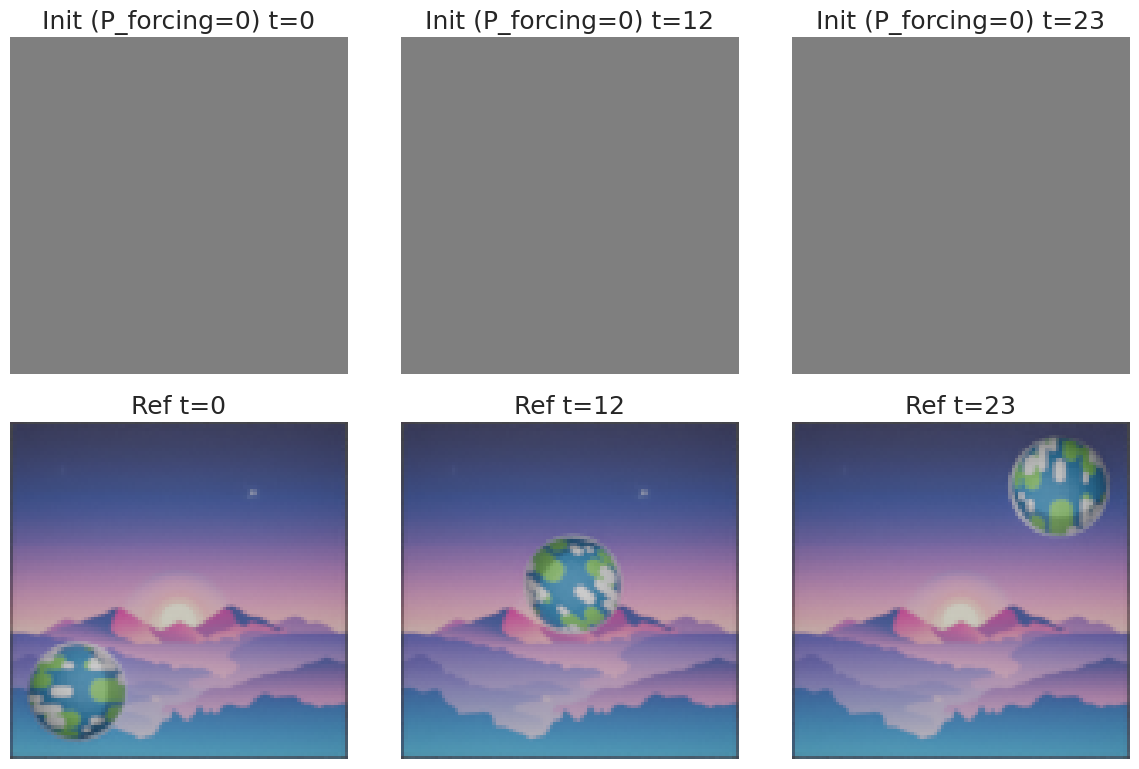


EPOCH: 1


Loss: 0.0299: 100%|██████████| 300/300 [00:36<00:00,  8.20it/s]


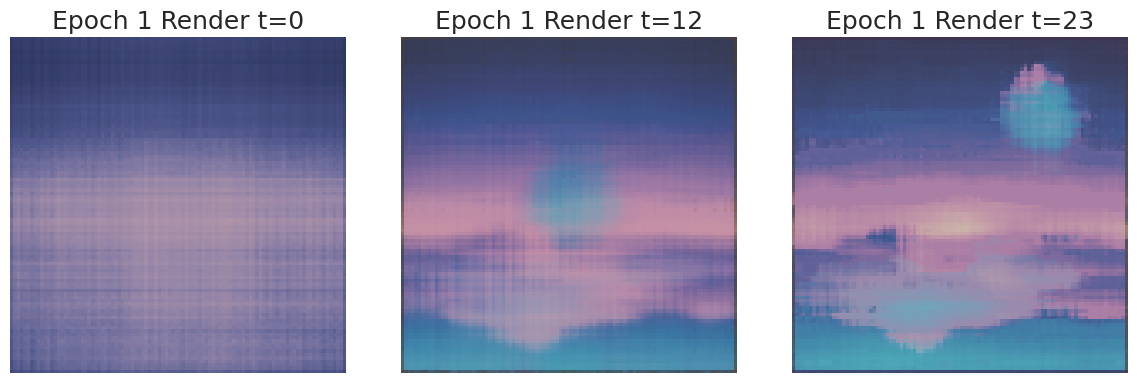


EPOCH: 2


Loss: 0.0181: 100%|██████████| 300/300 [00:35<00:00,  8.55it/s]


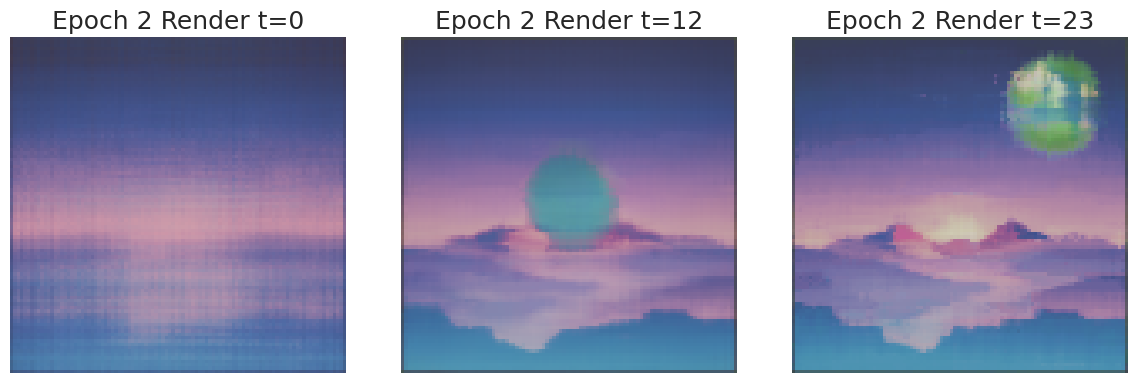


EPOCH: 3


Loss: 0.0138: 100%|██████████| 300/300 [00:35<00:00,  8.55it/s]


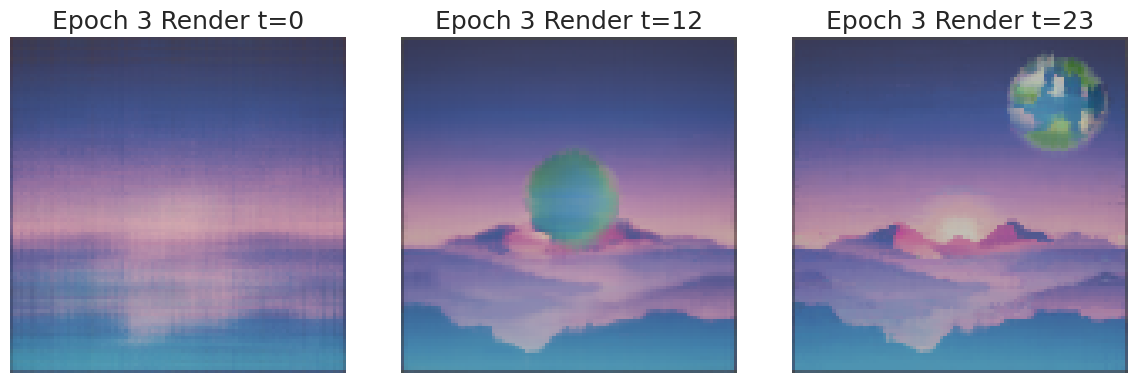


EPOCH: 4


Loss: 0.0122: 100%|██████████| 300/300 [00:35<00:00,  8.57it/s]


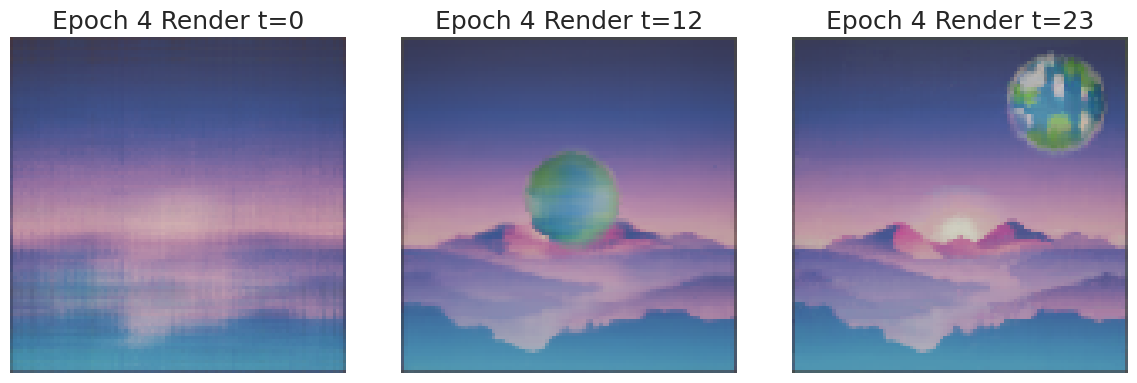


EPOCH: 5


Loss: 0.0108: 100%|██████████| 300/300 [00:35<00:00,  8.56it/s]


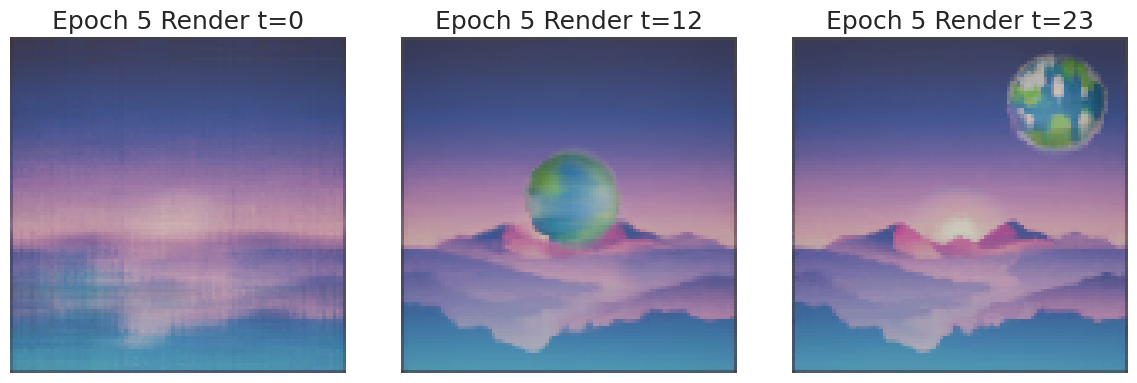


Wall time for WARP training in h:m:s: 00:02:57


In [ ]:
key, subkey = jax.random.split(key)
model = WARP(ROOT_WIDTH, ROOT_DEPTH, NUM_FOURIER_FREQS, (H, W, C), subkey)
A_init = model.A.copy()

scheduler = optax.exponential_decay(LEARNING_RATE, transition_steps=NB_ITER_PER_EPOCH*NB_EPOCHS, decay_rate=0.1)
optimizer = optax.adam(scheduler)
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))

@eqx.filter_jit
def train_step(model, opt_state, key, ref_video, coords_grid, p_forcing):
    # def loss_fn(m):
    #     pred_video = m.get_thetas_and_preds(ref_video, p_forcing, key, coords_grid)
    #     return jnp.mean(jnp.abs(pred_video - ref_video))  # L1 MAE Loss on full video

        # ## Randlomly select nb_loss_frames frames for loss computation
        # frame_indices = jax.random.choice(key, pred_video.shape[0], (NB_LOSS_FRAMES,), replace=False)
        # pred_selected = pred_video[frame_indices]
        # ref_selected = ref_video[frame_indices]
        # return jnp.mean((pred_selected - ref_selected)**2)

        # ## Randomly select pixels for loss computation
        # h_indices = jax.random.choice(key, pred_video.shape[1], (NB_LOSS_PIXELS,), replace=True)
        # w_indices = jax.random.choice(key, pred_video.shape[2], (NB_LOSS_PIXELS,), replace=True)
        # pred_selected = pred_video[:, h_indices, w_indices]
        # ref_selected = ref_video[:, h_indices, w_indices]
        # return jnp.mean((pred_selected - ref_selected)**2)

    def loss_fn(m):
            pred_video = m.get_thetas_and_preds(ref_video, p_forcing, key, coords_grid)
            
            # --- CRITICAL FIX: Use the full video loss ---
            loss_full = jnp.mean(jnp.abs(pred_video - ref_video))
            
            # Add a 2x loss boost explicitly for frame 0 to force theta_0 to wake up quickly
            loss_t0 = jnp.mean(jnp.abs(pred_video[0] - ref_video[0]))
            
            # return loss_full + 100.0 * loss_t0

            return loss_full

    loss_val, grads = eqx.filter_value_and_grad(loss_fn)(model)
    updates, opt_state = optimizer.update(grads, opt_state, eqx.filter(model, eqx.is_inexact_array))
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_val

# Initial Render Plot (Autoregressive, P=0)
print("Rendering Initial Video...")
init_video = model.get_thetas_and_preds(ref_video, p_forcing=0.0, key=key, coords_grid=coords_grid)
plot_pred_ref_videos(init_video, ref_video, title="Init (P_forcing=0)")

all_losses = []
start_time = time.time()

for epoch in range(NB_EPOCHS):
    print(f"\nEPOCH: {epoch+1}")
    epoch_losses = []
    
    pbar = tqdm(range(NB_ITER_PER_EPOCH))
    for i in pbar:
        key, subkey = jax.random.split(key)
        model, opt_state, loss = train_step(model, opt_state, subkey, ref_video, coords_grid, P_FORCING)
        epoch_losses.append(loss)
        
        if i % PRINT_EVERY == 0:
            pbar.set_description(f"Loss: {loss:.4f}")
            
    all_losses.extend(epoch_losses)
    
    # Render progress at end of epoch using P_FORCING = ?
    current_video = eqx.filter_jit(model.get_thetas_and_preds)(ref_video, P_FORCING, key, coords_grid)
    plot_pred_video(current_video, title=f"Epoch {epoch+1} Render")

wall_time = time.time() - start_time
print("\nWall time for WARP training in h:m:s:", time.strftime("%H:%M:%S", time.gmtime(wall_time)))

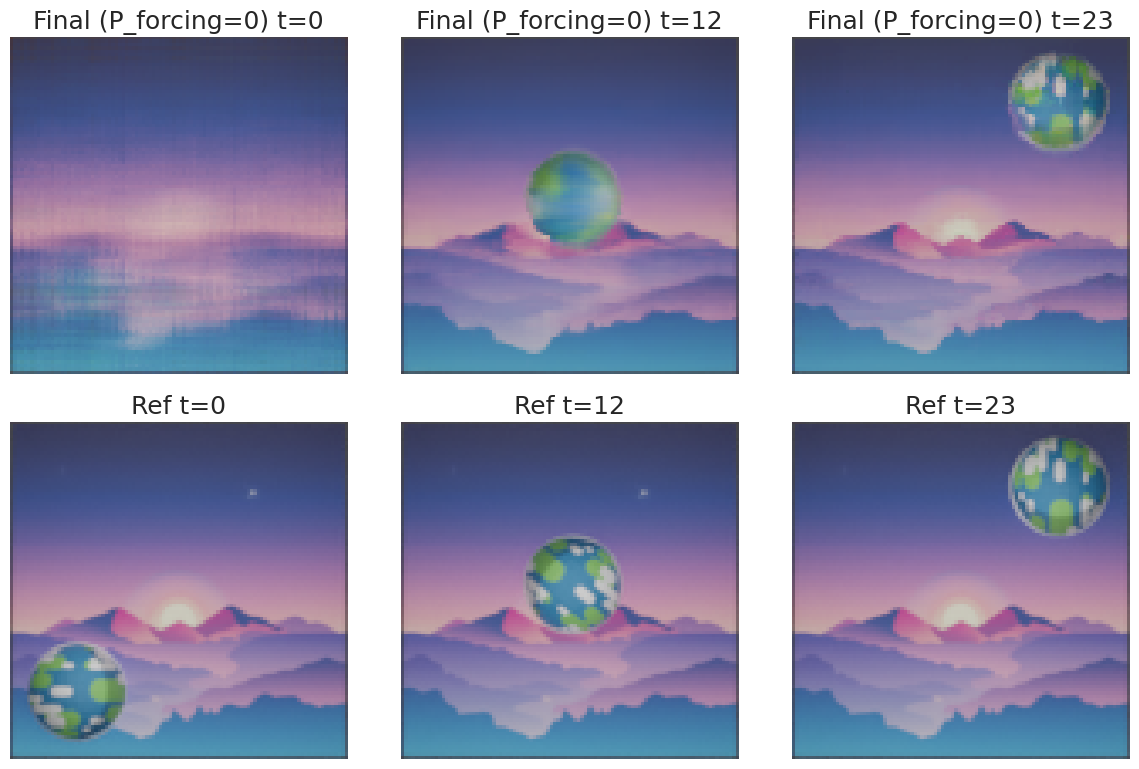

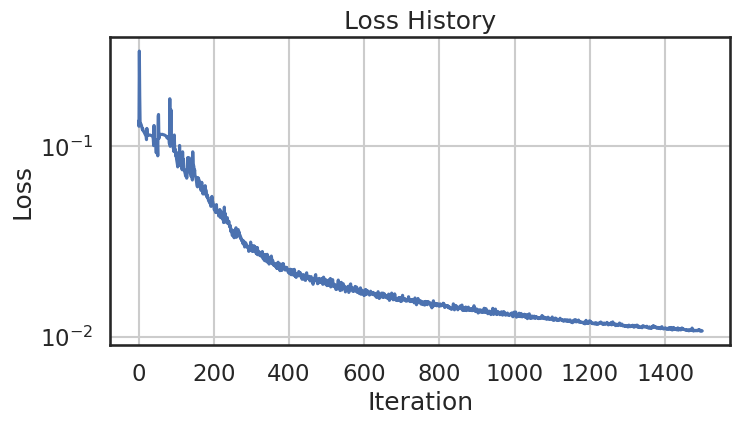

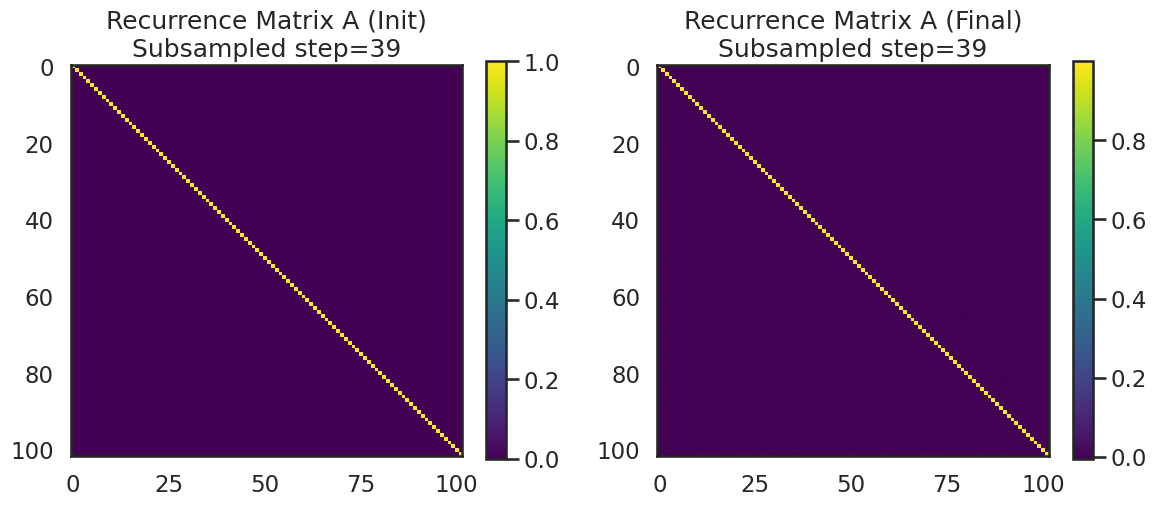

In [ ]:
# Final Video (Autoregressive, P=0)
final_video = eqx.filter_jit(model.get_thetas_and_preds)(ref_video, 0.0, key, coords_grid)
plot_pred_ref_videos(final_video, ref_video, title="Final (P_forcing=0)")

# Plot Loss
plt.figure(figsize=(8, 4))
plt.plot(all_losses)
plt.yscale('log')
plt.title("Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Plot Matrix A Before/After
A_final = model.A
subsample_step = max(1, model.d_theta // 100) 

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
im1 = axes[0].imshow(A_init[::subsample_step, ::subsample_step], cmap='viridis')
axes[0].set_title(f"Recurrence Matrix A (Init)\nSubsampled step={subsample_step}")
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(A_final[::subsample_step, ::subsample_step], cmap='viridis')
axes[1].set_title(f"Recurrence Matrix A (Final)\nSubsampled step={subsample_step}")
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

In [ ]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
from jax.flatten_util import ravel_pytree

import seaborn as sns
sns.set(style="white", context="talk")

# --- Configuration ---
SEED = 2026
key = jax.random.PRNGKey(SEED)

NB_EPOCHS = 5
NB_ITER_PER_EPOCH = 300
PRINT_EVERY = 10
LEARNING_RATE = 1e-4
# NB_LOSS_FRAMES = 2
NB_LOSS_PIXELS = 50
P_FORCING = 0.05
REC_FEAT_DIM = 1024

ROOT_WIDTH = 32
ROOT_DEPTH = 3
NUM_FOURIER_FREQS = 12

In [ ]:
def sbimshow(img, title="", ax=None):
    img = np.clip(img, 0.0, 1.0)
    if ax is None:
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    else:
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')

def plot_pred_ref_videos(video, ref_video, title="Render"):
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))
    t_mid = len(video) // 2
    t_end = len(video) - 1
    # t_mid = 1
    # t_end = 2
    
    sbimshow(video[0], title=f"{title} t=0", ax=ax[0, 0])
    sbimshow(video[t_mid], title=f"{title} t={t_mid}", ax=ax[0, 1])
    sbimshow(video[t_end], title=f"{title} t={t_end}", ax=ax[0, 2])

    sbimshow(ref_video[0], title="Ref t=0", ax=ax[1, 0])
    sbimshow(ref_video[t_mid], title=f"Ref t={t_mid}", ax=ax[1, 1])
    sbimshow(ref_video[t_end], title=f"Ref t={t_end}", ax=ax[1, 2])
    plt.tight_layout()
    plt.show()

def plot_pred_video(video, title="Render"):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    t_mid = len(video) // 2
    t_end = len(video) - 1
    
    sbimshow(video[0], title=f"{title} t=0", ax=ax[0])
    sbimshow(video[t_mid], title=f"{title} t={t_mid}", ax=ax[1])
    sbimshow(video[t_end], title=f"{title} t={t_end}", ax=ax[2])
    plt.tight_layout()
    plt.show()

# --- Data Loading ---
print("Loading Earth frames...")
ref_video = []
try:
    for i in range(1, 25):
        file_number = str(i).zfill(4)
        frame = plt.imread(f'earth_frames/{file_number}.png')[..., :3] / 1.
        ref_video.append(frame)
    ref_video = jnp.stack(ref_video, axis=0)
except FileNotFoundError:
    print("earth_frames folder not found. Generating dummy sequence for testing...")
    ref_video = jax.random.uniform(key, (24, 64, 64, 3))

nb_frames, H, W, C = ref_video.shape
print(f"Video shape: {ref_video.shape}")

# Precompute Normalized Coordinates
y_coords = jnp.linspace(-1, 1, H)
x_coords = jnp.linspace(-1, 1, W)
X_grid, Y_grid = jnp.meshgrid(x_coords, y_coords)
coords_grid = jnp.stack([X_grid, Y_grid], axis=-1)  # [H, W, 2]

Loading Earth frames...
Video shape: (24, 100, 100, 3)


In [ ]:
def fourier_encode(x, num_freqs):
    freqs = 2.0 ** jnp.arange(num_freqs)
    angles = x[..., None] * freqs[None, None, :] * jnp.pi
    angles = angles.reshape(*x.shape[:-1], -1)
    return jnp.concatenate([x, jnp.sin(angles), jnp.cos(angles)], axis=-1)

    # return x

class RootMLP(eqx.Module):
    layers: list

    def __init__(self, in_size, out_size, width, depth, key):
        keys = jax.random.split(key, depth + 1)
        self.layers = [eqx.nn.Linear(in_size, width, key=keys[0])]
        for i in range(depth - 1):
            self.layers.append(eqx.nn.Linear(width, width, key=keys[i+1]))
        self.layers.append(eqx.nn.Linear(width, out_size, key=keys[-1]))

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.relu(layer(x))
        return self.layers[-1](x)

# class CNNEncoder(eqx.Module):
#     """
#     A simple CNN that downsamples spatial dimensions and applies a dense layer.
#     Used for both the hypernetwork \phi and the recurrence feature extractor \psi.
#     """
#     layers: list
    
#     def __init__(self, in_channels, out_dim, spatial_shape, key):
#         H, W = spatial_shape
#         keys = jax.random.split(key, 4)
        
#         # 3 downsampling stages
#         conv_layers = [
#             eqx.nn.Conv2d(in_channels, 16, kernel_size=3, stride=2, padding=1, key=keys[0]),
#             eqx.nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, key=keys[1]),
#             eqx.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, key=keys[2]),
#         ]
        
#         # --- DYNAMIC SHAPE CALCULATION ---
#         # Pass a dummy tensor to automatically calculate the exact flattened dimension
#         dummy_x = jnp.zeros((in_channels, H, W))
#         for layer in conv_layers:
#             dummy_x = layer(dummy_x)
            
#         flat_dim = dummy_x.reshape(-1).shape[0]
        
#         # Assemble the final layers list with the correctly sized Linear layer
#         self.layers = conv_layers + [
#             eqx.nn.Linear(flat_dim, out_dim, key=keys[3])
#         ]
        
#     def __call__(self, x):
#         # Equinox Conv2d expects inputs in (Channels, Height, Width) format
#         for layer in self.layers[:-1]:
#             x = layer(x)
#             x = jax.nn.relu(x)
        
#         x = x.reshape(-1)  # Flatten
#         x = self.layers[-1](x)  # Dense matrix at the end
#         return x


class CNNEncoder(eqx.Module):
    """
    A simple CNN that downsamples spatial dimensions and applies a dense layer.
    Used for both the hypernetwork \phi and the recurrence feature extractor \psi.
    """
    layers: list
    
    def __init__(self, in_channels, out_dim, spatial_shape, key, hidden_width=16, depth=3):
        H, W = spatial_shape
        keys = jax.random.split(key, depth + 1)
        
        # Dynamically build the convolutional layers based on depth
        conv_layers = []
        current_in_channels = in_channels
        current_out_channels = hidden_width
        
        for i in range(depth):
            conv_layers.append(
                eqx.nn.Conv2d(
                    current_in_channels, 
                    current_out_channels, 
                    kernel_size=3, 
                    stride=2, 
                    padding=1, 
                    key=keys[i]
                )
            )
            # Double the feature maps as spatial dimensions halve
            current_in_channels = current_out_channels
            current_out_channels *= 2
            
        # --- DYNAMIC SHAPE CALCULATION ---
        # Pass a dummy tensor to automatically calculate the exact flattened dimension
        dummy_x = jnp.zeros((in_channels, H, W))
        for layer in conv_layers:
            dummy_x = layer(dummy_x)
            
        flat_dim = dummy_x.reshape(-1).shape[0]
        
        # Assemble the final layers list with the correctly sized Linear layer
        self.layers = conv_layers + [
            eqx.nn.Linear(flat_dim, out_dim, key=keys[depth])
        ]
        
    def __call__(self, x):
        # Equinox Conv2d expects inputs in (Channels, Height, Width) format
        for layer in self.layers[:-1]:
            x = layer(x)
            x = jax.nn.relu(x)
        
        x = x.reshape(-1)  # Flatten
        x = self.layers[-1](x)  # Dense matrix at the end
        return x


class DownsamplingLayer(eqx.Module):
    layer: eqx.Module
    def __init__(self, in_channels, out_channels, kernel_size=2, stride=2, *, key):
        self.layer = eqx.nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding="SAME", key=key)
    
    def __call__(self, x):
        return self.layer(x)

class UpsamplingLayer(eqx.Module):
    layer: eqx.Module

    def __init__(self, in_channels, out_channels, kernel_size=2, stride=2, *, key):
        self.layer = eqx.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding="SAME", key=key)

    def __call__(self, x):
        return self.layer(x)

class DoubleConv(eqx.Module):
    layer_1: eqx.Module
    layer_2: eqx.Module
    activation: callable
    norm_layer: eqx.Module
    dropout_rate: float

    def __init__(self, in_channels, out_channels, kernel_size=3, activation=jax.nn.relu, batch_norm=False, dropout_rate=0., *, key):
        k1, k2 = jax.random.split(key, 2)

        self.layer_1 = eqx.nn.Conv2d(in_channels, out_channels, kernel_size, padding='SAME', key=k1)
        self.layer_2 = eqx.nn.Conv2d(out_channels, out_channels, kernel_size, padding='SAME', key=k2)
        self.activation = activation
        
        if batch_norm:
            self.norm_layer = eqx.nn.BatchNorm(input_size=out_channels, axis_name=None)
        else:
            self.norm_layer = None
            
        self.dropout_rate = dropout_rate

    def __call__(self, x):
        x = self.layer_1(x)
        x = self.activation(x)
        x = self.layer_2(x)
        x = self.activation(x)
        if self.norm_layer:
            x = self.norm_layer(x)
        if self.dropout_rate > 0.:
            x = eqx.nn.Dropout(self.dropout_rate)(x)
        return x

class VNetEncoder(eqx.Module):
    input_shape: tuple
    out_dim: int
    levels: int
    depth: int
    kernel_size: int
    activation: callable
    batch_norm: bool
    dropout_rate: float

    ## Learnable params
    left_doubleconvs: dict
    right_doubleconvs: dict
    downsamplings: dict
    upsamplings: dict
    final_conv: eqx.Module
    final_linear: eqx.nn.Linear

    def __init__(self, input_shape, out_dim, levels=4, depth=16, kernel_size=3, activation=jax.nn.relu, batch_norm=False, dropout_rate=0., *, key):
        l_key, r_key, d_key, u_key, f_key, lin_key = jax.random.split(key, 6)

        self.input_shape = input_shape      ## (C, H, W)
        self.out_dim = out_dim              ## Flat output size
        self.levels = levels
        self.depth = depth                  ## Number of filters in the first layer
        self.kernel_size = kernel_size
        self.activation = activation
        self.batch_norm = batch_norm
        self.dropout_rate = dropout_rate

        self.left_doubleconvs = {}
        self.right_doubleconvs = {}
        self.downsamplings = {}
        self.upsamplings = {}
        
        # Maintains depth channels for the final spatial projection
        self.final_conv = eqx.nn.Conv2d(depth, depth, 1, padding="SAME", key=f_key)

        d_keys = jax.random.split(d_key, levels-1)
        l_keys = jax.random.split(l_key, levels)

        self.left_doubleconvs[0] = DoubleConv(input_shape[0], depth, kernel_size, activation, batch_norm, dropout_rate, key=l_keys[0])
        for i in range(1, levels):
            self.downsamplings[i] = DownsamplingLayer(self.depth*2**(i-1), self.depth*2**(i), key=d_keys[i-1])
            self.left_doubleconvs[i] = DoubleConv(self.depth*2**(i), self.depth*2**(i), kernel_size, activation, batch_norm, dropout_rate, key=l_keys[i])

        u_keys = jax.random.split(u_key, levels-1)
        r_keys = jax.random.split(r_key, levels-1)

        for i in range(self.levels-2, -1, -1):
            self.upsamplings[i] = UpsamplingLayer(self.depth*2**(i+1), self.depth*2**i, key=u_keys[i])
            self.right_doubleconvs[i] = DoubleConv(self.depth*2**(i), self.depth*2**i, kernel_size, activation, batch_norm, dropout_rate, key=r_keys[i])

        # --- DYNAMIC SHAPE CALCULATION ---
        dummy_x = jnp.zeros(input_shape)
        dummy_out = self._forward_features(dummy_x)
        flat_dim = dummy_out.reshape(-1).shape[0]

        # Final dense mapping to your requested 1D state
        self.final_linear = eqx.nn.Linear(flat_dim, out_dim, key=lin_key)

    def _forward_features(self, inputs):
        left = {}
        left[0] = self.left_doubleconvs[0](inputs)
        for i in range(1, self.levels):
            down = self.downsamplings[i](left[i-1])
            conv = self.left_doubleconvs[i](down)
            left[i] = down + conv

        central = left[self.levels-1]
        right = central

        for i in range(self.levels-2, -1,-1):
            up = self.upsamplings[i](right)
            add = left[i] + up
            conv = self.right_doubleconvs[i](add)
            right = up + conv

        return self.activation(self.final_conv(right))

    def __call__(self, inputs):
        # 1. Extract VNet features
        features = self._forward_features(inputs)
        # 2. Flatten
        flat_features = features.reshape(-1)
        # 3. Project to out_dim
        return self.final_linear(flat_features)

class WARP(eqx.Module):
    A: jax.Array
    B: jax.Array
    hypernet_phi: CNNEncoder
    psi_net: CNNEncoder
    
    root_structure: RootMLP = eqx.field(static=True)
    unravel_fn: callable = eqx.field(static=True)
    d_theta: int = eqx.field(static=True)
    num_freqs: int = eqx.field(static=True)
    frame_shape: tuple = eqx.field(static=True)

    def __init__(self, root_width, root_depth, num_freqs, frame_shape, key):
        k_root, k_A, k_B, k_phi, k_psi = jax.random.split(key, 5)
        self.num_freqs = num_freqs
        self.frame_shape = frame_shape
        H, W, C = frame_shape
        
        # Spatial input only (no tau)
        coord_dim = 2 + 2 * 2 * num_freqs 
        template_root = RootMLP(coord_dim, 7, root_width, root_depth, k_root)

        flat_params, self.unravel_fn = ravel_pytree(template_root)
        self.d_theta = flat_params.shape[0]
        self.root_structure = template_root
        
        # 1. Hypernetwork \phi: Maps initial frame (C channels) -> theta_0
        # self.hypernet_phi = CNNEncoder(in_channels=C, out_dim=self.d_theta, spatial_shape=(H, W), key=k_phi)
        # self.hypernet_phi = eqx.nn.Linear(H*W*C, self.d_theta, key=k_phi)
        # self.hypernet_phi = VNetEncoder(
        #             input_shape=(C, H, W), 
        #             out_dim=self.d_theta, 
        #             levels=2, 
        #             depth=8, 
        #             batch_norm=False, 
        #             key=k_phi
        #         )
        self.hypernet_phi = CNNEncoder(in_channels=C, out_dim=self.d_theta, spatial_shape=(H, W), key=k_phi, hidden_width=32, depth=6)

        # 2. CNN \psi: Extracts features from [frame_t, prev_frame_selected]
        # We concatenate them along channels, so in_channels = 2 * C
        d_feat = REC_FEAT_DIM  # Dimension of the feature vector extracted by \psi
        self.psi_net = CNNEncoder(in_channels=1 * C, out_dim=d_feat, spatial_shape=(H, W), key=k_psi, hidden_width=16, depth=3)
        
        # 3. Recurrence Matrices
        self.A = jnp.eye(self.d_theta)
        # B is now significantly reduced: (d_theta, d_feat) instead of (d_theta, H*W*C)
        self.B = jnp.zeros((self.d_theta, d_feat))

        print(f"Model Initialized:")
        print(f"  d_theta (State Size): {self.d_theta}")
        print(f"  Matrix A Shape: {self.A.shape}")
        print(f"  Matrix B Shape: {self.B.shape}")

    def render_pixels(self, thetas, coords):
        def render_pt(theta, coord):
            root = self.unravel_fn(theta)
            encoded_coord = fourier_encode(coord, self.num_freqs)
            out = root(encoded_coord)
            
            rgb_fg = jax.nn.sigmoid(out[0:3])
            rgb_bg = jax.nn.sigmoid(out[3:6])
            alpha  = jax.nn.sigmoid(out[6:7])
            return alpha * rgb_fg + (1.0 - alpha) * rgb_bg

        return jax.vmap(render_pt)(thetas, coords)

    def get_thetas_and_preds(self, ref_video, p_forcing, key, coords_grid):
        H, W, C = self.frame_shape
        flat_coords = coords_grid.reshape(-1, 2)
        
        # --- NEW: Get initial theta_0 from Hypernetwork \phi ---
        init_gt_frame = ref_video[0]
        # Equinox convolutions expect (C, H, W)
        init_gt_frame_chw = jnp.transpose(init_gt_frame, (2, 0, 1)) 
        # init_gt_frame_chw = init_gt_frame.reshape(-1)       ## TODO
        theta_0 = self.hypernet_phi(init_gt_frame_chw)
        
        def scan_step(state, gt_curr_frame):
            theta, prev_frame_selected, k = state
            k, subk = jax.random.split(k)
            
            # 1. Render current frame
            thetas_frame = jnp.tile(theta, (H*W, 1))
            pred_flat = self.render_pixels(thetas_frame, flat_coords)
            pred_frame = pred_flat.reshape(H, W, C)
            
            # 2. Bernoulli Teacher Forcing decision
            use_gt = jax.random.bernoulli(subk, p_forcing)
            frame_t = jnp.where(use_gt, gt_curr_frame, pred_frame)
            
            # # --- NEW: Compute dense features via CNN \psi ---
            # # Concatenate current frame and prev frame (H, W, 2*C)
            # concat_frames = jnp.concatenate([frame_t, prev_frame_selected], axis=-1)
            # # Transpose to (2*C, H, W) for Equinox Conv2D
            # concat_frames_chw = jnp.transpose(concat_frames, (2, 0, 1))
            
            # # Pass through \psi
            # dx_feat = self.psi_net(concat_frames_chw)

            # Variance scaling for stable gradients in the recurrence
            # dx_feat = dx_feat / jnp.sqrt(dx_feat.size)

            frame_t_feats = self.psi_net(jnp.transpose(frame_t, (2, 0, 1)))
            prev_frame_selected_feats = self.psi_net(jnp.transpose(prev_frame_selected, (2, 0, 1)))

            dx_feat = (frame_t_feats - prev_frame_selected_feats) / jnp.sqrt(frame_t_feats.size)

            # 4. Weight-space Recurrence Update
            theta_next = self.A @ theta + self.B @ dx_feat
            
            new_state = (theta_next, frame_t, subk)
            return new_state, pred_frame
            
        init_frame = jnp.zeros((H, W, C))
        init_state = (theta_0, init_frame, key)
        
        # Scan over the sequence length
        _, pred_video = jax.lax.scan(scan_step, init_state, ref_video)
        return pred_video

<>:68: SyntaxWarning: invalid escape sequence '\p'
<>:68: SyntaxWarning: invalid escape sequence '\p'
<ipython-input-28-28ed9ee77e19>:68: SyntaxWarning: invalid escape sequence '\p'
  """


<ipython-input-29-8812e702354b>:3: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = WARP(ROOT_WIDTH, ROOT_DEPTH, NUM_FOURIER_FREQS, (H, W, C), subkey)


Model Initialized:
  d_theta (State Size): 3975
  Matrix A Shape: (3975, 3975)
  Matrix B Shape: (3975, 1024)
Rendering Initial Video...


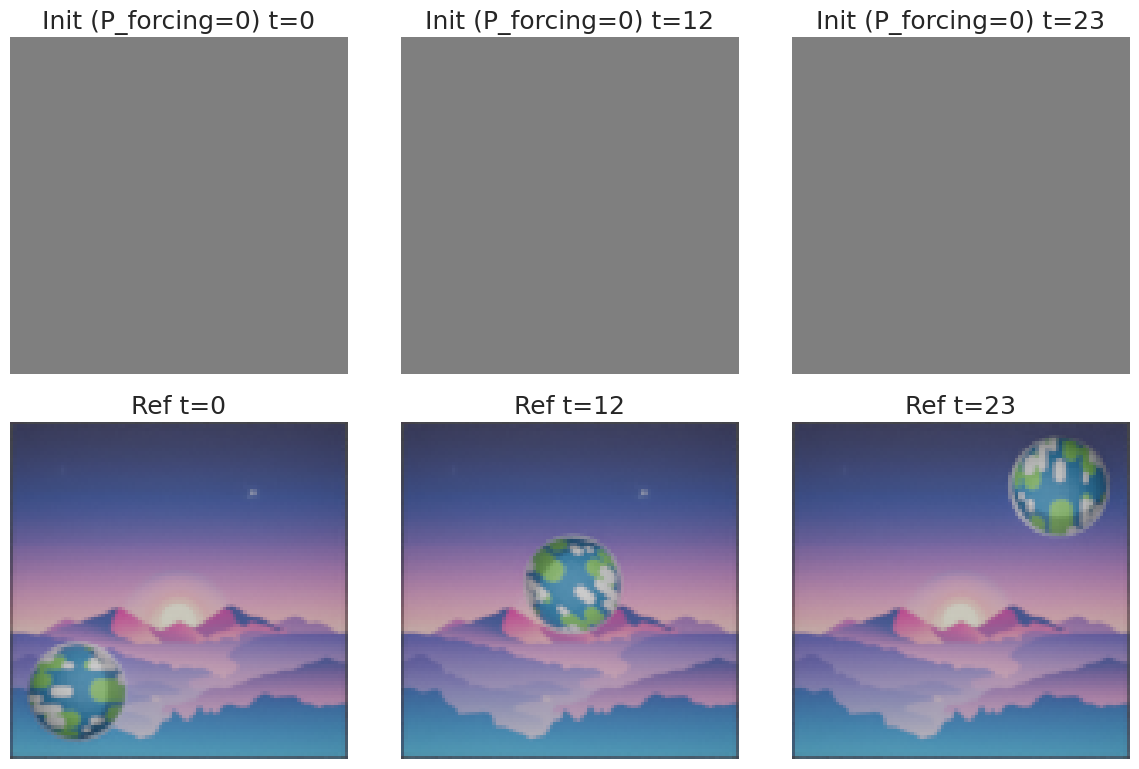


EPOCH: 1


Loss: 0.0384: 100%|██████████| 300/300 [00:36<00:00,  8.23it/s]


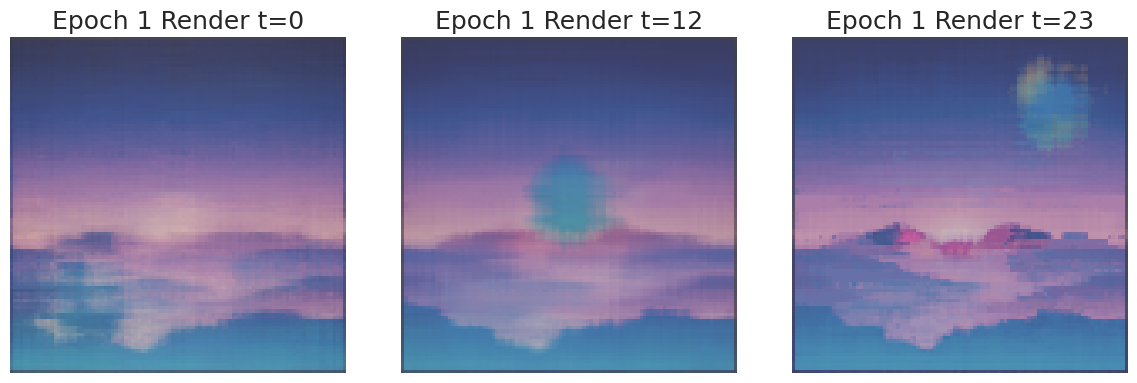


EPOCH: 2


Loss: 0.0283: 100%|██████████| 300/300 [00:34<00:00,  8.59it/s]


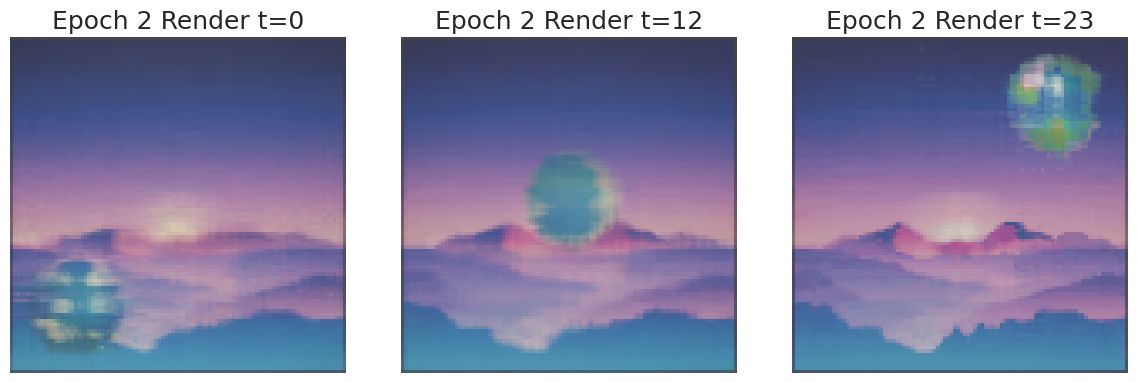


EPOCH: 3


Loss: 0.0233: 100%|██████████| 300/300 [00:34<00:00,  8.57it/s]


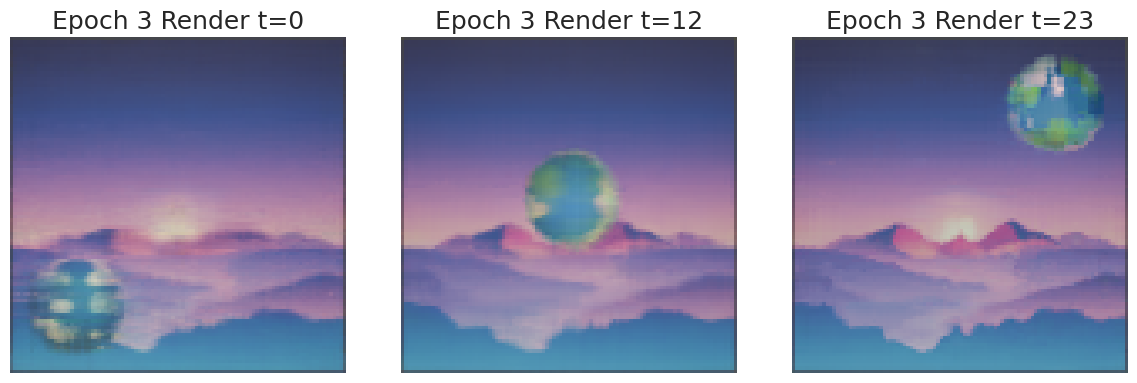


EPOCH: 4


Loss: 0.0204: 100%|██████████| 300/300 [00:34<00:00,  8.57it/s]


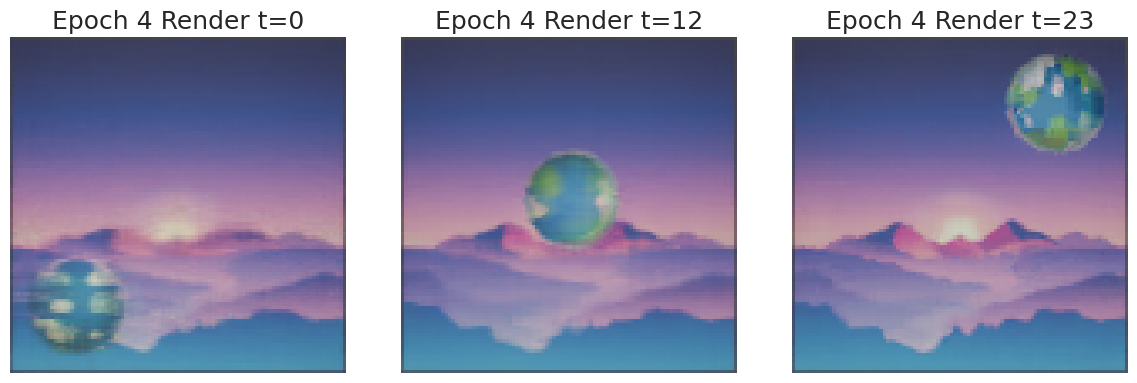


EPOCH: 5


Loss: 0.0189: 100%|██████████| 300/300 [00:34<00:00,  8.65it/s]


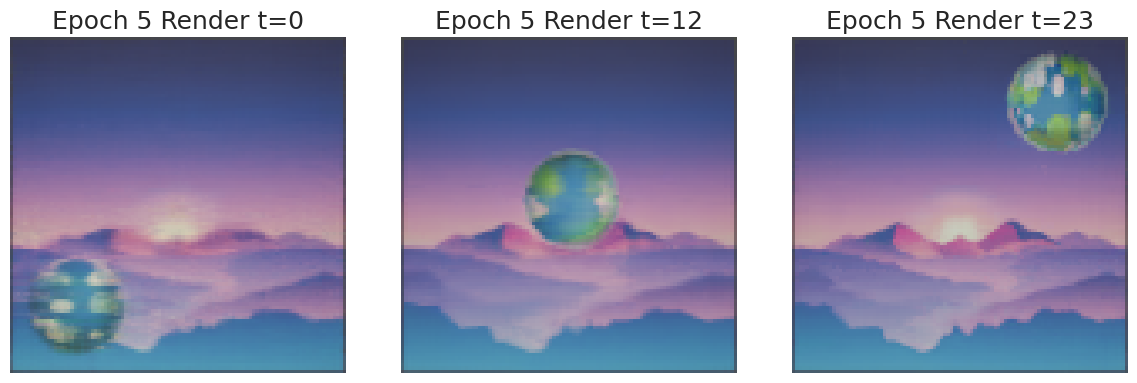


Wall time for WARP training in h:m:s: 00:02:56


In [ ]:
key, subkey = jax.random.split(key)
model = WARP(ROOT_WIDTH, ROOT_DEPTH, NUM_FOURIER_FREQS, (H, W, C), subkey)
A_init = model.A.copy()

scheduler = optax.exponential_decay(LEARNING_RATE, transition_steps=NB_ITER_PER_EPOCH*NB_EPOCHS, decay_rate=0.1)
optimizer = optax.adam(scheduler)
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))

@eqx.filter_jit
def train_step(model, opt_state, key, ref_video, coords_grid, p_forcing):
    # def loss_fn(m):
    #     pred_video = m.get_thetas_and_preds(ref_video, p_forcing, key, coords_grid)
    #     return jnp.mean(jnp.abs(pred_video - ref_video))  # L1 MAE Loss on full video

        # ## Randlomly select nb_loss_frames frames for loss computation
        # frame_indices = jax.random.choice(key, pred_video.shape[0], (NB_LOSS_FRAMES,), replace=False)
        # pred_selected = pred_video[frame_indices]
        # ref_selected = ref_video[frame_indices]
        # return jnp.mean((pred_selected - ref_selected)**2)

        # ## Randomly select pixels for loss computation
        # h_indices = jax.random.choice(key, pred_video.shape[1], (NB_LOSS_PIXELS,), replace=True)
        # w_indices = jax.random.choice(key, pred_video.shape[2], (NB_LOSS_PIXELS,), replace=True)
        # pred_selected = pred_video[:, h_indices, w_indices]
        # ref_selected = ref_video[:, h_indices, w_indices]
        # return jnp.mean((pred_selected - ref_selected)**2)

    def loss_fn(m):
            pred_video = m.get_thetas_and_preds(ref_video, p_forcing, key, coords_grid)
            
            # --- CRITICAL FIX: Use the full video loss ---
            loss_full = jnp.mean(jnp.abs(pred_video - ref_video))
            
            # Add a 2x loss boost explicitly for frame 0 to force theta_0 to wake up quickly
            loss_t0 = jnp.mean(jnp.abs(pred_video[0] - ref_video[0]))
            
            return loss_full + 1.0 * loss_t0

            # return loss_full

    loss_val, grads = eqx.filter_value_and_grad(loss_fn)(model)
    updates, opt_state = optimizer.update(grads, opt_state, eqx.filter(model, eqx.is_inexact_array))
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_val

# Initial Render Plot (Autoregressive, P=0)
print("Rendering Initial Video...")
init_video = model.get_thetas_and_preds(ref_video, p_forcing=0.0, key=key, coords_grid=coords_grid)
plot_pred_ref_videos(init_video, ref_video, title="Init (P_forcing=0)")

all_losses = []
start_time = time.time()

for epoch in range(NB_EPOCHS):
    print(f"\nEPOCH: {epoch+1}")
    epoch_losses = []
    
    pbar = tqdm(range(NB_ITER_PER_EPOCH))
    for i in pbar:
        key, subkey = jax.random.split(key)
        model, opt_state, loss = train_step(model, opt_state, subkey, ref_video, coords_grid, P_FORCING)
        epoch_losses.append(loss)
        
        if i % PRINT_EVERY == 0:
            pbar.set_description(f"Loss: {loss:.4f}")
            
    all_losses.extend(epoch_losses)
    
    # Render progress at end of epoch using P_FORCING = ?
    current_video = eqx.filter_jit(model.get_thetas_and_preds)(ref_video, P_FORCING, key, coords_grid)
    plot_pred_video(current_video, title=f"Epoch {epoch+1} Render")

wall_time = time.time() - start_time
print("\nWall time for WARP training in h:m:s:", time.strftime("%H:%M:%S", time.gmtime(wall_time)))

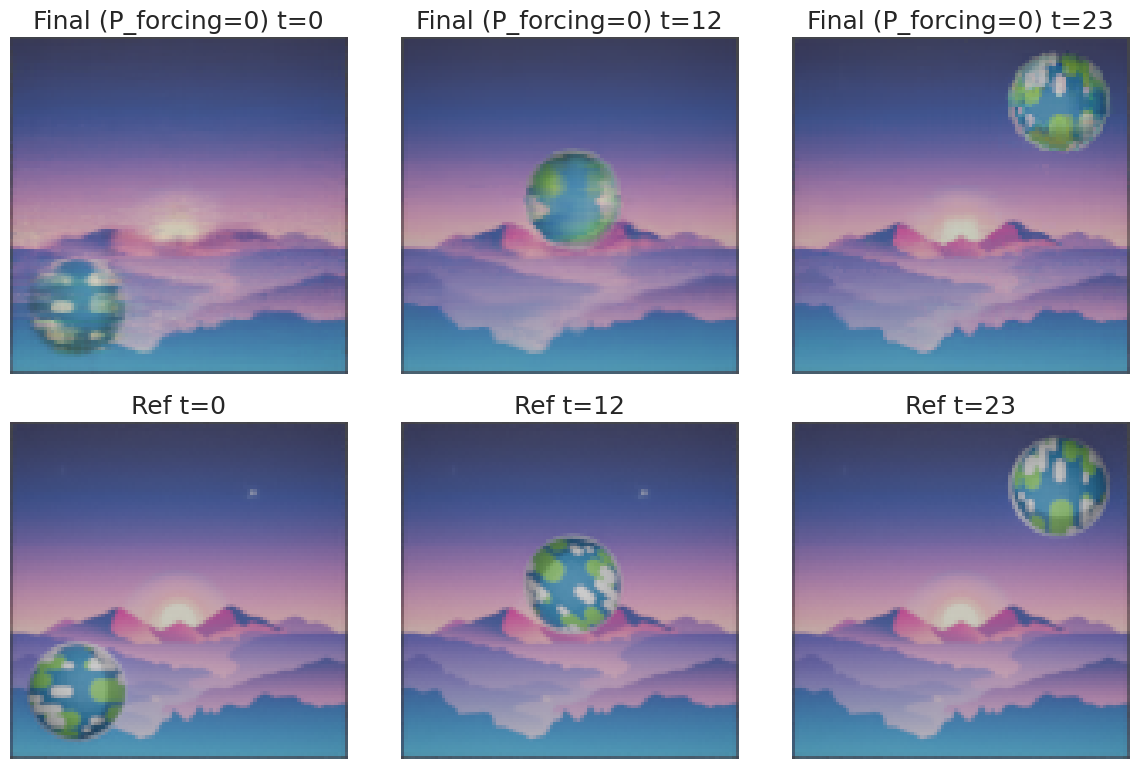

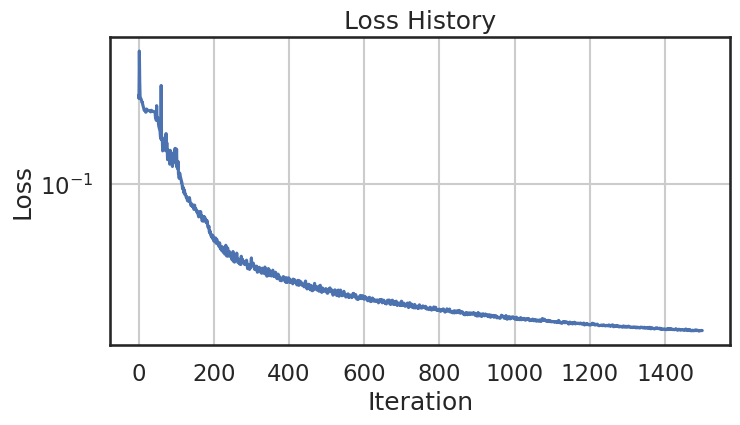

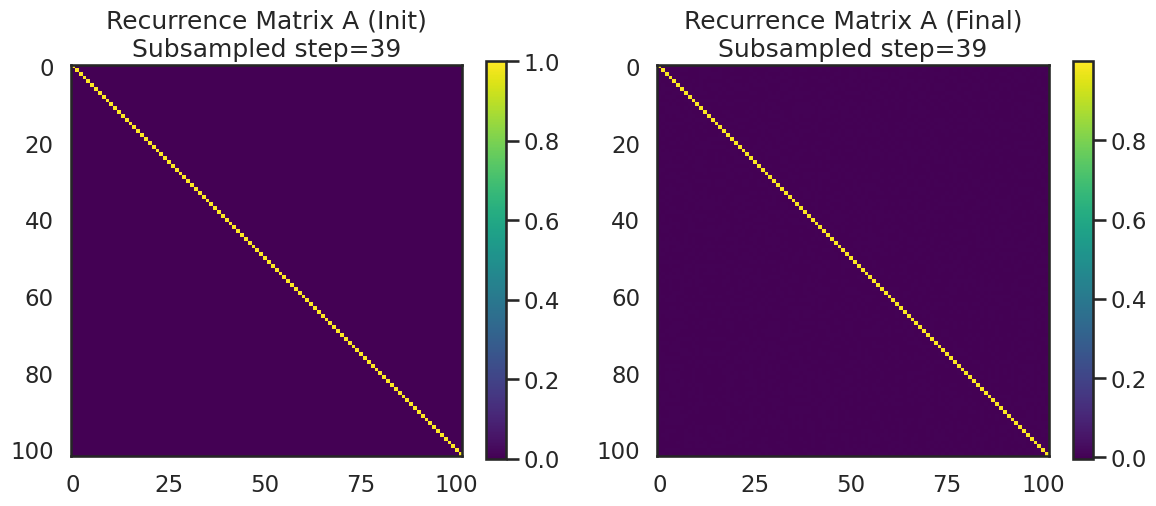

In [ ]:
# Final Video (Autoregressive, P=0)
final_video = eqx.filter_jit(model.get_thetas_and_preds)(ref_video, 0.0, key, coords_grid)
plot_pred_ref_videos(final_video, ref_video, title="Final (P_forcing=0)")

# Plot Loss
plt.figure(figsize=(8, 4))
plt.plot(all_losses)
plt.yscale('log')
plt.title("Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Plot Matrix A Before/After
A_final = model.A
subsample_step = max(1, model.d_theta // 100) 

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
im1 = axes[0].imshow(A_init[::subsample_step, ::subsample_step], cmap='viridis')
axes[0].set_title(f"Recurrence Matrix A (Init)\nSubsampled step={subsample_step}")
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(A_final[::subsample_step, ::subsample_step], cmap='viridis')
axes[1].set_title(f"Recurrence Matrix A (Final)\nSubsampled step={subsample_step}")
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

In [ ]:
# Total parameter in the model
total_params = sum(param.size for param in eqx.filter(model, eqx.is_inexact_array))
print(f"Total Trainable Parameters in WARP: {total_params}")

TypeError: 'WARP' object is not iterable

In [ ]:
def count_trainable_params(model):
    def count_params(x):
        if isinstance(x, jnp.ndarray) and x.dtype in [jnp.float32, jnp.float64]:
            return x.size
        else:
            return 0

    param_counts = jax.tree_util.tree_map(count_params, model)
    total_params = sum(jax.tree_util.tree_leaves(param_counts))
    return total_params

# Total parameter in the model
total_params = count_trainable_params(model)
print(f"Total Trainable Parameters in WARP: {total_params}")

Total Trainable Parameters in WARP: 53544984
